<a href="https://colab.research.google.com/github/Sohaib9920/DeepLearning_notebooks/blob/main/hands_on_machine_learning_3rd_edition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Training Model

## Solving Vanishing/Exploding Gradients Problem:

Gradients often get smaller and smaller as the algorithm progresses down to the lower layers. As a result, the gradient descent update leaves the lower layers’ connection weights virtually unchanged, and training never converges to a good solution. This is called the vanishing gradients problem. In some cases, the opposite can happen: the gradients can grow bigger and bigger until layers get insanely large weight updates and the algorithm diverges. This is the exploding gradients problem, which surfaces most often in recurrent neural networks. More generally, deep neural networks suffer from unstable gradients; different layers may learn at widely different speeds.

We can solve this problem and improve performance using following techniques:

### 1. Weight Initialization:

By default, Keras uses Glorot initialization with a uniform distribution.

We don’t want the signal to die out, nor do we want it to explode and saturate. For the signal to flow properly, we need the variance of the outputs of each layer to be equal to the variance of its inputs.

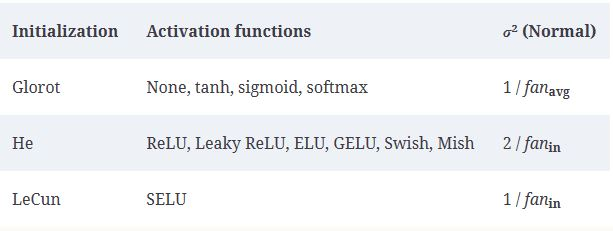

### 2. Better activations:


#### ReLU:

- Usually preferred
- It does not saturate for positive values, and is very fast to compute.
- It suffers from a problem known as the dying ReLUs: during training, some neurons effectively “die”, meaning they stop outputting anything other than 0.

#### LeakyReLU:
- $LeakyReLU_α(z) = max(αz, z)$
- The hyperparameter α defines how much the function “leaks”: it is the slope of the function for z < 0
- Having a slope for z < 0 ensures that leaky ReLUs never die; they can go into a long coma, but they have a chance to eventually wake up
- LeakyReLU always outperformed the strict ReLU activation function. In fact, setting α = 0.2 (a huge leak) seemed to result in better performance than α = 0.01 (a small leak)
- Parametric leaky ReLU (PReLU), where α is authorized to be learned during training. PReLU was reported to strongly outperform ReLU on large image datasets, but on smaller datasets it runs the risk of overfitting the training set

ReLU, leaky ReLU, and PReLU all suffer from the fact that they are not smooth functions: their derivatives abruptly change (at z = 0). This sort of discontinuity can make gradient descent bounce around the optimum, and slow down convergence.

#### ELU:
- Exponential linear unit (ELU) outperformed all the ReLU variants: training time was reduced, and the neural network performed better on the test set.
- $$
ELU(z) = \begin{cases}
  z & \text{if } z > 0, \\
  \alpha \cdot (e^z - 1) & \text{if } x \leq 0.
\end{cases}
$$
- If α is equal to 1 then the function is smooth everywhere, including around z = 0, which helps speed up gradient descent since it does not bounce as much to the left and right of z = 0.
- The main drawback of the ELU activation function is that it is slower to compute than the ReLU function and its variants (due to the use of the exponential function). Its faster convergence rate during training may compensate for that slow computation, but still, at test time an ELU network will be a bit slower than a ReLU network.

#### SELU:
- It is a scaled variant of the ELU activation function (about 1.05 times ELU, using α ≈ 1.67)
- The SELU activation function, when used in a multi-layer perceptron (MLP) with LeCun normal weight initialization and standardized input features, can enable self-normalization. This means that the output of each layer tends to maintain a mean of 0 and a standard deviation of 1 during training, addressing the vanishing/exploding gradients problem. However, self-normalization is only guaranteed for plain MLPs with standardized inputs; using SELU in other architectures may not outperform ELU. Additionally, certain regularization techniques like ℓ1 or ℓ2 regularization, max-norm, batch-norm, and regular dropout are incompatible with SELU.

#### GELU:
- $GELU = zΦ(z)$ is a smooth variant of the ReLU activation function. Φ is the standard Gaussian cumulative distribution function which corresponds to the probability that a value sampled randomly from a normal distribution of mean 0 and variance 1 is lower than z.
- It often outperforms every other activation function discussed so far. However, it is a bit more computationally intensive, and the performance boost it provides is not always sufficient to justify the extra cost.
- It is possible to show that it is approximately equal to $zσ(1.702 z)$, where σ is the sigmoid function: using this approximation also works very well, and it has the advantage of being much faster to compute.

#### Swish:
- $Swish = zσ(z)$ Outperforms GELU.
- The generalized Swish function is $Swish_β(z) = zσ(βz)$, so GELU is approximately equal to the generalized Swish function using β = 1.702.
- It’s also possible to make β trainable and let gradient descent optimize it: much like PReLU, this can make your model more powerful, but it also runs the risk of overfitting the data.

#### Mish:
- It is defined as $mish(z) = ztanh(softplus(z))$, where $softplus(z) = log(1 + exp(z))$. Just like GELU and Swish, it is a smooth, nonconvex, and nonmonotonic variant of ReLU, and once again the author ran many experiments and found that Mish generally outperformed other activation functions—even Swish and GELU, by a tiny margin.

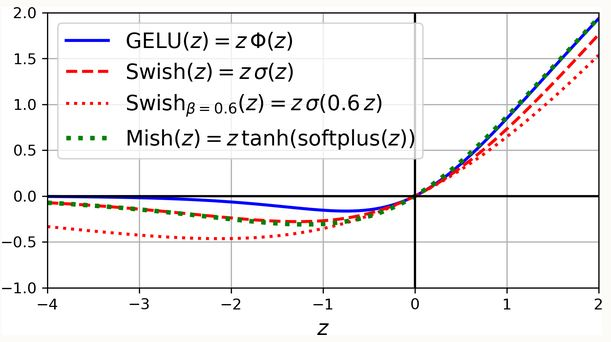

#### Summary:
So, which activation function should you use for the hidden layers of your deep neural networks?

- ReLU is usually a good default for the hidden layers, as it is fast and yields good results. Its ability to output precisely zero can also be useful in some cases. Moreover, it can sometimes benefit from optimized implementations as well as from hardware acceleration.
- The leaky ReLU variants of ReLU can improve the model's quality without hindering its speed too much compared to ReLU.
- For large neural nets and more complex problems, GLU, Swish and Mish can give you a slightly higher quality model, but they have a computational cost. Swish is the good default.
- The hyperbolic tangent (tanh) can be useful in the output layer if you need to output a number in a fixed range (by default between –1 and 1), but nowadays it is not used much in hidden layers, except in recurrent nets.
- The sigmoid activation function is also useful in the output layer when you need to estimate a probability (e.g., for binary classification), but it is rarely used in hidden layers (there are exceptions—for example, for the coding layer of variational autoencoders).
- The softplus activation function is useful in the output layer when you need to ensure that the output will always be positive.
- The softmax activation function is useful in the output layer to estimate probabilities for mutually exclusive classes, but it is rarely (if ever) used in hidden layers.

### 3. Batch Normalization:

- This operation simply zero-centers and normalizes each input, then scales and shifts the result using two new parameter vectors per layer: one for scaling, the other for shifting. In other words, the operation lets the model learn the optimal scale and mean of each of the layer’s inputs.
- In order to zero-center and normalize the inputs, the algorithm needs to estimate each input’s mean and standard deviation. It does so by evaluating the mean and standard deviation of the input over the current mini-batch (hence the name “batch normalization”).


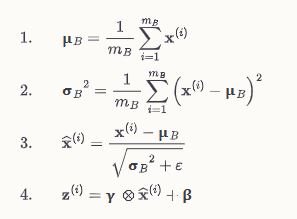

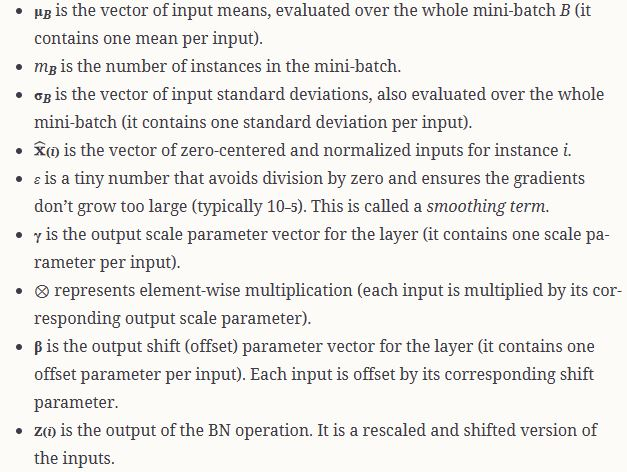

- In many cases, if you add a BN layer as the very first layer of your neural network, you do not need to standardize your training set. That is, there’s no need for StandardScaler or Normalization; the BN layer will do it for you (well, approximately, since it only looks at one batch at a time, and it can also rescale and shift each input feature).

So during training, BN standardizes its inputs, then rescales and offsets them. Good! What about at test time?

-  Indeed, we may need to make predictions for individual instances rather than for batches of instances: in this case, we will have no way to compute each input’s mean and standard deviation. Moreover, even if we do have a batch of instances, it may be too small, or the instances may not be independent and identically distributed, so computing statistics over the batch instances would be unreliable.
- One solution could be to wait until the end of training, then run the whole training set through the neural network and compute the mean and standard deviation of each input of the BN layer. These “final” input means and standard deviations could then be used instead of the batch input means and standard deviations when making predictions.
- However, most implementations of batch normalization estimate these final statistics during training by using a exponential moving average of the layer’s input means and standard deviations. This is what Keras does automatically when you use the BatchNormalization layer. Exponential moving average is also more mermory efficient then avearge of batch means for a neuron because we only need to track single variable rather than history of batch means.

To sum up, **four parameter vectors** are learned in each batch-normalized layer:
- γ (the output scale vector) and β (the output offset vector) are learned through regular backpropagation, and
- μ (the final input mean vector) and σ (the final input standard deviation vector) are estimated using an exponential moving average. They are not affected by backpropagation, so Keras calls them “non-trainable”.
- Note that μ and σ are estimated during training, but they are used only after training (to replace the batch input means and standard deviations in above Equation).

Comments on Batch Normalization:

- Ioffe and Szegedy demonstrated that Batch normalization considerably improved all the deep neural networks they experimented with, leading to a huge improvement in the ImageNet classification task. The vanishing gradients problem was strongly reduced, to the point that they could use saturating activation functions such as the tanh and even the sigmoid activation function. The networks were also much less sensitive to the weight initialization. The authors were able to use much larger learning rates, significantly speeding up the learning process. Specifically, they note that:

    > *Applied to a state-of-the-art image classification model, batch normalization achieves the same accuracy with 14 times fewer training steps, and beats the original model by a significant margin. […​] Using an ensemble of batch-normalized networks, we improve upon the best published result on ImageNet classification: reaching 4.9% top-5 validation error (and 4.8% test error), exceeding the accuracy of human raters.*



- Batch normalization acts like a regularizer, reducing the need for other regularization techniques (such as dropout).
- You may find that training is rather slow, because each epoch takes much more time when you use batch normalization. This is usually counterbalanced by the fact that convergence is much faster with BN, so it will take fewer epochs to reach the same performance. All in all, wall time will usually be shorter (this is the time measured by the clock on your wall).
- However, there is a runtime penalty: the neural network makes slower predictions due to the extra computations required at each layer. Fortunately, it’s often possible to fuse the BN layer with the previous layer after training, thereby avoiding the runtime penalty. This is done by updating the previous layer’s weights and biases so that it directly produces outputs of the appropriate scale and offset. For example, if the previous layer computes XW + b, then the BN layer will compute γ ⊗ (XW + b – μ) / σ + β (ignoring the smoothing term ε in the denominator). If we define W′ = γ⊗W / σ and b′ = γ ⊗ (b – μ) / σ + β, the equation simplifies to XW′ + b′. So, if we replace the previous layer’s weights and biases (W and b) with the updated weights and biases (W′ and b′), we can get rid of the BN layer (TFLite’s converter does this automatically).
- The BatchNormalization class has quite a few hyperparameters you can tweak. The defaults will usually be fine, but you may occasionally need to tweak the momentum. This hyperparameter is used by the BatchNormalization layer when it updates the exponential moving averages; given a new value $v$ (i.e., a new vector of input means or standard deviations computed over the current batch), the layer updates the running average $\hat{v}$ using the following equation:
$$\hat{v} ⟵ \hat{v} \times momentum + v \times (1 - momentum) $$
A good momentum value is typically close to 1; for example, 0.9, 0.99, or 0.999. You want more 9s for larger datasets and for smaller mini-batches. Large momentum value means we are considering longer history of values.
- Another important hyperparameter is axis: it determines which axis should be normalized. It defaults to –1, meaning that by default it will normalize the last axis (using the means and standard deviations computed across the other axes). When the input batch is 2D (i.e., the batch shape is [batch size, features]), this means that each input feature will be normalized based on the mean and standard deviation computed across all the instances in the batch. For example, the first BN layer in the previous code example will independently normalize (and rescale and shift) each of the 784 input features. If we move the first BN layer before the Flatten layer, then the input batches will be 3D, with shape [batch size, height, width]; therefore, the BN layer will compute 28 means and 28 standard deviations (1 per column of pixels, computed across all instances in the batch and across all rows in the column), and it will normalize all pixels in a given column using the same mean and standard deviation. There will also be just 28 scale parameters and 28 shift parameters. If instead you still want to treat each of the 784 pixels independently, then you should set axis=[1, 2].

### 4. Gradient Clipping:



Another technique to mitigate the exploding gradients problem is to clip the gradients during backpropagation so that they never exceed some threshold. This is called gradient clipping.

*This technique is generally used in recurrent neural networks, where using batch normalization is tricky.*


In Keras, implementing gradient clipping is just a matter of setting the clipvalue or clipnorm argument when creating an optimizer, like this:
```python
optimizer = tf.keras.optimizers.SGD(clipvalue=1.0)
model.compile([...], optimizer=optimizer)
```
- This optimizer will clip every component of the gradient vector to a value between –1.0 and 1.0. This means that all the partial derivatives of the loss (with regard to each and every trainable parameter) will be clipped between –1.0 and 1.0.

- The threshold is a hyperparameter you can tune.

- Note that it may change the orientation of the gradient vector. For instance, if the original gradient vector is [0.9, 100.0], it points mostly in the direction of the second axis; but once you clip it by value, you get [0.9, 1.0], which points roughly at the diagonal between the two axes. In practice, this approach works well.
- If you want to ensure that gradient clipping does not change the direction of the gradient vector, you should clip by norm by setting clipnorm instead of clipvalue. This will clip the whole gradient if its ℓ2 norm is greater than the threshold you picked. For example, if you set clipnorm=1.0, then the vector [0.9, 100.0] will be clipped to [0.00899964, 0.9999595], preserving its orientation but almost eliminating the first component.

- If you observe that the gradients explode during training (you can track the size of the gradients using TensorBoard), you may want to try clipping by value or clipping by norm, with different thresholds, and see which option performs best on the validation set.



## Reusing Pretrained Layers

### Transfer Learning:

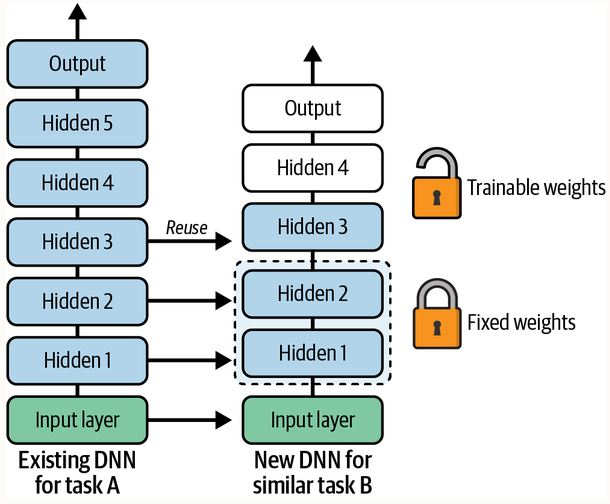

- The upper hidden layers of the original model are less likely to be as useful as the lower layers, since the high-level features that are most useful for the new task may differ significantly from the ones that were most useful for the original task. You want to find the right number of layers to reuse.

- If the input pictures for your new task don’t have the same size as the ones used in the original task, you will usually have to add a preprocessing step to resize them to the size expected by the original model. More generally, transfer learning will work best when the inputs have similar low-level features.

- Try freezing all the reused layers first (i.e., make their weights non-trainable so that gradient descent won’t modify them and they will remain fixed), then train your model and see how it performs. Then try unfreezing one or two of the top hidden layers to let backpropagation tweak them and see if performance improves.

- The more training data you have, the more layers you can unfreeze. It is also useful to reduce the learning rate when you unfreeze reused layers: this will avoid wrecking their fine-tuned weights.

- If you still cannot get good performance, and you have little training data, try dropping the top hidden layer(s) and freezing all the remaining hidden layers again. You can iterate until you find the right number of layers to reuse. If you have plenty of training data, you may try replacing the top hidden layers instead of dropping them, and even adding more hidden layers.

- `tf.keras.models.clone_model()` only clones the architecture, not the weights. If you don’t copy them manually using `set_weights()`, they will be initialized randomly when the cloned model is first used.

- You must always compile your model after you freeze or unfreeze layers.

- After unfreezing the reused layers, it is usually a good idea to reduce the learning rate, once again to avoid damaging the reused weights.


### Unsupervised Pretraining:

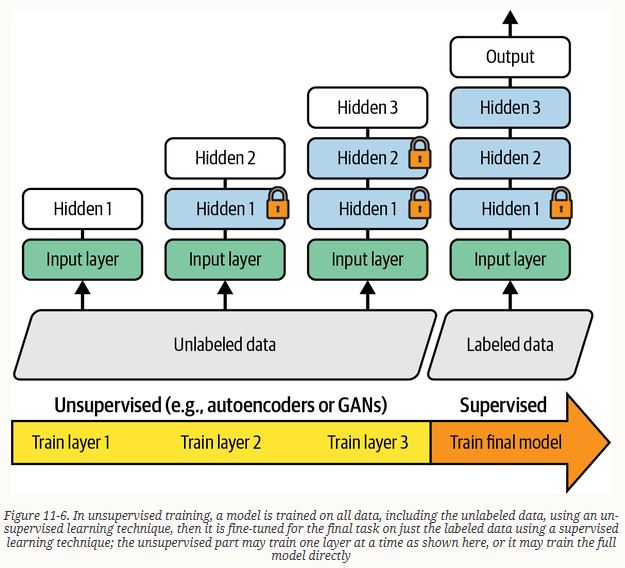

### Pretraining on an Auxiliary Task:

- If you do not have much labeled training data, one last option is to train a first neural network on an auxiliary task for which you can easily obtain or generate labeled training data, then reuse the lower layers of that network for your actual task. The first neural network’s lower layers will learn feature detectors that will likely be reusable by the second neural network.

- For natural language processing (NLP) applications, you can download a corpus of millions of text documents and automatically generate labeled data from it. For example, you could randomly mask out some words and train a model to predict what the missing words are (e.g., it should predict that the missing word in the sentence “What ___ you saying?” is probably “are” or “were”). If you can train a model to reach good performance on this task, then it will already know quite a lot about language, and you can certainly reuse it for your actual task and fine-tune it on your labeled data

## Fast Optimizers:

### Momentum:

- SVD does not care about what the earlier gradients were. If the local gradient is tiny, it goes very slowly. Momentum optimization cares a great deal about what previous gradients were: at each iteration, it subtracts the local gradient from the momentum vector m (multiplied by the learning rate η), and it updates the weights by adding this momentum vector. In other words, the gradient is used as an acceleration, not as a speed. To simulate some sort of friction mechanism and prevent the momentum from growing too large, the algorithm introduces a new hyperparameter β, called the momentum, which must be set between 0 (high friction) and 1 (no friction). A typical momentum value is 0.9.



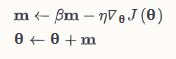

- It computes the exponential moving sum where each past gradient value is given the weight of $(momentum)^n$ where $n$ indicate how past the value is. Larger the momentum value, more will be weight given to past gradients and hence longer history is considered. About 1/(1 - momentum) past values have non-negligible weights.

- This allows momentum optimization to escape from plateaus much faster than gradient descent.

- When the inputs have very different scales, the cost function will look like an elongated bowl. Gradient descent goes down the steep slope quite fast, but then it takes a very long time to go down the valley. In contrast, momentum optimization will roll down the valley faster and faster until it reaches the bottom (the optimum). In deep neural networks that don’t use batch normalization, the upper layers will often end up having inputs with very different scales, so using momentum optimization helps a lot. It can also help roll past local optima.

### NAG/Nesterov momentum:



- It is almost always faster than regular momentum optimization
- It measures the gradient of the cost function not at the local position θ but slightly ahead in the direction of the momentum, at θ + βm


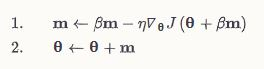

- This small tweak works because in general the momentum vector will be pointing in the right direction (i.e., toward the optimum), so it will be slightly more accurate to use the gradient measured a bit farther in that direction rather than the gradient at the original position

### AdaGrad:

- Consider the elongated bowl problem again: gradient descent starts by quickly going down the steepest slope, which does not point straight toward the global optimum, then it very slowly goes down to the bottom of the valley. It would be nice if the algorithm could correct its direction earlier to point a bit more toward the global optimum. The AdaGrad algorithm achieves this correction by scaling down the gradient vector along the steepest dimensions.


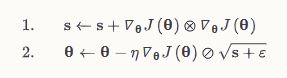

- The first step accumulates the square of the gradients into the vector s and the second step scales the learning rate by square root of s.
- In short, this algorithm decays the learning rate, but it does so faster for steep dimensions than for dimensions with gentler slopes. This is called an *adaptive learning rate*. It helps point the resulting updates more directly toward the global optimum. One additional benefit is that it requires much less tuning of the learning rate hyperparameter η.


- AdaGrad frequently performs well for simple quadratic problems, but it often stops too early when training neural networks: the learning rate gets scaled down so much that the algorithm ends up stopping entirely before reaching the global optimum. So never use it. Instead use:

### RMSProp:

- As we’ve seen, AdaGrad runs the risk of slowing down a bit too fast and never converging to the global optimum. The RMSProp algorithm⁠18 fixes this by accumulating only the gradients from the most recent iterations, as opposed to all the gradients since the beginning of training. It does so by using exponential decay (default=0.9) in the first step.


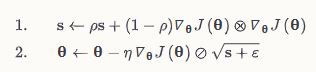

- It almost always performs much better than AdaGrad.

### Adam:

- Better adaptive learning rate algorithm than AdaGrad and RMSProp.
- Adam which stands for adaptive moment estimation, combines the ideas of momentum optimization and RMSProp: just like momentum optimization, it keeps track of an exponentially decaying average of past gradients; and just like RMSProp, it keeps track of an exponentially decaying average of past squared gradients. These are estimations of the mean and (uncentered) variance of the gradients. The mean is often called the first moment while the variance is often called the second moment.

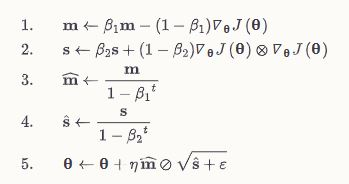

- Steps 3 and 4 are somewhat of a technical detail: since m and s are initialized at 0, they will be biased toward 0 at the beginning of training, so these two steps will help boost m and s at the beginning of training.
- The momentum decay hyperparameter β1 is typically initialized to 0.9, while the scaling decay hyperparameter β2 is often initialized to 0.999. As earlier, the smoothing term ε is usually initialized to a tiny number such as 10–7.
- Since Adam is an adaptive learning rate algorithm, like AdaGrad and RMSProp, it requires less tuning of the learning rate hyperparameter η. You can often use the default value η = 0.001, making Adam even easier to use than gradient descent

### AdaMax:

- Sometimes more stable than Adam but generaly not better.
- if we ignore ε and steps 3 and 4, Adam scales down the parameter updates by the square root of s. In short, Adam scales down the parameter updates by the ℓ2 norm of the time-decayed gradients (recall that the ℓ2 norm is the square root of the sum of squares).
- AdaMax replaces the ℓ2 norm with the ℓ∞ norm (a fancy way of saying the max)


### Nadam:

- Nadam optimization is Adam optimization plus the Nesterov trick, so it will often converge slightly faster than Adam.

### AdamW:

- AdamW is a variant of Adam that integrates a regularization technique called weight decay.
- Weight decay reduces the size of the model’s weights at each training iteration by multiplying them by a decay factor such as 0.99. This may remind you of ℓ2 regularization, which also aims to keep the weights small, and indeed it can be shown mathematically that ℓ2 regularization is equivalent to weight decay when using SGD.
- However, when using Adam or its variants, ℓ2 regularization and weight decay are not equivalent: in practice, combining Adam with ℓ2 regularization results in models that often don’t generalize as well as those produced by SGD. AdamW fixes this issue by properly combining Adam with weight decay.

### Summary:

*Adaptive optimization methods (including RMSProp, Adam, AdaMax, Nadam, and AdamW optimization) are often great, converging fast to a good solution. However, they can lead to solutions that generalize poorly on some datasets. So when you are disappointed by your model’s performance, try using NAG instead: your dataset may just be allergic to adaptive gradients.*

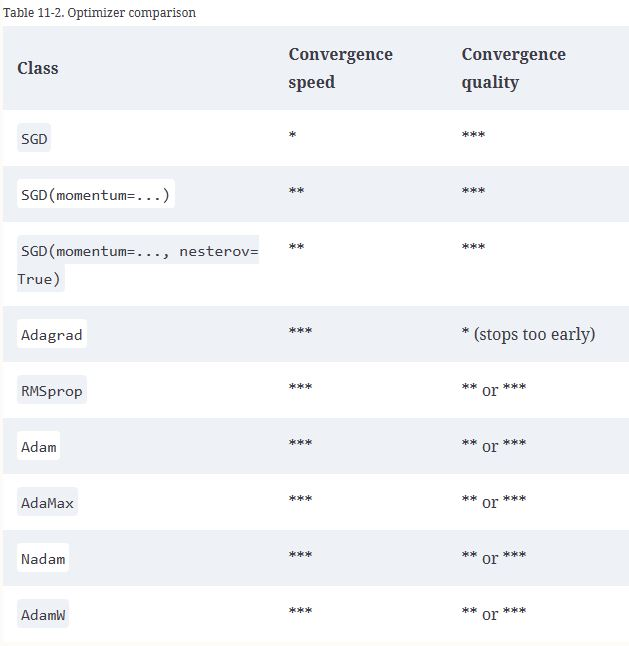

## Training sparse models

All the optimization algorithms we just discussed produce dense models, meaning that most parameters will be nonzero. If you need a blazingly fast model at runtime, or if you need it to take up less memory, you may prefer to end up with a sparse model instead.

One way to achieve this is to train the model as usual, then get rid of the tiny weights (set them to zero). However, this will typically not lead to a very sparse model, and it may degrade the model’s performance.

A better option is to apply strong ℓ1 regularization during training, as it pushes the optimizer to zero out as many weights as it can (as in “Lasso Regression”).

If these techniques remain insufficient, check out the TensorFlow Model Optimization Toolkit (TF-MOT), which provides a pruning API capable of iteratively removing connections during training based on their magnitude.

## Learning Rate Scheduling

### Power Scheduling:

```python
earning_rate = initial_learning_rate / (1 + decay_rate * step / decay_steps)
```

- The learning rate first drops quickly and then more and more slowly.
- Use `tf.keras.optimizers.schedules.InverseTimeDecay`

### Exponential scheduling:
```python
learning_rate = initial_learning_rate * decay_rate ** (step / decay_steps)
```

- The learning rate drops very fast by the factor of `decay_rate` every `decay_steps` steps
- Use `tf.keras.optimizers.schedules.ExponentialDecay`

### Piecewise constant scheduling:
- Using constant learning rate which is different for different ranges of epochs.
- Use `tf.keras.optimizers.schedules.PiecewiseConstantDecay`

### Performance scheduling:
- Reduces the learning rate by factor of λ if validation error does not drops for N steps.
- Use `ReduceLROnPlateau` callback

### 1cycle scheduling:
- Increase the learning rate linearly to max learning rate during about half of training, then reduce it linearly back to the initial learning rate, and lastly reduce it down to close to zero linearly for the very last part of training.
- On CIFAR10 dataset, this approach reached 91.9% accuracy in just 100 epochs, compared to 90.3% accuracy in 800 epochs through standard approach.

- Use custom callback.

Exponential scheduling and Performance scheduling are recommended. But 1cycle scheduling seems to perform even better.



## Avoiding Overfitting through regularization

### Early Stopping

### Batch Normalization

### l1 and l2 regularization:

- Use `l1()`, `l2()` or `l1_l2()` from `tf.keras.regularizers`.
- l2 is fine with SGD, momentum optimization and nesterov momentum optimization, but not with Adam and its variants. If you want to use Adam with weight decay, then do not use l2 regularization: use AdamW instead.

### Dropout:
- At every training step, every neuron (including the input neurons, but always excluding the output neurons) has a probability p of being temporarily "dropped out", meaning it will be entirely ignored during this training step, but it may be active during the next step. The hyperparameter p is called the dropout rate, and it is typically set between 10% and 50%: closer to 20%-30% in recurrent neural nets, and closer to 40%-50% in convolutional neural networks. After training, neurons don't get dropped anymore

- Neurons trained with dropout cannot co-adapt with their neighboring neurons; they have to be as useful as possible on their own. They also cannot rely excessively on just a few input neurons; they must pay attention to each of their input neurons. They end up being less sensitive to slight changes in the inputs. In the end, you get a more robust net- work that generalizes better.

- Suppose p = 75%: on average only 25% of all neurons are active at each step during training. This means that after training, a neuron would be connected to four times as many input neurons as it would be during training. To compensate for this fact, we need to multiply each neuron's input connection weights by four during training. If we don't, the neural network will not perform well as it will see different data during and after training. More generally, we need to divide the connection weights by the keep probability (1 - p) during training.

- Since dropout is only active during training, comparing the training loss and the validation loss can be misleading. In particular, a model may be overfitting the training set and yet have similar training and validation losses. So, make sure to evaluate the training loss without dropout (e.g., after training).

- Many state-of-the-art architectures only use dropout after the last hidden layer, so you may want to try this if full dropout is too strong.

- Dropout does tend to significantly slow down convergence, but it often results in a better model when tuned properly. So, it is generally well worth the extra time and effort, especially for large models.

- If you want to regularize a self-normalizing network based on the SELU activation function, you should use alpha dropout: this is a variant of dropout that pre- serves the mean and standard deviation of its inputs. It was introduced in the same paper as SELU, as regular dropout would break self-normalization.



### MC dropout:

- MC dropout can boost the performance of any trained dropout model without having to retrain it or even modify it at all. It also provides a much better measure of the model's uncertainty, and it can be implemented in just a few lines of code.

- ```python
N = 100
y_probas = np.stack([model(X_test, training=True) for sample in range(N)])
# y_probas size = [N, B, C]
y_proba = y_probas.mean(axis=0)
y_proba_std = y_probas.std(axis=0)
```

- Averaging over multiple predictions with dropout turned on gives us Monte Carlo estimate that is more reliable than result of single prediction with dropout turned off.
- The number of Monte Carlo samples you use (100 in this example) is a hyperparameter you can tweak. The higher it is, the more accurate the predictions and their uncertainty estimates will be. However, if you double it, inference time will also be doubled.

- If your model contains other layers that behave in a special way during training (such as BatchNormalization layers), then you should not force training mode like we just did. Instead, you should replace the Dropout layers with the following MCDropout class:
```python
class MCDropout (tf.keras.layers.Dropout):
    def call(self, inputs, training=False):
        return super().call(inputs, training=True)
```


### Max-Norm regularization:

- For each neuron, it constrains the weights w of the incoming con- nections such that || w ||^2 ≤r, where r is the max-norm hyperparameter and || - ||^2 is the 12 norm.

- Max-norm regularization does not add a regularization loss term to the overall loss function. Instead, it is typically implemented by computing || w ||^2 after each training step and rescaling w if needed (w <-- wr / || w ||^2).
- Reducing r increases the amount of regularization and helps reduce overfitting. Max-norm regularization can also help alleviate the unstable gradients problems (if you are not using batch normalization).
- To implement max-norm regularization in Keras, set the `kernel_constraint` argument of each hidden layer to a `max_norm()` constraint with the appropriate max value.
- The max_norm() function has an axis argument that defaults to 0. A Dense
layer usually has weights of shape [number of inputs, number of neurons], so using axis=0 means that the max-norm constraint will apply independently to each neuron's weight vector.

## Summary:

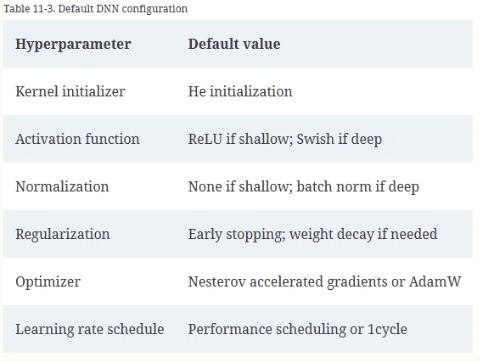

For self-normalizing DNN net:

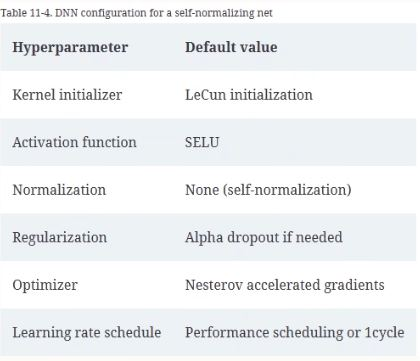

If you need a low-latency model (one that performs lightning-fast predic- tions), you may need to use fewer layers, use a fast activation function such as ReLU or leaky ReLU, and fold the batch normalization layers into the previous layers after training. Having a sparse model (by using l1 regularization) will also help. Finally, you may want to reduce the float precision from 32 bits to 16 or even 8 bits. Check *Tensorflow Model Optimization*.

# Custom Models and Training:

- `tf.Constant` (tf.tensor) is immutable supporting many functions like numpy.
- `tf.Varaible` is mutable supporting in-place modifications using assign, assign_add etc.
- `Model.save()` saves the `model.loss`, `model.optimizer` etc configuration using their `get_config()` method which returns directory of params. When loading the model, the same object is created using their class `from_config()` method.
- Pass the custom models used while loading the model
```python
class HuberLoss(tf.keras.losses.Loss):
    def __init__(self, threshold=1.0, **kwargs):
        self.threshold = threshold
        super().__init__(**kwargs)

    def call(self, y_true, y_pred):
        error = y_true - y_pred
        is_small_error = tf.abs(error) < self.threshold
        squared_loss = tf.square(error) / 2
        linear_loss  = self.threshold * tf.abs(error) - self.threshold**2 / 2
        return tf.where(is_small_error, squared_loss, linear_loss)

    def get_config(self):
        base_config = super().get_config()
        return base_config | {"threshold": self.threshold}

    model.compile(loss=HuberLoss(2.), optimizer="nadam", metrics=["mae"])
    model.save("my_model_with_a_custom_loss_class")
    model = tf.keras.models.load_model("my_model_with_a_custom_loss_class",
                                   custom_objects={"HuberLoss": HuberLoss})
```

- Alternative to `custom_objects`, `@tf.keras.utils.register_keras_serializable(package='Custom', name=)` can be used.
- Regularizers, Initializers and Constraints Base Classes don't have `call()`. Also they don't have `get_config` method.

- Metric Base class can be used for *streaming metric* like other available metrics. It does not have `call` method. In its `__call__`, `update_state` is first called to update variables e.g. total false postives and true negatives since the start of epoch, then `result` method is called to output metric e.g. running precision instead of average of precision across all the batches.

- ```python
    class HuberMetric(tf.keras.metrics.Metric):
    def __init__(self, threshold=1.0, **kwargs):
        super().__init__(**kwargs)  # handles base args (e.g., dtype)
        self.threshold = threshold
        self.huber_fn = create_huber(threshold)
        self.total = self.add_weight("total", initializer="zeros")
        self.count = self.add_weight("count", initializer="zeros")

    def update_state(self, y_true, y_pred, sample_weight=None):
        sample_metrics = self.huber_fn(y_true, y_pred)
        self.total.assign_add(tf.reduce_sum(sample_metrics))
        self.count.assign_add(tf.cast(tf.size(y_true), tf.float32))

    def result(self):
        return self.total / self.count

    def get_config(self):
        base_config = super().get_config()
        return {**base_config, "threshold": self.threshold}
```



- For simple custom layers having no weights, use `tf.keras.layers.Lambda`
- ```python
class MyDense(tf.keras.layers.Layer):
    def __init__(self, units, activation=None, **kwargs):
        super().__init__(**kwargs)
        self.units = units
        self.activation = tf.keras.activations.get(activation)

    def build(self, batch_input_shape):
        self.kernel = self.add_weight(
            name="kernel", shape=[batch_input_shape[-1], self.units],
            initializer="he_normal")
        self.bias = self.add_weight(
            name="bias", shape=[self.units], initializer="zeros")

    def call(self, X):
        return self.activation(X @ self.kernel + self.bias)

    def get_config(self):
        base_config = super().get_config()
        return {**base_config, "units": self.units,
                "activation": tf.keras.activations.serialize(self.activation)}
```
- `__call__` method will `build` and then `call`. `call` will include `training=None` parameter to distingusih training and inference when using Dropout of BN. `call` can have multiple inputs and multiple outputs.
- State variables of layer can also be defined in `__init__` method instead.

- Overriding `get_config` is usually not important for Layer and its subclasses. The default will already include the important parameters to reinstantiate the object.
- You can save and load the model without specifying the custom object for layer.
- `Model` is a subclass of `Layer` containing extra functionality of methods:
`get_layer`, `fit`, `compile`, `evaluate`, `predict`, `save`, `load_model` and `clone_model`, `save_weights`, `load_weights` etc.

- ```python
    class ResidualBlock(tf.keras.layers.Layer):
        def __init__(self, n_layers, n_neurons, **kwargs):
            super().__init__(**kwargs)
            self.hidden = [tf.keras.layers.Dense(n_neurons, activation="relu",
                                                kernel_initializer="he_normal")
                        for _ in range(n_layers)]

        def call(self, inputs):
            Z = inputs
            for layer in self.hidden:
                Z = layer(Z)
            return inputs + Z

    class ResidualRegressor(tf.keras.Model):
        def __init__(self, output_dim, **kwargs):
            super().__init__(**kwargs)
            self.hidden1 = tf.keras.layers.Dense(30, activation="relu",
                                                kernel_initializer="he_normal")
            self.block1 = ResidualBlock(2, 30)
            self.block2 = ResidualBlock(2, 30)
            self.out = tf.keras.layers.Dense(output_dim)

        def call(self, inputs):
            Z = self.hidden1(inputs)
            for _ in range(1 + 3):
                Z = self.block1(Z)
            Z = self.block2(Z)
            return self.out(Z)

    tf.keras.utils.set_random_seed(42)
    model = ResidualRegressor(1)
    model.compile(loss="mse", optimizer="nadam")
    history = model.fit(X_train_scaled, y_train, epochs=2)
    score = model.evaluate(X_test_scaled, y_test)
    model.save("my_custom_model")

    model = tf.keras.models.load_model("my_custom_model")
    history = model.fit(X_train_scaled, y_train, epochs=2)
    model.predict(X_test_scaled[:3])
```

- We can add loses and metrics based on model internels using `add_loss` and `add_metric`. For example adding reconstruction error from auxiliary output, which acts as regularization cost along with custom metric:

    ```python
    class ReconstructingRegressor(tf.keras.Model):
    def __init__(self, output_dim, **kwargs):
        super().__init__(**kwargs)
        self.hidden = [tf.keras.layers.Dense(30, activation="relu",
                                             kernel_initializer="he_normal")
                       for _ in range(5)]
        self.out = tf.keras.layers.Dense(output_dim)

    def build(self, batch_input_shape):
        n_inputs = batch_input_shape[-1]
        self.reconstruct = tf.keras.layers.Dense(n_inputs)

    def call(self, inputs, training=None):
        Z = inputs
        for layer in self.hidden:
            Z = layer(Z)
        reconstruction = self.reconstruct(Z)
        recon_loss = tf.reduce_mean(tf.square(reconstruction - inputs))
        self.add_loss(0.05 * recon_loss)
        if training:
            self.add_metric(recon_loss, name="rc_loss")
            # Or use streaming metric, first initialized as attribute of self
        return self.out(Z)
    ```

- Using reverse-mode autodiff, we can find the gradient of $f(w_1, w_2)$ with respect to each parameter $w$ in one reverse pass. This is much efficient then computing gradient for each parameter individualy using, for example, $[f(w_1+δ, w_2)-f(w_1, w_2)]/ δ$ for $w_1$.



In [ ]:
import tensorflow as tf
def f(w1, w2):
    return 3 * w1 ** 2 + 2 * w1 * w2

In [ ]:
w1, w2 = tf.Variable(5.), tf.Variable(3.)
with tf.GradientTape() as tape:
    z = f(w1, w2)

gradients = tape.gradient(z, [w1, w2])
gradients

[<tf.Tensor: shape=(), dtype=float32, numpy=36.0>,
 <tf.Tensor: shape=(), dtype=float32, numpy=10.0>]

- In order to save memory, only put the strict minimum inside the `tf.GradientTape()` block. Alternatively, pause recording by creating a with `tape.stop_recording()` block inside the `tf.GradientTape()` block.

- The tape is automatically erased immediately after you call its `gradient()` method, so you will get an exception if you try to call `gradient()` twice. In order to use `gradient()` more than once, use persistant and delete tape once done to free resources:

In [ ]:
with tf.GradientTape(persistent=True) as tape:
    z = f(w1, w2)

dz_dw1 = tape.gradient(z, w1)  # returns tensor 36.0
dz_dw2 = tape.gradient(z, w2)  # returns tensor 10.0, works fine now!
del tape

- If you want to track Tensor then you need to watch it:

In [ ]:
c1, c2 = tf.constant(5.), tf.constant(3.)
with tf.GradientTape() as tape:
    tape.watch(c1)
    tape.watch(c2)
    z = f(c1, c2)

gradients = tape.gradient(z, [c1, c2])
gradients

[<tf.Tensor: shape=(), dtype=float32, numpy=36.0>,
 <tf.Tensor: shape=(), dtype=float32, numpy=10.0>]

- This can be useful in some cases, like if you want to implement a regularization loss that penalizes activations that vary a lot when the inputs vary little: the loss will be based on the gradient of the activations with regard to the inputs. Since the inputs are not variables, you'll need to tell the tape to watch them.

- You can find the first partial derivative (jacobian) and second partial derivative (hessian):

In [ ]:
with tf.GradientTape(persistent=True) as hessian_tape:
    with tf.GradientTape() as jacobian_tape:
        z = f(w1, w2)
    jacobians = jacobian_tape.gradient(z, [w1, w2])
hessians = [hessian_tape.gradient(jacobian, [w1, w2])
            for jacobian in jacobians]
del hessian_tape

In [ ]:
jacobians

[<tf.Tensor: shape=(), dtype=float32, numpy=36.0>,
 <tf.Tensor: shape=(), dtype=float32, numpy=10.0>]

In [ ]:
hessians

[[<tf.Tensor: shape=(), dtype=float32, numpy=6.0>,
  <tf.Tensor: shape=(), dtype=float32, numpy=2.0>],
 [<tf.Tensor: shape=(), dtype=float32, numpy=2.0>, None]]

In some cases you may want to stop gradients from backpropagating through some part of your neural network. To do this, you must use the
`tf.stop_gradient()` function. The function returns its inputs during the forward pass (like `tf.identity()`), but it does not let gradients through during backpropagation (it acts like a constant):

In [ ]:
def f(w1, w2):
    return 3 * w1 ** 2 + tf.stop_gradient(2 * w1 * w2)

with tf.GradientTape() as tape:
    z = f(w1, w2)  # same result as without stop_gradient()

gradients = tape.gradient(z, [w1, w2])

In [ ]:
gradients

[<tf.Tensor: shape=(), dtype=float32, numpy=30.0>, None]

The exponential function is also a frequent source of headaches, as it grows extremely fast. For very large number or number with many float values, number will be `inf` as it does not fit in 32 bits. For example, the `softplus()` will output `inf` rather than 100.0 at 100.0.

In [ ]:
def softplus(z):
    return tf.math.log(tf.exp(tf.constant(z, dtype=tf.float32)) + 1.)

softplus(100.)

<tf.Tensor: shape=(), dtype=float32, numpy=inf>

You can rewrite the function to make it numerically stable:

In [ ]:
def softplus(z):
    return tf.math.log(1 + tf.exp(-tf.abs(z))) + tf.maximum(0., z)

softplus(100.)

<tf.Tensor: shape=(), dtype=float32, numpy=100.0>

In some rare cases, a numerically stable function may still have numerically unstable gradients. In such cases, you will have to tell TensorFlow which equation to use for the gradients, rather than letting it use autodiff. For this, you must use the `@tf.custom_gradient` decorator when defining the function, and return both the function's usual result and a function that computes the gradients. For example, let's update the `softplus()` function to also return a numerically stable gradients function:

In [ ]:
@tf.custom_gradient
def my_softplus(z):
    def my_softplus_gradients(grads):  # grads = backprop'ed from upper layers
        return grads * (1 - 1 / (1 + tf.exp(z)))  # stable grads of softplus

    result = tf.math.log(1 + tf.exp(-tf.abs(z))) + tf.maximum(0., z)
    return result, my_softplus_gradients

Note that this function will receive as input the gradients that were backpropagated so far, down to the `softplus()` function, and according to the chain rule we must multiply them with this function's gradients.

In [ ]:
x = tf.Variable([1000.])
with tf.GradientTape() as tape:
    z = my_softplus(x)

z, tape.gradient(z, [x])

(<tf.Tensor: shape=(1,), dtype=float32, numpy=array([1000.], dtype=float32)>,
 [<tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>])

- Custom training loop:

In [ ]:
from tqdm.notebook import trange
from collections import OrderedDict
import numpy as np
import tensorflow as tf

In [ ]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

housing = fetch_california_housing()
X_train_full, X_test, y_train_full, y_test = train_test_split(
    housing.data, housing.target.reshape(-1, 1), random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_full, y_train_full, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)
X_test_scaled = scaler.transform(X_test)

In [ ]:
tf.keras.utils.set_random_seed(42)
l2_reg = tf.keras.regularizers.l2(0.05)
max_norm = tf.keras.constraints.max_norm(2)

model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(30, activation="relu", kernel_initializer="he_normal",
                          kernel_regularizer=l2_reg, kernel_constraint=max_norm),
    tf.keras.layers.Dense(1, kernel_regularizer=l2_reg)
])

In [ ]:
n_epochs = 5
batch_size = 32
n_steps = len(X_train) // batch_size
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)
loss_fn = tf.keras.losses.mean_squared_error
mean_loss = tf.keras.metrics.Mean()
metrics = [tf.keras.metrics.MeanAbsoluteError()]

def random_batch(X, y, batch_size=32):
    idx = np.random.randint(len(X), size=batch_size)
    return X[idx], y[idx]

In [ ]:
from tqdm.notebook import trange
from collections import OrderedDict
with trange(1, n_epochs + 1, desc="All epochs") as epochs:
    for epoch in epochs:
        with trange(1, n_steps + 1, desc=f"Epoch {epoch}/{n_epochs}") as steps:
            for step in steps:
                X_batch, y_batch = random_batch(X_train_scaled, y_train)
                with tf.GradientTape() as tape:
                    y_pred = model(X_batch)
                    main_loss = tf.reduce_mean(loss_fn(y_batch, y_pred))
                    loss = tf.add_n([main_loss] + model.losses)
                    # model.losses is list containing regularization cost for each layer

                gradients = tape.gradient(loss, model.trainable_variables)
                optimizer.apply_gradients(zip(gradients, model.trainable_variables))

                # Applying constraints
                for variable in model.variables:
                    if variable.constraint is not None:
                        variable.assign(variable.constraint(variable))

                status = OrderedDict()
                mean_loss(loss)
                status["loss"] = mean_loss.result().numpy()
                for metric in metrics:
                    metric(y_batch, y_pred)
                    status[metric.name] = metric.result().numpy()

                steps.set_postfix(status)

        for metric in [mean_loss] + metrics:
            metric.reset_states()

All epochs:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1/5:   0%|          | 0/362 [00:00<?, ?it/s]

Epoch 2/5:   0%|          | 0/362 [00:00<?, ?it/s]

Epoch 3/5:   0%|          | 0/362 [00:00<?, ?it/s]

Epoch 4/5:   0%|          | 0/362 [00:00<?, ?it/s]

Epoch 5/5:   0%|          | 0/362 [00:00<?, ?it/s]

- Creating a dynamic Keras model can be useful for debugging, as it will not compile any custom component to a TF Function, and you can use any Python debugger to debug your code. It can also be useful if you want to include arbitrary Python code in your model (or in your training code), including calls to external libraries which are not TF operations and hence only executed once during tracing and not included in graph as node. To make a model dynamic, you must set `dynamic=True` when creating it. Alternatively, you can set `run_eagerly=True` when calling the model's `compile()` method. Making a model dynamic prevents Keras from using any of TensorFlow's graph features, so it will slow down training and inference, and you will not have the possibility to export the computation graph, which will limit your model's portability.

# Data loading and preprocessing

## tf.data API

In [ ]:
import tensorflow as tf

- tf.data is streaming API: you can iterate through dataset's items but not index or slice.

In [ ]:
dataset = tf.data.Dataset.from_tensor_slices(tf.range(10)) # slice along first dimension
# Alternatively use tf.data.Dataset.range(10) for same result but with dtype=int64
for i in dataset:
    print(i)

tf.Tensor(0, shape=(), dtype=int32)
tf.Tensor(1, shape=(), dtype=int32)
tf.Tensor(2, shape=(), dtype=int32)
tf.Tensor(3, shape=(), dtype=int32)
tf.Tensor(4, shape=(), dtype=int32)
tf.Tensor(5, shape=(), dtype=int32)
tf.Tensor(6, shape=(), dtype=int32)
tf.Tensor(7, shape=(), dtype=int32)
tf.Tensor(8, shape=(), dtype=int32)
tf.Tensor(9, shape=(), dtype=int32)


In [ ]:
# It slices such that structure remains same
X_nested = {"a": ([1, 2, 3], [4, 5, 6]), "b": [7, 8, 9]}
dataset = tf.data.Dataset.from_tensor_slices(X_nested)
for item in dataset:
    print(item)

{'a': (<tf.Tensor: shape=(), dtype=int32, numpy=1>, <tf.Tensor: shape=(), dtype=int32, numpy=4>), 'b': <tf.Tensor: shape=(), dtype=int32, numpy=7>}
{'a': (<tf.Tensor: shape=(), dtype=int32, numpy=2>, <tf.Tensor: shape=(), dtype=int32, numpy=5>), 'b': <tf.Tensor: shape=(), dtype=int32, numpy=8>}
{'a': (<tf.Tensor: shape=(), dtype=int32, numpy=3>, <tf.Tensor: shape=(), dtype=int32, numpy=6>), 'b': <tf.Tensor: shape=(), dtype=int32, numpy=9>}


## Chaining transformations:

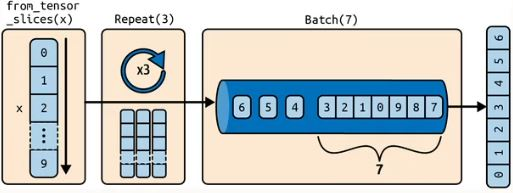

- Repeat data for n times without copying it in memory n times. Without any agument to `repeat()`, dataset is repeated infinite times.

In [ ]:
dataset = tf.data.Dataset.from_tensor_slices(tf.range(10))
dataset = dataset.repeat(3)
for i in dataset.take(20): # .take() is like .head()
    print(i)

tf.Tensor(0, shape=(), dtype=int32)
tf.Tensor(1, shape=(), dtype=int32)
tf.Tensor(2, shape=(), dtype=int32)
tf.Tensor(3, shape=(), dtype=int32)
tf.Tensor(4, shape=(), dtype=int32)
tf.Tensor(5, shape=(), dtype=int32)
tf.Tensor(6, shape=(), dtype=int32)
tf.Tensor(7, shape=(), dtype=int32)
tf.Tensor(8, shape=(), dtype=int32)
tf.Tensor(9, shape=(), dtype=int32)
tf.Tensor(0, shape=(), dtype=int32)
tf.Tensor(1, shape=(), dtype=int32)
tf.Tensor(2, shape=(), dtype=int32)
tf.Tensor(3, shape=(), dtype=int32)
tf.Tensor(4, shape=(), dtype=int32)
tf.Tensor(5, shape=(), dtype=int32)
tf.Tensor(6, shape=(), dtype=int32)
tf.Tensor(7, shape=(), dtype=int32)
tf.Tensor(8, shape=(), dtype=int32)
tf.Tensor(9, shape=(), dtype=int32)


In [ ]:
dataset = tf.data.Dataset.from_tensor_slices(tf.range(10))
dataset = dataset.repeat(3).batch(7)
# use drop_remainder=True in batch() in order to drop remaining
for item in dataset:
    print(item)

tf.Tensor([0 1 2 3 4 5 6], shape=(7,), dtype=int32)
tf.Tensor([7 8 9 0 1 2 3], shape=(7,), dtype=int32)
tf.Tensor([4 5 6 7 8 9 0], shape=(7,), dtype=int32)
tf.Tensor([1 2 3 4 5 6 7], shape=(7,), dtype=int32)
tf.Tensor([8 9], shape=(2,), dtype=int32)


In [ ]:
dataset = dataset.map(lambda x: x * 2, num_parallel_calls=tf.data.AUTOTUNE)  # x is a batch
for item in dataset:
    print(item)

tf.Tensor([ 0  2  4  6  8 10 12], shape=(7,), dtype=int32)
tf.Tensor([14 16 18  0  2  4  6], shape=(7,), dtype=int32)
tf.Tensor([ 8 10 12 14 16 18  0], shape=(7,), dtype=int32)
tf.Tensor([ 2  4  6  8 10 12 14], shape=(7,), dtype=int32)
tf.Tensor([16 18], shape=(2,), dtype=int32)


In [ ]:
dataset = dataset.filter(lambda x: tf.reduce_sum(x) > 50)
for item in dataset:
    print(item)

tf.Tensor([14 16 18  0  2  4  6], shape=(7,), dtype=int32)
tf.Tensor([ 8 10 12 14 16 18  0], shape=(7,), dtype=int32)
tf.Tensor([ 2  4  6  8 10 12 14], shape=(7,), dtype=int32)


In [ ]:
# Combining all transformations:
dataset = tf.data.Dataset.from_tensor_slices(tf.range(10))
dataset = dataset.repeat(3).batch(7).map(lambda x: x * 2, num_parallel_calls=-1).filter(lambda y: tf.reduce_sum(y) > 50)
for i in dataset:
    print(i)

tf.Tensor([14 16 18  0  2  4  6], shape=(7,), dtype=int32)
tf.Tensor([ 8 10 12 14 16 18  0], shape=(7,), dtype=int32)
tf.Tensor([ 2  4  6  8 10 12 14], shape=(7,), dtype=int32)


## Shuffling

- `shuffle()` method will create a new dataset that will start by filling up a buffer with the first items of the source dataset. Then, whenever it is asked for an item, it will pull one out randomly from the buffer and replace it with a fresh one from the source dataset, until it has iterated entirely through the source dataset. At this point it will continue to pull out items randomly from the buffer until it is empty. You must specify the buffer size, and it is important to make it large enough, or else shuffling will not be very effective.Just don't exceed the amount of RAM you have, though even if you have plenty of it, there's no need to go beyond the dataset's size.

In [ ]:
dataset = tf.data.Dataset.range(10).repeat(2)
dataset = dataset.shuffle(buffer_size=4, seed=42)
for item in dataset:
    print(item)

tf.Tensor(1, shape=(), dtype=int64)
tf.Tensor(4, shape=(), dtype=int64)
tf.Tensor(2, shape=(), dtype=int64)
tf.Tensor(3, shape=(), dtype=int64)
tf.Tensor(5, shape=(), dtype=int64)
tf.Tensor(0, shape=(), dtype=int64)
tf.Tensor(6, shape=(), dtype=int64)
tf.Tensor(9, shape=(), dtype=int64)
tf.Tensor(8, shape=(), dtype=int64)
tf.Tensor(2, shape=(), dtype=int64)
tf.Tensor(0, shape=(), dtype=int64)
tf.Tensor(3, shape=(), dtype=int64)
tf.Tensor(1, shape=(), dtype=int64)
tf.Tensor(4, shape=(), dtype=int64)
tf.Tensor(5, shape=(), dtype=int64)
tf.Tensor(7, shape=(), dtype=int64)
tf.Tensor(9, shape=(), dtype=int64)
tf.Tensor(6, shape=(), dtype=int64)
tf.Tensor(7, shape=(), dtype=int64)
tf.Tensor(8, shape=(), dtype=int64)


- For a large dataset that does not fit in memory, this simple shuffling-buffer approach may not be sufficient, since the buffer will be small compared to the dataset. For example:

In [ ]:
dataset = tf.data.Dataset.from_tensor_slices([1,1,1,1,1,1,4,4,4,4,4,4])
dataset = dataset.shuffle(buffer_size=2, seed=42)
for item in dataset:
    print(item)

tf.Tensor(1, shape=(), dtype=int32)
tf.Tensor(1, shape=(), dtype=int32)
tf.Tensor(1, shape=(), dtype=int32)
tf.Tensor(1, shape=(), dtype=int32)
tf.Tensor(1, shape=(), dtype=int32)
tf.Tensor(1, shape=(), dtype=int32)
tf.Tensor(4, shape=(), dtype=int32)
tf.Tensor(4, shape=(), dtype=int32)
tf.Tensor(4, shape=(), dtype=int32)
tf.Tensor(4, shape=(), dtype=int32)
tf.Tensor(4, shape=(), dtype=int32)
tf.Tensor(4, shape=(), dtype=int32)


- For large datasets, a common approach is to split the source data into multiple files, then read them in a random order during training. However, instances located in the same file will still end up close to each other. To avoid this you can pick multiple files randomly and read them simultaneously, **interleaving** their records:

In [ ]:
# let's start by splitting the housing dataset and saving it to 20 CSV files:
import numpy as np
import os
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split

housing = fetch_california_housing()
data = np.c_[housing.data, housing.target]
header_cols = housing.feature_names + ["MedianHouseValue"]
header = ",".join(header_cols)

data_train, data_temp = train_test_split(data, random_state=42, test_size=0.3)
data_valid, data_test = train_test_split(data_temp, random_state=42, test_size=0.5)
data_train.shape, data_valid.shape, data_test.shape

((14448, 9), (3096, 9), (3096, 9))

In [ ]:
def save_to_csv_files(data, name, n_parts=10, header=None):
    dir = os.path.join("housing", name)
    os.makedirs(dir, exist_ok=True)
    filepaths = []
    for file_num, chunk in enumerate(np.array_split(data, n_parts)):
        filename = f"{name}_{file_num}.csv"
        filepath = os.path.join(dir, filename)
        filepaths.append(filepath)
        with open(filepath, "w") as f:
            if header is not None:
                f.write(header)
                f.write("\n")
            for row in chunk:
                f.write(",".join(map(str, row)))
                f.write("\n")
    return filepaths

train_filepaths = save_to_csv_files(data_train, "train", n_parts=20, header=header)
valid_filepaths = save_to_csv_files(data_train, "valid", n_parts=10, header=header)
test_filepaths = save_to_csv_files(data_train, "test", n_parts=10, header=header)

In [ ]:
train_filepaths

['housing/train/train_0.csv',
 'housing/train/train_1.csv',
 'housing/train/train_2.csv',
 'housing/train/train_3.csv',
 'housing/train/train_4.csv',
 'housing/train/train_5.csv',
 'housing/train/train_6.csv',
 'housing/train/train_7.csv',
 'housing/train/train_8.csv',
 'housing/train/train_9.csv',
 'housing/train/train_10.csv',
 'housing/train/train_11.csv',
 'housing/train/train_12.csv',
 'housing/train/train_13.csv',
 'housing/train/train_14.csv',
 'housing/train/train_15.csv',
 'housing/train/train_16.csv',
 'housing/train/train_17.csv',
 'housing/train/train_18.csv',
 'housing/train/train_19.csv']

In [ ]:
# Create ShuffleDataset of filepaths
filepath_dataset = tf.data.Dataset.list_files(train_filepaths, shuffle=True, seed=42)
for filepath in filepath_dataset:
    print(filepath)

tf.Tensor(b'housing/train/train_13.csv', shape=(), dtype=string)
tf.Tensor(b'housing/train/train_6.csv', shape=(), dtype=string)
tf.Tensor(b'housing/train/train_1.csv', shape=(), dtype=string)
tf.Tensor(b'housing/train/train_7.csv', shape=(), dtype=string)
tf.Tensor(b'housing/train/train_0.csv', shape=(), dtype=string)
tf.Tensor(b'housing/train/train_4.csv', shape=(), dtype=string)
tf.Tensor(b'housing/train/train_18.csv', shape=(), dtype=string)
tf.Tensor(b'housing/train/train_10.csv', shape=(), dtype=string)
tf.Tensor(b'housing/train/train_2.csv', shape=(), dtype=string)
tf.Tensor(b'housing/train/train_9.csv', shape=(), dtype=string)
tf.Tensor(b'housing/train/train_15.csv', shape=(), dtype=string)
tf.Tensor(b'housing/train/train_17.csv', shape=(), dtype=string)
tf.Tensor(b'housing/train/train_3.csv', shape=(), dtype=string)
tf.Tensor(b'housing/train/train_5.csv', shape=(), dtype=string)
tf.Tensor(b'housing/train/train_19.csv', shape=(), dtype=string)
tf.Tensor(b'housing/train/train_8.

In [ ]:
csv_data = tf.data.TextLineDataset(filepath_dataset)
for row in csv_data.take(5):
    print(row)

tf.Tensor(b'MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedianHouseValue', shape=(), dtype=string)
tf.Tensor(b'6.0224,38.0,5.1,1.2,41.0,4.1,33.8,-117.89,1.875', shape=(), dtype=string)
tf.Tensor(b'3.8108,23.0,5.4393162393162395,0.9623931623931624,1525.0,2.606837606837607,36.35,-119.64,0.904', shape=(), dtype=string)
tf.Tensor(b'3.125,42.0,4.012820512820513,0.9166666666666666,625.0,4.006410256410256,33.98,-118.22,1.663', shape=(), dtype=string)
tf.Tensor(b'3.1484,52.0,5.354748603351955,1.0251396648044693,722.0,2.016759776536313,38.57,-121.46,1.589', shape=(), dtype=string)


- `interleave` will apply `map_func` to `cycle_length` input elements, open iterators on the returned `Dataset` objects, and cycle through them producing `block_length` consecutive elements from each iterator, and consuming the next input element each time it reaches the end of an iterator.

In [ ]:
dataset = filepath_dataset.interleave(lambda filepath: tf.data.TextLineDataset(filepath),
                                      cycle_length=5, block_length=2, num_parallel_calls=tf.data.AUTOTUNE)
for row in dataset.take(13):
    print(row)

tf.Tensor(b'MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedianHouseValue', shape=(), dtype=string)
tf.Tensor(b'5.3146,33.0,5.201183431952662,1.0710059171597632,547.0,3.2366863905325443,33.92,-118.09,1.686', shape=(), dtype=string)
tf.Tensor(b'MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedianHouseValue', shape=(), dtype=string)
tf.Tensor(b'11.5706,36.0,7.68213058419244,1.0618556701030928,1315.0,2.259450171821306,37.87,-122.47,5.00001', shape=(), dtype=string)
tf.Tensor(b'MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedianHouseValue', shape=(), dtype=string)
tf.Tensor(b'2.5685,20.0,4.7950738916256155,1.0,1725.0,1.6995073891625616,38.41,-122.4,2.676', shape=(), dtype=string)
tf.Tensor(b'MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedianHouseValue', shape=(), dtype=string)
tf.Tensor(b'2.925,43.0,4.85655737704918,1.2131147540983607,933.0,3.8237704918032787,37.35,-121.89,1.

- It reads 2 rows from each 5 files, sequentially.

## Putting Everything Together + Prefetching

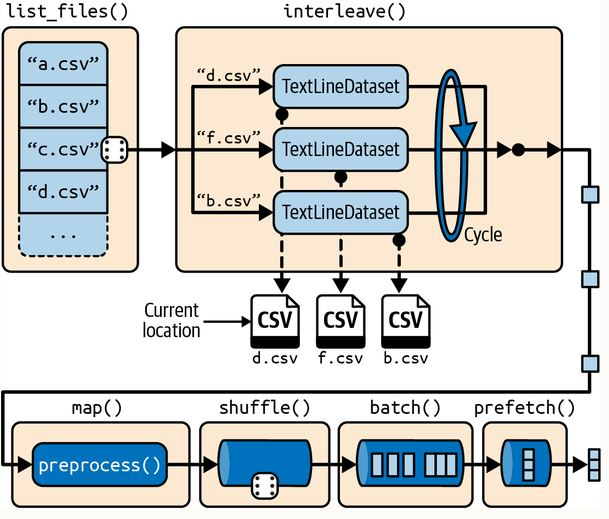

In [ ]:
n_inputs = 8
def preprocess(line):
    # Replace missing feature with 0 but give error on missing target
    defs = [tf.constant(0.)] * n_inputs + [tf.constant([])]
    fields = tf.io.decode_csv(line, record_defaults=defs)
    # Stacking 0d tensors into 1D tensor
    return tf.stack(fields[:-1]), tf.stack(fields[-1:])

In [ ]:
def csv_reader_dataset(filepaths, n_readers=5, n_read_threads=None,
                       n_parse_threads=5, shuffle_buffer_size=10_000, seed=42,
                       batch_size=32):
    dataset = tf.data.Dataset.list_files(filepaths, seed=seed)
    dataset = dataset.interleave(
        lambda filepath: tf.data.TextLineDataset(filepath).skip(1),
        cycle_length=n_readers, num_parallel_calls=n_read_threads)
    dataset = dataset.map(preprocess, num_parallel_calls=n_parse_threads)
    dataset = dataset.shuffle(shuffle_buffer_size, seed=seed)
    return dataset.batch(batch_size).prefetch(1) # 1 or use tf.data.AUTOTUNE

In [ ]:
train_set = csv_reader_dataset(train_filepaths, batch_size=3)
for X_batch, y_batch in train_set.take(2):
    print("X =", X_batch)
    print("y =", y_batch)
    print()

X = tf.Tensor(
[[ 2.7736001e+00  2.0000000e+01  7.5446925e+00  1.6005586e+00
   8.9200000e+02  2.4916201e+00  4.0849998e+01 -1.2245000e+02]
 [ 1.9694000e+00  1.4000000e+01  6.8537455e+00  1.1961950e+00
   1.8760000e+03  2.2306778e+00  3.4049999e+01 -1.1707000e+02]
 [ 3.9916999e+00  2.5000000e+01  5.5763636e+00  1.0345454e+00
   1.6020000e+03  2.9127274e+00  3.8330002e+01 -1.2282000e+02]], shape=(3, 8), dtype=float32)
y = tf.Tensor(
[[1.078]
 [1.732]
 [2.441]], shape=(3, 1), dtype=float32)

X = tf.Tensor(
[[ 1.7800000e+00  3.8000000e+01  3.9756944e+00  1.1250000e+00
   5.9600000e+02  2.0694444e+00  3.8570000e+01 -1.2148000e+02]
 [ 4.1118002e+00  5.0000000e+00  4.9900990e+00  1.2959296e+00
   2.4850000e+03  2.7337735e+00  3.4049999e+01 -1.1780000e+02]
 [ 2.6015999e+00  1.4000000e+01  4.6989732e+00  1.1047227e+00
   6.0680000e+03  2.4919918e+00  3.8680000e+01 -1.2128000e+02]], shape=(3, 8), dtype=float32)
y = tf.Tensor(
[[1.143]
 [1.259]
 [1.212]], shape=(3, 1), dtype=float32)



- By calling `prefetch(1)` at the end, we are creating a dataset that will do its best to always be one batch ahead.In other words, while our training algorithm is working
on one batch, the dataset will already be working in parallel on getting the next batch
ready (e.g., reading the data from disk and preprocessing it). This can improve performance dramatically. If we also ensure that loading
and preprocessing are multithreaded (by setting num_parallel_calls when calling
interleave() and map()), we can exploit multiple cores on the CPU and hopefully
make preparing one batch of data shorter than running a training step on the GPU: this way the GPU will be almost 100% utilized and training will run much faster.


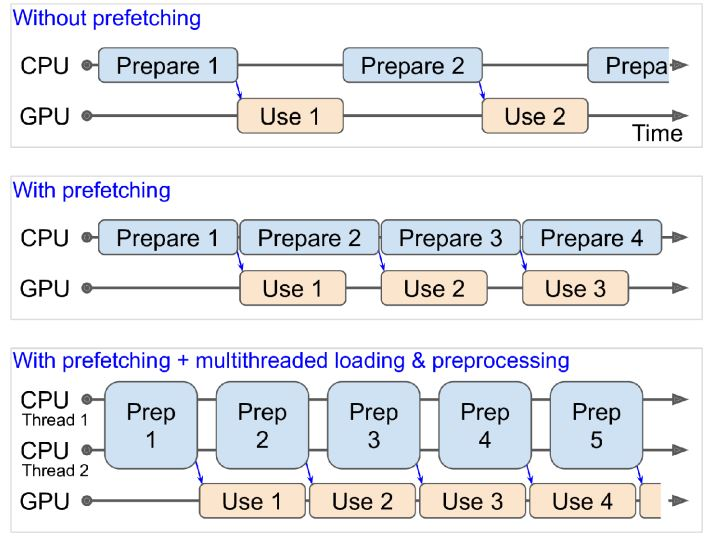

- Now you can use the `fit()` method on Dataset. It will handle repeating the dataset for each epoch with different random order.
- If the dataset is small enough to fit in memory, you can significantly speed up training by using the dataset’s cache() method to cache its content to RAM. You should generally do this after loading and preprocessing the data, but before shuffling, repeating, batching, and prefetching. This way, each instance will only be read and preprocessed once (instead of once per epoch), but the data will still be shuffled differently at each epoch, and the next batch will still be prepared in advance.

## Keras preprocessing layers

### The `Normalization` Layer

In [ ]:
norm_layer = tf.keras.layers.Normalization()
X_train = data_train[:, :-1]
norm_layer.adapt(X_train)

In [ ]:
normal_train_set = train_set.map(lambda X, y: (norm_layer(X), y))

In [ ]:
list(normal_train_set.take(1))

[(<tf.Tensor: shape=(3, 8), dtype=float32, numpy=
  array([[ 0.66373473, -0.83843696,  0.4041371 , -0.08990226,  0.01848155,
          -0.02645466,  0.655217  , -1.2611353 ],
         [ 0.39274105,  0.35079363,  0.18729788, -0.03611717, -0.42004362,
          -0.02783295,  1.1983724 , -1.3709788 ],
         [ 2.0989196 ,  0.11294751,  0.8611418 , -0.26046097, -0.7936671 ,
          -0.05640738, -0.8244133 ,  0.8358633 ]], dtype=float32)>,
  <tf.Tensor: shape=(3, 1), dtype=float32, numpy=
  array([[3.158],
         [2.286],
         [3.519]], dtype=float32)>)]

### The `Discretization` Layer

The Discretization layer’s goal is to transform a numerical feature into a categorical feature by mapping value ranges (called bins) to categories. This is sometimes useful for features with multimodal distributions, or with features that have a highly non-linear relationship with the target.

In [ ]:
age = tf.constant([[10.], [93.], [57.], [18.], [37.], [5.]])
discretize_layer = tf.keras.layers.Discretization(bin_boundaries=[18., 50.])
age_categories = discretize_layer(age)
age_categories

<tf.Tensor: shape=(6, 1), dtype=int64, numpy=
array([[0],
       [2],
       [2],
       [1],
       [1],
       [0]])>

In [ ]:
discretize_layer = tf.keras.layers.Discretization(num_bins=3)
discretize_layer.adapt(age)
age_categories = discretize_layer(age)
age_categories

<tf.Tensor: shape=(6, 1), dtype=int64, numpy=
array([[1],
       [2],
       [2],
       [1],
       [2],
       [0]])>

In [ ]:
discretize_layer.bin_boundaries

ListWrapper([10.0, 36.999996185302734])

### The `CategoryEncoding` Layer

Encode integer categories

In [ ]:
onehot_layer = tf.keras.layers.CategoryEncoding(num_tokens=3)
onehot_layer(age_categories)

<tf.Tensor: shape=(6, 3), dtype=float32, numpy=
array([[0., 1., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 0., 1.],
       [1., 0., 0.]], dtype=float32)>

In [ ]:
two_age_categories = np.array([[1, 0], [2, 2], [2, 0]])
onehot_layer(two_age_categories)

<tf.Tensor: shape=(3, 3), dtype=float32, numpy=
array([[1., 1., 0.],
       [0., 0., 1.],
       [1., 0., 1.]], dtype=float32)>

### The `StringLookup` Layer

In [ ]:
cities = ["Auckland", "Paris", "Paris", "San Francisco"]
str_lookup_layer = tf.keras.layers.StringLookup()
str_lookup_layer.adapt(cities)
str_lookup_layer.get_vocabulary()

['[UNK]', 'Paris', 'San Francisco', 'Auckland']

In [ ]:
str_lookup_layer([["Paris"], ["Auckland"], ["Auckland"], ["Montreal"]])

<tf.Tensor: shape=(4, 1), dtype=int64, numpy=
array([[1],
       [3],
       [3],
       [0]])>

Unknown categories get mapped to 0, as is the case for “Montreal” in this example. The known categories are numbered starting at 1, from the most frequent category to the least frequent.

By default, it would then map all unknown to category 0, making them indistinguishable by the model. To reduce this risk (while still adapting the layer only on a subset of the training set), you can set num_oov_indices to an integer greater than 1. This is the number of out-of-vocabulary (OOV) buckets to use: each unknown category will get mapped pseudorandomly to one of the OOV buckets, using a hash function modulo the number of OOV buckets. This will allow the model to distinguish at least some of the rare categories.

In [ ]:
str_lookup_layer = tf.keras.layers.StringLookup(num_oov_indices=5)
str_lookup_layer.adapt(cities)
str_lookup_layer([["Paris"], ["Auckland"], ["Foo"], ["Bar"], ["Baz"]])

<tf.Tensor: shape=(5, 1), dtype=int64, numpy=
array([[5],
       [7],
       [4],
       [3],
       [4]])>

In [ ]:
str_lookup_layer.get_vocabulary()

['[UNK]',
 '[UNK]',
 '[UNK]',
 '[UNK]',
 '[UNK]',
 'Paris',
 'San Francisco',
 'Auckland']

"Foo" and "Baz" happen to be mapped to the same bucket (with ID 4), so they remain indistinguishable by the model. This is called a hashing collision.

For one-hot encoding:

In [ ]:
str_lookup_layer = tf.keras.layers.StringLookup(output_mode="one_hot")
str_lookup_layer.adapt(cities)
str_lookup_layer([["Paris"], ["Auckland"], ["Auckland"], ["Montreal"]])

<tf.Tensor: shape=(4, 4), dtype=float32, numpy=
array([[0., 1., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.]], dtype=float32)>

### Encoding Categorical Features Using Embeddings

- An embedding is a dense representation of some higher-dimensional data, such as a category, or a word in a vocabulary. If there are 50,000 possible categories, then one-hot encoding would produce a 50,000-dimensional sparse vector (i.e., containing mostly zeros). In contrast, an embedding would be a comparatively small dense vector; for example, with just 100 dimensions.

- In deep learning, embeddings are usually initialized randomly, and they are then trained by gradient descent, along with the other model parameters. For example, the "NEAR BAY" category in the California housing dataset could be represented initially by a random vector such as [0.131, 0.890], while the "NEAR OCEAN" category might be represented by another random vector such as [0.631, 0.791]. In this example, we use 2D embeddings, but the number of dimensions is a hyperparameter you can tweak.

- Since these embeddings are trainable, they will gradually improve during training; and as they represent fairly similar categories in this case, gradient descent will certainly end up pushing them closer together, while it will tend to move them away from the "INLAND" category’s embedding.

- Indeed, the better the representation, the easier it will be for the neural network to make accurate predictions, so training tends to make embeddings useful representations of the categories. This is called representation learning

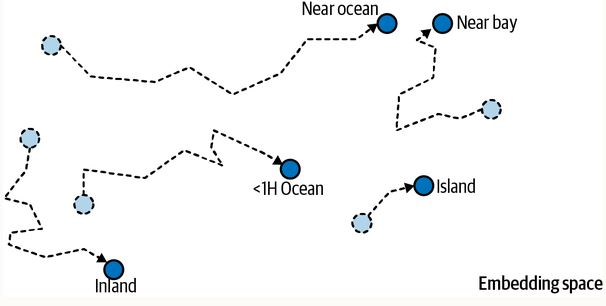

- Not only will embeddings generally be useful representations for the task at hand, but quite often these same embeddings can be reused successfully for other tasks. The most common example of this is word embeddings (i.e., embeddings of individual words): when you are working on a natural language processing task, you are often better off reusing pretrained word embeddings than training your own.

- The idea of using vectors to represent words dates back to the 1960s, and many sophisticated techniques have been used to generate useful vectors, including using neural networks. But things really took off in 2013, when Tomáš Mikolov and other Google researchers published a paper describing an efficient technique to learn word embeddings using neural networks, significantly outperforming previous attempts. This allowed them to learn embeddings on a very large corpus of text: they trained a neural network to predict the words near any given word and obtained astounding word embeddings. For example, synonyms had very close embeddings, and semantically related words such as France, Spain, and Italy ended up clustered together.

- It’s not just about proximity, though: word embeddings were also organized along meaningful axes in the embedding space. Here is a famous example: if you compute King – Man + Woman (adding and subtracting the embedding vectors of these words), then the result will be very close to the embedding of the word Queen. In other words, the word embeddings encode the concept of gender! Similarly, you can compute Madrid – Spain + France, and the result is close to Paris, which seems to show that the notion of capital city was also encoded in the embeddings.

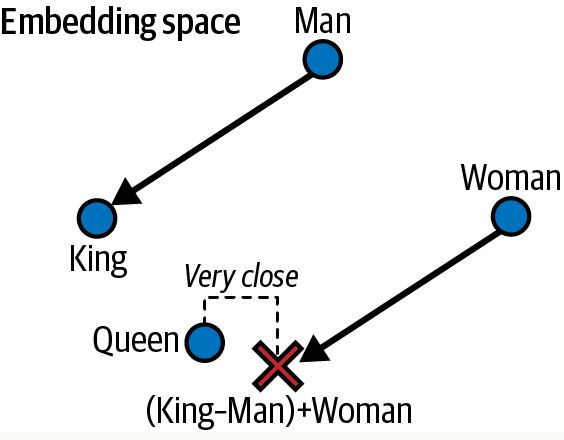

Keras provides an Embedding layer, which wraps an embedding matrix: this matrix has one row per category and one column per embedding dimension. By default, it is initialized randomly. To convert a category ID to an embedding, the Embedding layer just looks up and returns the row that corresponds to that category.

In [ ]:
tf.random.set_seed(42)
embedding_layer = tf.keras.layers.Embedding(input_dim=5, output_dim=2)
embedding_layer(np.array([2, 4, 2]))

<tf.Tensor: shape=(3, 2), dtype=float32, numpy=
array([[-0.0317896 ,  0.01799372],
       [ 0.00489038, -0.01888341],
       [-0.0317896 ,  0.01799372]], dtype=float32)>

An Embedding layer is initialized randomly, so it does not make sense to use it outside of a model as a standalone preprocessing layer unless you initialize it with pretrained weights.

In [ ]:
import numpy as np

In [ ]:
tf.keras.utils.set_random_seed(42)
ocean_prox = ["<1H OCEAN", "INLAND", "NEAR OCEAN", "NEAR BAY", "ISLAND"]
str_lookup_layer = tf.keras.layers.StringLookup()
str_lookup_layer.adapt(ocean_prox)
lookup_and_embed = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=[], dtype=tf.string),  # WORKAROUND
    str_lookup_layer,
    tf.keras.layers.Embedding(input_dim=str_lookup_layer.vocabulary_size(),
                              output_dim=2)
], name="embeding")
lookup_and_embed(np.array(["<1H OCEAN", "ISLAND", "<1H OCEAN"]))

<tf.Tensor: shape=(3, 2), dtype=float32, numpy=
array([[-0.04135817, -0.00536425],
       [ 0.04704999, -0.03320879],
       [-0.04135817, -0.00536425]], dtype=float32)>

One-hot encoding followed by a Dense layer (with no activation function and no biases) is equivalent to an Embedding layer. However, the Embedding layer uses way fewer computations as it avoids many multiplications by zero—the performance difference becomes clear when the size of the embedding matrix grows. The Dense layer’s weight matrix plays the role of the embedding matrix. For example, using one-hot vectors of size 20 and a Dense layer with 10 units is equivalent to using an Embedding layer with input_dim=20 and output_dim=10. As a result, it would be wasteful to use more embedding dimensions than the number of units in the layer that follows the Embedding layer.

In [ ]:
# Training embedding for random dataset:
tf.random.set_seed(42)
np.random.seed(42)
X_train_num = np.random.rand(10_000, 8)
X_train_cat = np.random.choice(ocean_prox, size=10_000)
y_train = np.random.rand(10_000, 1)
X_valid_num = np.random.rand(2_000, 8)
X_valid_cat = np.random.choice(ocean_prox, size=2_000)
y_valid = np.random.rand(2_000, 1)

num_input = tf.keras.layers.Input(shape=[8], name="num")
cat_input = tf.keras.layers.Input(shape=[], dtype=tf.string, name="cat")
cat_embeddings = lookup_and_embed(cat_input)
encoded_inputs = tf.keras.layers.concatenate([num_input, cat_embeddings])
outputs = tf.keras.layers.Dense(1)(encoded_inputs)
model = tf.keras.models.Model(inputs=[num_input, cat_input], outputs=[outputs])
model.compile(loss="mse", optimizer="sgd")
history = model.fit((X_train_num, X_train_cat), y_train, epochs=5,
                    validation_data=((X_valid_num, X_valid_cat), y_valid))

Epoch 1/5
313/313 [==============================] - 1s 2ms/step - loss: 0.1818 - val_loss: 0.1428
Epoch 2/5
313/313 [==============================] - 1s 2ms/step - loss: 0.1190 - val_loss: 0.1061
Epoch 3/5
313/313 [==============================] - 1s 2ms/step - loss: 0.0969 - val_loss: 0.0926
Epoch 4/5
313/313 [==============================] - 1s 2ms/step - loss: 0.0888 - val_loss: 0.0874
Epoch 5/5
313/313 [==============================] - 1s 2ms/step - loss: 0.0856 - val_loss: 0.0852


In [ ]:
# learned embedings
model.get_layer("embeding")(np.array(["<1H OCEAN", "INLAND", "NEAR OCEAN", "NEAR BAY", "ISLAND"]))

<tf.Tensor: shape=(5, 2), dtype=float32, numpy=
array([[0.0411645 , 0.01646275],
       [0.04927193, 0.00886516],
       [0.02631925, 0.03564743],
       [0.02230128, 0.02813697],
       [0.0515095 , 0.00220331]], dtype=float32)>

### Text Preprocessing

In [ ]:
train_data = ["To be", "!(to be)", "That's the question", "Be, be, be."]
text_vec_layer = tf.keras.layers.TextVectorization() # default is ordinal encoding
text_vec_layer.adapt(train_data)
text_vec_layer(["Be good!", "Question: be or be?"])

<tf.Tensor: shape=(2, 4), dtype=int64, numpy=
array([[2, 1, 0, 0],
       [6, 2, 1, 2]])>

In [ ]:
text_vec_layer.get_vocabulary()

['', '[UNK]', 'be', 'to', 'the', 'thats', 'question']

To construct the vocabulary, the adapt() method first converted the training sentences to lowercase and removed punctuation, which is why “Be”, “be”, and “be?” are all encoded as “be” = 2. Next, the sentences were split on whitespace, and the resulting words were sorted by descending frequency, producing the final vocabulary. When encoding sentences, unknown words get encoded as 1s. Lastly, since the first sentence is shorter than the second, it was padded with 0s.

The word IDs must be encoded, typically using an Embedding layer. Alternatively, you can set the TextVectorization layer’s output_mode argument to "multi_hot" or "count" to get the corresponding encodings.

In [ ]:
text_vec_layer = tf.keras.layers.TextVectorization(output_mode="multi_hot")
text_vec_layer.adapt(train_data)
text_vec_layer(["Be good!", "Question: be or be?"])

<tf.Tensor: shape=(2, 6), dtype=float32, numpy=
array([[1., 1., 0., 0., 0., 0.],
       [1., 1., 0., 0., 0., 1.]], dtype=float32)>

In [ ]:
text_vec_layer.get_vocabulary()

['[UNK]', 'be', 'to', 'the', 'thats', 'question']

In [ ]:
text_vec_layer = tf.keras.layers.TextVectorization(output_mode="count")
text_vec_layer.adapt(train_data)
text_vec_layer(["Be good!", "Question: be or be?"])

<tf.Tensor: shape=(2, 6), dtype=float32, numpy=
array([[1., 1., 0., 0., 0., 0.],
       [1., 2., 0., 0., 0., 1.]], dtype=float32)>

However, simply counting words is usually not ideal: words like “to” and “the” are so frequent that they hardly matter at all, whereas, rarer words such as “basketball” are much more informative. So, rather than setting output_mode to "multi_hot" or "count", it is usually preferable to set it to "tf_idf", which stands for term-frequency × inverse-document-frequency (TF-IDF). This is similar to the count encoding, but words that occur frequently in the training data are downweighted, and conversely, rare words are upweighted. For example:

In [ ]:
text_vec_layer = tf.keras.layers.TextVectorization(output_mode="tf_idf")
text_vec_layer.adapt(train_data)
text_vec_layer(["Be good!", "Question: be or be?"])

<tf.Tensor: shape=(2, 6), dtype=float32, numpy=
array([[0.96725637, 0.6931472 , 0.        , 0.        , 0.        ,
        0.        ],
       [0.96725637, 1.3862944 , 0.        , 0.        , 0.        ,
        1.0986123 ]], dtype=float32)>

There are many TF-IDF variants, but the way the TextVectorization layer implements it is by multiplying each word count by a weight equal to log(1 + d / (f + 1)), where d is the total number of sentences (a.k.a., documents) in the training data and f counts how many of these training sentences contain the given word. For example, in this case there are d = 4 sentences in the training data, and the word “be” appears in f = 3 of these. Since the word “be” occurs twice in the sentence “Question: be or be?”, it gets encoded as 2 × log(1 + 4 / (1 + 3)) ≈ 1.3862944. The word “question” only appears once, but since it is a less common word, its encoding is almost as high: 1 × log(1 + 4 / (1 + 1)) ≈ 1.0986123. Note that the average weight is used for unknown words.

**Better approaches:**

This approach to text encoding is straightforward to use and it can give fairly good results for basic natural language processing tasks, but it has several important limitations: it only works with languages that separate words with spaces, it doesn’t distinguish between homonyms (e.g., “to bear” versus “teddy bear”), it gives no hint to your model that words like “evolution” and “evolutionary” are related, etc. And if you use multi-hot, count, or TF-IDF encoding, then the order of the words is lost. So what are the other options?

- One option is to use the *TensorFlow Text library*, which provides more advanced text preprocessing features than the `TextVectorization` layer..

- Yet another option is to use *pretrained language model components*. Let’s look at this now.

## Using Pretrained Language Model Components

The TensorFlow Hub library makes it easy to reuse pretrained model components in your own models, for text, image, audio, and more. These model components are called modules.

Modules typically contain both preprocessing code and pretrained weights, and they generally require no extra training (but of course, the rest of your model will certainly require training).

In [ ]:
import tensorflow_hub as hub
hub_layer = hub.KerasLayer("https://www.kaggle.com/models/google/nnlm/frameworks/TensorFlow2/variations/en-dim50/versions/1",
                           input_shape=[], dtype=tf.string)

In [ ]:
sentence_embeddings = hub_layer(tf.constant(["To be", "Not to be"]))
sentence_embeddings.numpy().round(2)

array([[-0.25,  0.28,  0.01,  0.1 ,  0.14,  0.16,  0.25,  0.02,  0.07,
         0.13, -0.19,  0.06, -0.04, -0.07,  0.  , -0.08, -0.14, -0.16,
         0.02, -0.24,  0.16, -0.16, -0.03,  0.03, -0.14,  0.03, -0.09,
        -0.04, -0.14, -0.19,  0.07,  0.15,  0.18, -0.23, -0.07, -0.08,
         0.01, -0.01,  0.09,  0.14, -0.03,  0.03,  0.08,  0.1 , -0.01,
        -0.03, -0.07, -0.1 ,  0.05,  0.31],
       [-0.2 ,  0.2 , -0.08,  0.02,  0.19,  0.05,  0.22, -0.09,  0.02,
         0.19, -0.02, -0.14, -0.2 , -0.04,  0.01, -0.07, -0.22, -0.1 ,
         0.16, -0.44,  0.31, -0.1 ,  0.23,  0.15, -0.05,  0.15, -0.13,
        -0.04, -0.08, -0.16, -0.1 ,  0.13,  0.13, -0.18, -0.04,  0.03,
        -0.1 , -0.07,  0.07,  0.03, -0.08,  0.02,  0.05,  0.07, -0.14,
        -0.1 , -0.18, -0.13, -0.04,  0.15]], dtype=float32)

The hub.KerasLayer layer downloads the module from the given URL. This particular module is a sentence encoder: it takes strings as input and encodes each one as a single vector (in this case, a 50-dimensional vector). Internally, it parses the string (splitting words on spaces) and embeds each word using an embedding matrix that was pretrained on a huge corpus: the Google News 7B corpus (seven billion words long!). Then it computes the mean of all the word embeddings, and the result is the sentence embedding. To be precise, the sentence embedding is equal to the mean word embedding multiplied by the square root of the number of words in the sentence. This compensates for the fact that the mean of n random vectors gets shorter as n grows.

## TensorFlow Datasets

You can then import tensorflow_datasets, usually as tfds, then call the tfds.load() function, which will download the data you want (unless it was already downloaded earlier) and return the data as a dictionary of datasets (typically one for training and one for testing, but this depends on the dataset you choose). For example, let’s download MNIST:

In [ ]:
import tensorflow_datasets as tfds

datasets = tfds.load(name="mnist")
mnist_train, mnist_test = datasets["train"], datasets["test"]

Dl Completed...:   0%|          | 0/5 [00:00<?, ? file/s]

Dataset mnist downloaded and prepared to /root/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.


In [ ]:
train_set, valid_set, test_set = tfds.load(
    name="mnist",
    split=["train[:90%]", "train[90%:]", "test"],
    as_supervised=True
)
train_set = train_set.shuffle(10_000, seed=42).batch(32).prefetch(1)
valid_set = valid_set.batch(32).cache()
test_set = test_set.batch(32).cache()
tf.random.set_seed(42)
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam",
              metrics=["accuracy"])
history = model.fit(train_set, validation_data=valid_set, epochs=5)
test_loss, test_accuracy = model.evaluate(test_set)

Epoch 1/5
1688/1688 [==============================] - 15s 8ms/step - loss: 9.8164 - accuracy: 0.8354 - val_loss: 5.7399 - val_accuracy: 0.8857
Epoch 2/5
1688/1688 [==============================] - 4s 2ms/step - loss: 5.7245 - accuracy: 0.8789 - val_loss: 5.3142 - val_accuracy: 0.8867
Epoch 3/5
1688/1688 [==============================] - 3s 2ms/step - loss: 5.1925 - accuracy: 0.8833 - val_loss: 6.7178 - val_accuracy: 0.8660
Epoch 4/5
1688/1688 [==============================] - 5s 3ms/step - loss: 5.0357 - accuracy: 0.8857 - val_loss: 5.5540 - val_accuracy: 0.8953
Epoch 5/5
313/313 [==============================] - 1s 3ms/step - loss: 5.8840 - accuracy: 0.8705


## Example

In [ ]:
import os
import tensorflow as tf

### Loading data

In [ ]:
origin = "https://ai.stanford.edu/~amaas/data/sentiment/"
filename = "aclImdb_v1.tar.gz"
filepath = tf.keras.utils.get_file(fname=filename, origin=origin+filename,
                                   cache_dir=".", extract=True)

84125825/84125825 [==============================] - 5s 0us/step


In [ ]:
def read_dir(dir):
    return [os.path.join(dir, fname) for fname in os.listdir(dir) if fname.endswith(".txt")]

train_neg = read_dir("./datasets/aclImdb/train/neg")
train_pos = read_dir("./datasets/aclImdb/train/pos")
test_valid_neg = read_dir("./datasets/aclImdb/test/neg")
test_valid_pos = read_dir("./datasets/aclImdb/test/pos")

len(train_neg), len(train_pos), len(test_valid_neg), len(test_valid_pos)

(12500, 12500, 12500, 12500)

In [ ]:
test_neg = test_valid_neg[:5000]
test_pos = test_valid_pos[:5000]
valid_neg = test_valid_neg[5000:]
valid_pos = test_valid_pos[5000:]

len(valid_neg), len(valid_pos), len(test_neg), len(test_pos)

(7500, 7500, 5000, 5000)

In [ ]:
train_neg[:10]

['./datasets/aclImdb/train/neg/12216_4.txt',
 './datasets/aclImdb/train/neg/3569_1.txt',
 './datasets/aclImdb/train/neg/3757_1.txt',
 './datasets/aclImdb/train/neg/8834_4.txt',
 './datasets/aclImdb/train/neg/10995_1.txt',
 './datasets/aclImdb/train/neg/9714_1.txt',
 './datasets/aclImdb/train/neg/2145_1.txt',
 './datasets/aclImdb/train/neg/11740_1.txt',
 './datasets/aclImdb/train/neg/11041_4.txt',
 './datasets/aclImdb/train/neg/11667_1.txt']

In [ ]:
def imdb_datasets(filepaths_pos, filepaths_neg, read_parallel_calls=tf.data.AUTOTUNE):
    data_neg = tf.data.TextLineDataset(filepaths_neg).map(lambda review: (review, 0), num_parallel_calls=read_parallel_calls)
    data_pos = tf.data.TextLineDataset(filepaths_pos).map(lambda review: (review, 1), num_parallel_calls=read_parallel_calls)
    data = tf.data.Dataset.concatenate(data_neg, data_pos)
    return data

In [ ]:
batch_size = 32

data_train = imdb_datasets(train_pos, train_neg).shuffle(25_000, seed=42).batch(batch_size).prefetch(1)
data_valid = imdb_datasets(valid_pos, valid_neg).batch(batch_size).prefetch(1)
data_test = imdb_datasets(test_pos, test_neg).batch(batch_size).prefetch(1)

#### Alternatively:

In [ ]:
import tensorflow_datasets as tfds

datasets = tfds.load(name="imdb_reviews")
train_set, test_set = datasets["train"], datasets["test"]

In [ ]:
for example in train_set.take(1):
    print(example["text"])
    print(example["label"])

tf.Tensor(b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it.", shape=(), dtype=string)
tf.Tensor(0, shape=(), dtype=int64)


### TF-IDF vectorization

In [ ]:
vectorizer = tf.keras.layers.TextVectorization(max_tokens=800, output_mode="tf_idf")
sample_data = data_train.map(lambda review, label: review)
vectorizer.adapt(sample_data)

In [ ]:
vectorizer.get_vocabulary()[:10]

['[UNK]', 'the', 'and', 'a', 'of', 'to', 'is', 'in', 'it', 'i']

In [ ]:
tf.keras.utils.set_random_seed(42)
model = tf.keras.Sequential([
    vectorizer,
    tf.keras.layers.Dense(100, activation="relu", kernel_initializer="he_normal"),
    tf.keras.layers.Dense(1, activation="sigmoid")
])
model.compile(loss="binary_crossentropy", optimizer="nadam", metrics=["accuracy"])
model.fit(data_train, epochs=5, validation_data=data_valid)

Epoch 1/5
782/782 [==============================] - 11s 6ms/step - loss: 0.4347 - accuracy: 0.8183 - val_loss: 0.4839 - val_accuracy: 0.8103
Epoch 2/5
782/782 [==============================] - 8s 7ms/step - loss: 0.3833 - accuracy: 0.8440 - val_loss: 0.3582 - val_accuracy: 0.8526
Epoch 3/5
782/782 [==============================] - 10s 10ms/step - loss: 0.3498 - accuracy: 0.8566 - val_loss: 0.3583 - val_accuracy: 0.8529
Epoch 4/5
782/782 [==============================] - 9s 7ms/step - loss: 0.3085 - accuracy: 0.8735 - val_loss: 0.3653 - val_accuracy: 0.8508
Epoch 5/5
782/782 [==============================] - 9s 8ms/step - loss: 0.2581 - accuracy: 0.8932 - val_loss: 0.4299 - val_accuracy: 0.8259


### Embedding

To compute the mean embedding for each review, and multiply it by the square root of the number of words in that review, we will need a little function. For each sentence, this function needs to compute $M \times \sqrt N$, where $M$ is the mean of all the word embeddings in the sentence (excluding padding tokens), and $N$ is the number of words in the sentence (also excluding padding tokens). We can rewrite $M$ as $\dfrac{S}{N}$, where $S$ is the sum of all word embeddings (it does not matter whether or not we include the padding tokens in this sum, since their representation is a zero vector). So the function must return $M \times \sqrt N = \dfrac{S}{N} \times \sqrt N = \dfrac{S}{\sqrt N \times \sqrt N} \times \sqrt N= \dfrac{S}{\sqrt N}$.

In [ ]:
# (Batch_size, vocabulary_size, encoding_size)
example_embeding = tf.constant([[[1., 2., 3.], [4., 5., 0.], [0., 0., 0.]],
                                [[6., 0., 0.], [0., 0., 0.], [0., 0., 0.]]])
example_embeding

<tf.Tensor: shape=(2, 3, 3), dtype=float32, numpy=
array([[[1., 2., 3.],
        [4., 5., 0.],
        [0., 0., 0.]],

       [[6., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]]], dtype=float32)>

In [ ]:
non_pad = tf.math.count_nonzero(example_embeding, axis=-1)
non_pad # For first sentence, first two words are non_pad

<tf.Tensor: shape=(2, 3), dtype=int64, numpy=
array([[3, 2, 0],
       [1, 0, 0]])>

In [ ]:
n_words = tf.math.count_nonzero(non_pad, axis=-1, keepdims=True)
n_words

<tf.Tensor: shape=(2, 1), dtype=int64, numpy=
array([[2],
       [1]])>

In [ ]:
sum_embed = tf.reduce_sum(example_embeding, axis=1)
sum_embed

<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[5., 7., 3.],
       [6., 0., 0.]], dtype=float32)>

In [ ]:
sum_embed / tf.sqrt(tf.cast(n_words, dtype="float32"))

<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[3.535534 , 4.9497476, 2.1213205],
       [6.       , 0.       , 0.       ]], dtype=float32)>

In [ ]:
def find_sentence_embedding(word_embedings):
    non_pad = tf.math.count_nonzero(word_embedings, axis=-1)
    n_words = tf.math.count_nonzero(non_pad, axis=-1, keepdims=True)
    sum_embed = tf.reduce_sum(word_embedings, axis=1)
    return sum_embed / tf.sqrt(tf.cast(n_words, dtype="float32"))

In [ ]:
tf.keras.utils.set_random_seed(42)
vocabulary_size = 1000
embedding_size = 20

vectorizer = tf.keras.layers.TextVectorization(max_tokens=vocabulary_size, output_mode="int")
sample_data = data_train.map(lambda review, label: review)
vectorizer.adapt(sample_data)

model = tf.keras.Sequential([
    vectorizer,
    tf.keras.layers.Embedding(input_dim=vocabulary_size, output_dim=embedding_size, mask_zero=True),
    tf.keras.layers.Lambda(find_sentence_embedding),
    tf.keras.layers.Dense(100, activation="relu", kernel_initializer="he_normal"),
    tf.keras.layers.Dense(1, activation="sigmoid")
])
model.compile(loss="binary_crossentropy", optimizer="nadam", metrics=["accuracy"])
model.fit(data_train, epochs=5, validation_data=data_valid)

Epoch 1/5
782/782 [==============================] - 14s 13ms/step - loss: 0.4668 - accuracy: 0.7804 - val_loss: 0.3498 - val_accuracy: 0.8441
Epoch 2/5
782/782 [==============================] - 11s 12ms/step - loss: 0.3335 - accuracy: 0.8592 - val_loss: 0.3146 - val_accuracy: 0.8657
Epoch 3/5
782/782 [==============================] - 12s 12ms/step - loss: 0.3177 - accuracy: 0.8642 - val_loss: 0.3196 - val_accuracy: 0.8572
Epoch 4/5
782/782 [==============================] - 9s 8ms/step - loss: 0.3114 - accuracy: 0.8684 - val_loss: 0.3104 - val_accuracy: 0.8665
Epoch 5/5
782/782 [==============================] - 9s 9ms/step - loss: 0.3095 - accuracy: 0.8657 - val_loss: 0.3116 - val_accuracy: 0.8655


# CNN:

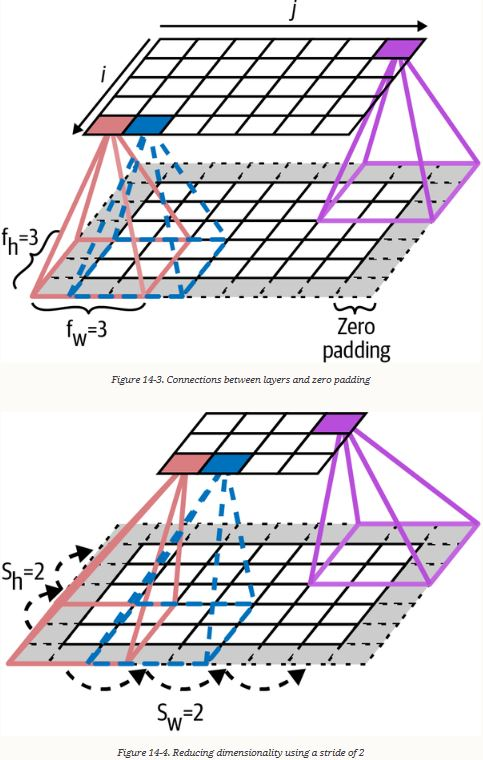

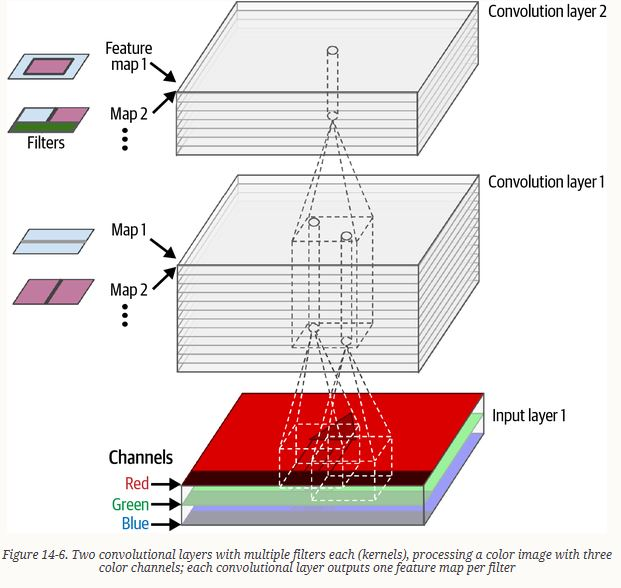

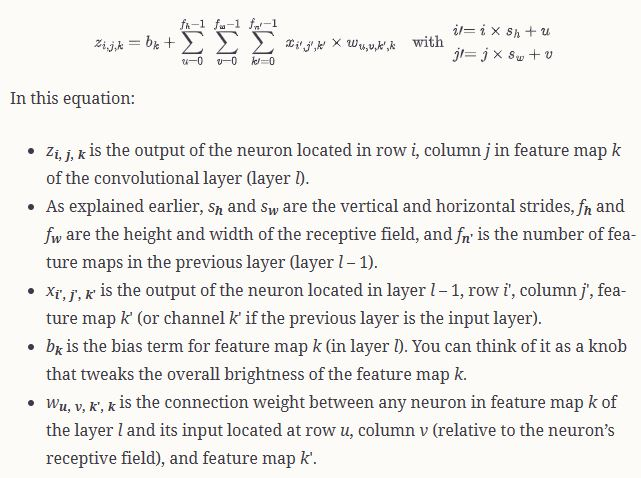

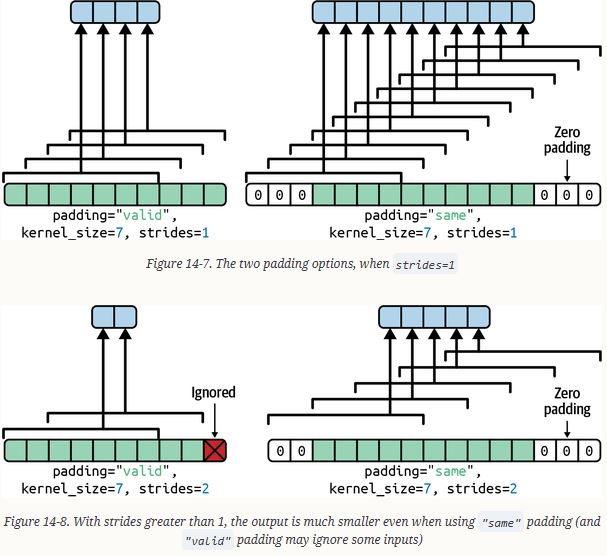

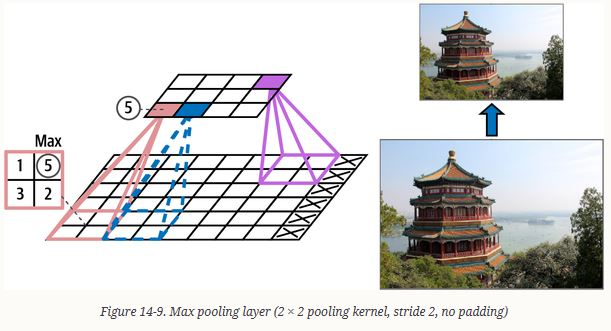

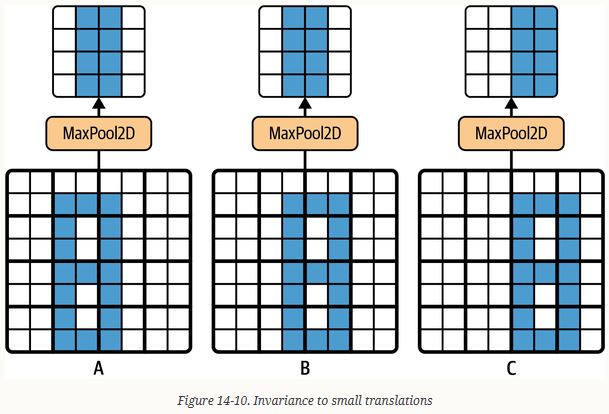

 - AlexNet (2012) --> GoogLeNet (2014) --> ResNet (2015) --> SENet (2017).

 Xception, ResNeXt, DenseNet, MobileNet, CSPNet, and EfficientNet.


## GoogLeNet

 - GoogLeNet actually has 10 times fewer parameters than AlexNet but much deeper

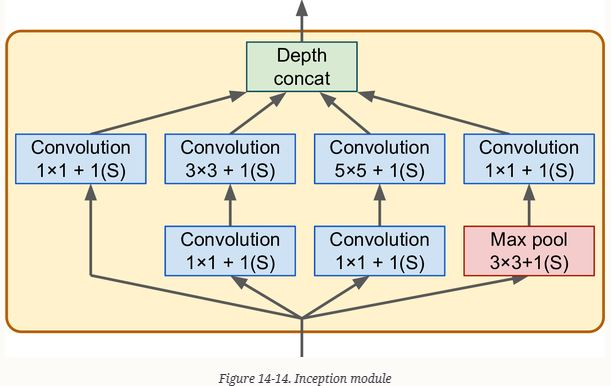

- The notation “3 × 3 + 1(S)” means that the layer uses a 3 × 3 kernel, stride 1, and "same" padding.
- You may wonder why inception modules have convolutional layers with 1 × 1 kernels. Surely these layers cannot capture any features because they look at only one pixel at a time, right? In fact, these layers serve three purposes:

    - Although they cannot capture spatial patterns, they can capture patterns along the depth dimension (i.e., across channels).

    - They are configured to output fewer feature maps than their inputs, so they serve as bottleneck layers, meaning they reduce dimensionality. This cuts the computational cost and the number of parameters, speeding up training and improving generalization.

    - Each pair of convolutional layers ([1 × 1, 3 × 3] and [1 × 1, 5 × 5]) acts like a single powerful convolutional layer, capable of capturing more complex patterns. A convolutional layer is equivalent to sweeping a dense layer across the image (at each location, it only looks at a small receptive field), and these pairs of convolutional layers are equivalent to sweeping two-layer neural networks across the image.

 In short, you can think of the whole inception module as a convolutional layer on steroids, able to output feature maps that capture complex patterns at various scales.

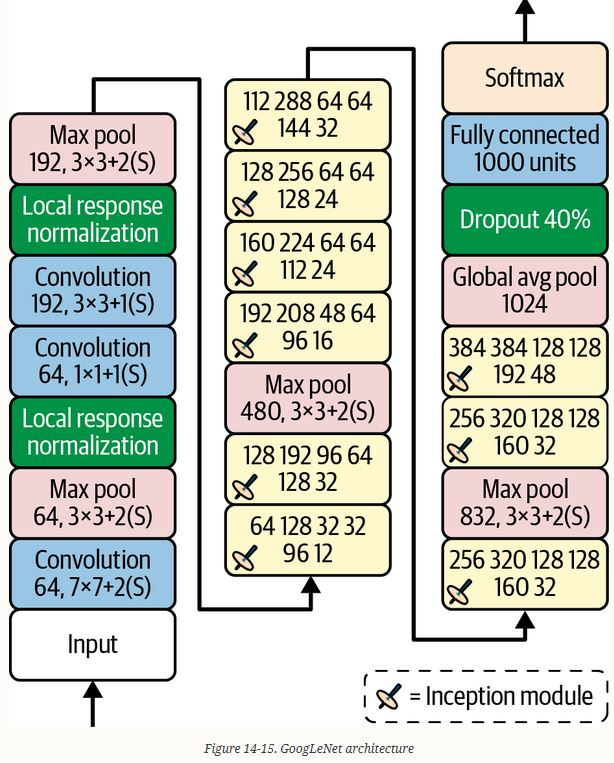

- The first two layers divide the image’s height and width by 4 (so its area is divided by 16), to reduce the computational load. The first layer uses a large kernel size, 7 × 7, so that much of the information is preserved.

- Then the local response normalization layer ensures that the previous layers learn a wide variety of features.

- Two convolutional layers follow, where the first acts like a bottleneck layer. As mentioned, you can think of this pair as a single smarter convolutional layer.

- Again, a local response normalization layer ensures that the previous layers capture a wide variety of patterns.

- Next, a max pooling layer reduces the image height and width by 2, again to speed up computations.

- Then comes the CNN’s backbone: a tall stack of nine inception modules, interleaved with a couple of max pooling layers to reduce dimensionality and speed up the net.

- Next, the global average pooling layer outputs the mean of each feature map: this drops any remaining spatial information, which is fine because there is not much spatial information left at that point. Indeed, GoogLeNet input images are typically expected to be 224 × 224 pixels, so after 5 max pooling layers, each dividing the height and width by 2, the feature maps are down to 7 × 7. Moreover, this is a classification task, not localization, so it doesn’t matter where the object is. Thanks to the dimensionality reduction brought by this layer, there is no need to have several fully connected layers at the top of the CNN (like in AlexNet), and this considerably reduces the number of parameters in the network and limits the risk of overfitting.

- The last layers are self-explanatory: dropout for regularization, then a fully connected layer with 1,000 units (since there are 1,000 classes) and a softmax activation function to output estimated class probabilities.

## VGGNet

It had 2 or 3 convolutional layers and a pooling layer, then again 2 or 3 convolutional layers and a pooling layer, and so on (reaching a total of 16 or 19 convolutional layers, depending on the VGG variant), plus a final dense network with 2 hidden layers and the output layer. It used small 3 × 3 filters, but it had many of them.

## ResNet

- Kaiming He et al. won the ILSVRC 2015 challenge using a Residual Network (ResNet) that delivered an astounding top-five error rate under 3.6%. The winning variant used an extremely deep CNN composed of 152 layers (other variants had 34, 50, and 101 layers). It confirmed the general trend: computer vision models were getting deeper and deeper, with fewer and fewer parameters. The key to being able to train such a deep network is to use skip connections (also called shortcut connections): the signal feeding into a layer is also added to the output of a layer located higher up the stack.

- When training a neural network, the goal is to make it model a target function h(x). If you add the input x to the output of the network (i.e., you add a skip connection), then the network will be forced to model f(x) = h(x) – x rather than h(x). This is called residual learning

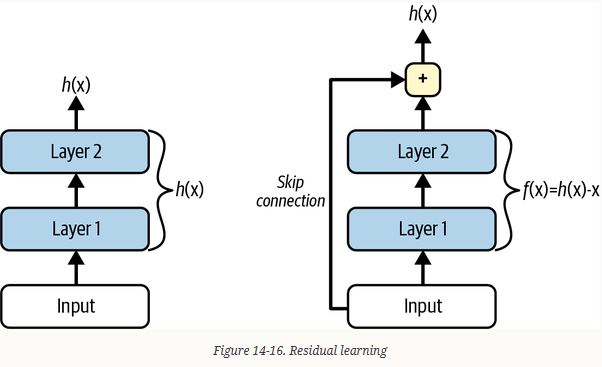

- When you initialize a regular neural network, its weights are close to zero, so the network just outputs values close to zero. If you add a skip connection, the resulting network just outputs a copy of its inputs; in other words, it initially models the identity function. If the target function is fairly close to the identity function (which is often the case), this will speed up training considerably.

- Moreover, if you add many skip connections, the network can start making progress even if several layers have not started learning yet. Thanks to skip connections, the signal can easily make its way across the whole network. The deep residual network can be seen as a stack of residual units (RUs), where each residual unit is a small neural network with a skip connection.

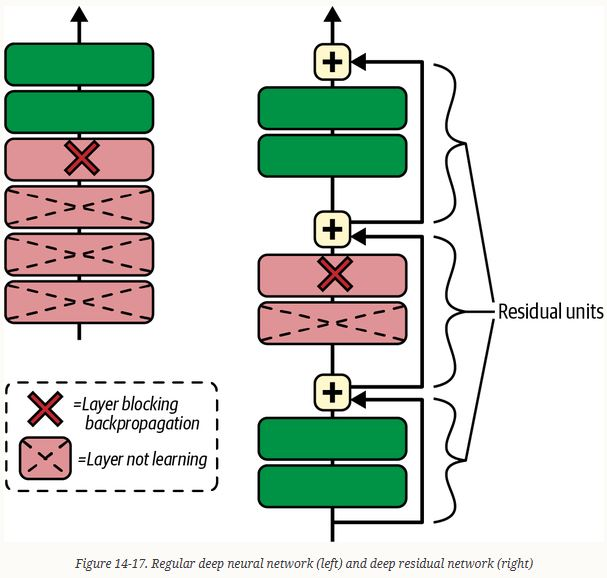

- Now let’s look at ResNet’s architecture. It is surprisingly simple. It starts and ends exactly like GoogLeNet (except without a dropout layer), and in between is just a very deep stack of residual units. Each residual unit is composed of two convolutional layers (and no pooling layer!), with batch normalization (BN) and ReLU activation, using 3 × 3 kernels and preserving spatial dimensions (stride 1, "same" padding).

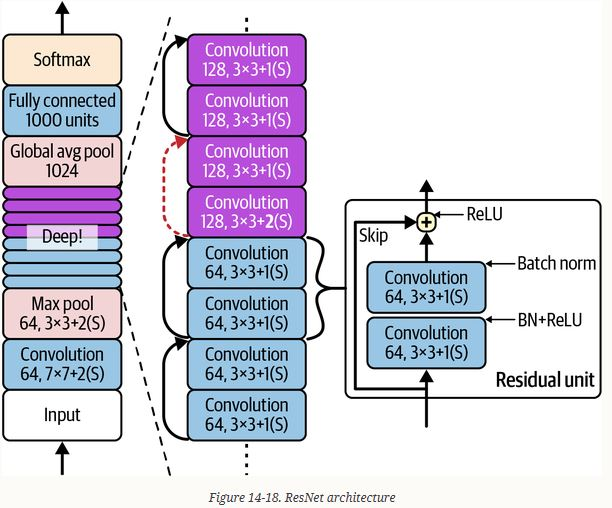

- Note that the number of feature maps is doubled every few residual units, at the same time as their height and width are halved (using a convolutional layer with stride 2). When this happens, the inputs cannot be added directly to the outputs of the residual unit because they don’t have the same shape (for example, this problem affects the skip connection represented by the dashed arrow in Figure 14-18). To solve this problem, the inputs are passed through a 1 × 1 convolutional layer with stride 2 and the right number of output feature maps (see Figure 14-19).



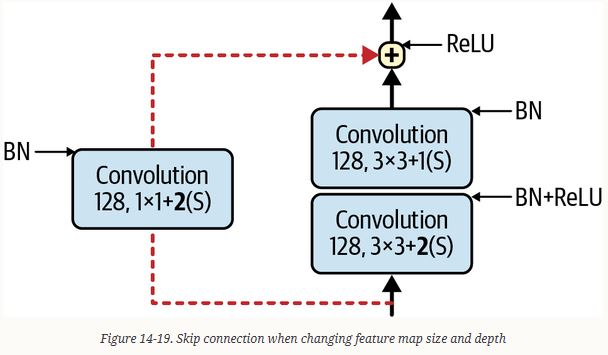

## Google Inception v4

- Google’s Inception-v4 architecture merged the ideas of GoogLeNet and ResNet and achieved a top-five error rate of close to 3% on ImageNet classification.

## Xception

- Just like Inception-v4, it merges the ideas of GoogLeNet and ResNet, but it replaces the inception modules with a special type of layer called a depthwise separable convolution layer (or separable convolution layer for short).
- While a regular convolutional layer uses filters that try to simultaneously capture spatial patterns (e.g., an oval) and cross-channel patterns (e.g., mouth + nose + eyes = face), a separable convolutional layer makes the strong assumption that spatial patterns and cross-channel patterns can be modeled separately (see Figure 14-20). Thus, it is composed of two parts: the first part applies a single spatial filter to each input feature map, then the second part looks exclusively for cross-channel patterns—it is just a regular convolutional layer with 1 × 1 filters.

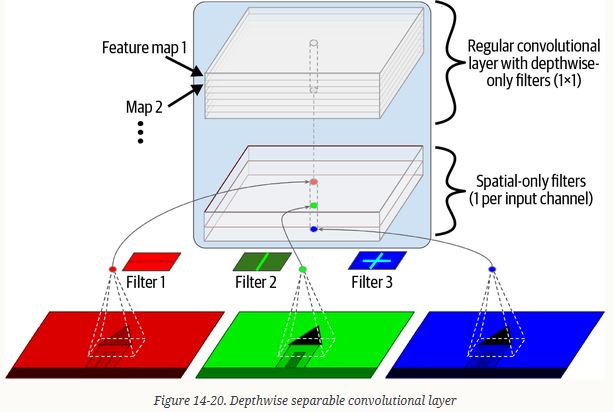

- Separable convolutional layers use fewer parameters, less memory, and fewer computations than regular convolutional layers, and they often perform better. Consider using them by default, except after layers with few channels (such as the input channel). In Keras, just use SeparableConv2D instead of Conv2D: it’s a drop-in replacement. Keras also offers a DepthwiseConv2D layer that implements the first part of a depthwise separable convolutional layer (i.e., applying one spatial filter per input feature map).

## SENet

- This architecture extends existing architectures such as inception networks and ResNets, and boosts their performance. This allowed SENet to win the competition with an astonishing 2.25% top-five error rate! The extended versions of inception networks and ResNets are called SE-Inception and SE-ResNet, respectively. The boost comes from the fact that a SENet adds a small neural network, called an SE block, to every inception module or residual unit in the original architecture

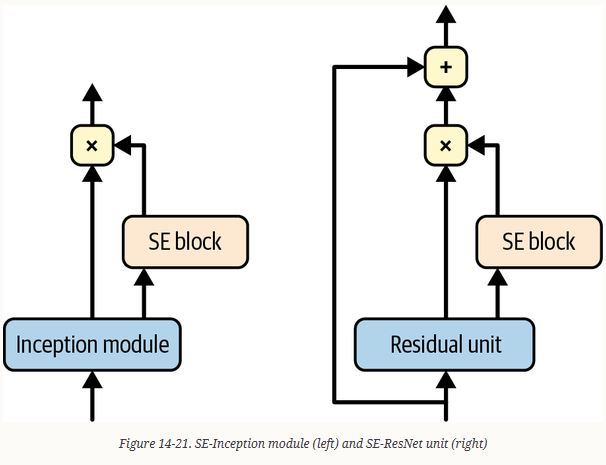

- An SE block analyzes the output of the unit it is attached to, focusing exclusively on the depth dimension (it does not look for any spatial pattern), and it learns which features are usually most active together. It then uses this information to recalibrate the feature maps, as shown in Figure 14-22. For example, an SE block may learn that mouths, noses, and eyes usually appear together in pictures: if you see a mouth and a nose, you should expect to see eyes as well. So, if the block sees a strong activation in the mouth and nose feature maps, but only mild activation in the eye feature map, it will boost the eye feature map (more accurately, it will reduce irrelevant feature maps). If the eyes were somewhat confused with something else, this feature map recalibration will help resolve the ambiguity.

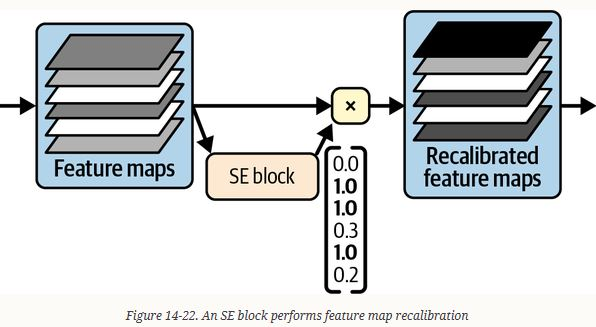

- An SE block is composed of just three layers: a global average pooling layer, a hidden dense layer using the ReLU activation function, and a dense output layer using the sigmoid activation function (see Figure 14-23).
- As earlier, the global average pooling layer computes the mean activation for each feature map: for example, if its input contains 256 feature maps, it will output 256 numbers representing the overall level of response for each filter. The next layer is where the “squeeze” happens: this layer has significantly fewer than 256 neurons—typically 16 times fewer than the number of feature maps (e.g., 16 neurons)—so the 256 numbers get compressed into a small vector (e.g., 16 dimensions). This is a low-dimensional vector representation (i.e., an embedding) of the distribution of feature responses. This bottleneck step forces the SE block to learn a general representation of the feature combinations (we will see this principle in action again when we discuss autoencoders). Finally, the output layer takes the embedding and outputs a recalibration vector containing one number per feature map (e.g., 256), each between 0 and 1. The feature maps are then multiplied by this recalibration vector, so irrelevant features (with a low recalibration score) get scaled down while relevant features (with a recalibration score close to 1) are left alone.

## DenseNet

- A DenseNet is composed of several dense blocks, each made up of a few densely connected convolutional layers. This architecture achieved excellent accuracy while using comparatively few parameters. What does “densely connected” mean? The output of each layer is fed as input to every layer after it within the same block. For example, layer 4 in a block takes as input the depthwise concatenation of the outputs of layers 1, 2, and 3 in that block. Dense blocks are separated by a few transition layers.

## EfficientNet

- EfficientNet is arguably the most important model in this list. The authors proposed a method to scale any CNN efficiently, by jointly increasing the depth (number of layers), width (number of filters per layer), and resolution (size of the input image) in a principled way. This is called compound scaling. They used neural architecture search to find a good architecture for a scaled-down version of ImageNet (with smaller and fewer images), and then used compound scaling to create larger and larger versions of this architecture. When EfficientNet models came out, they vastly outperformed all existing models, across all compute budgets, and they remain among the best models out there today.

- Understanding EfficientNet’s compound scaling method is helpful to gain a deeper understanding of CNNs, especially if you ever need to scale a CNN architecture. It is based on a logarithmic measure of the compute budget, noted ϕ: if your compute budget doubles, then ϕ increases by 1. In other words, the number of floating-point operations available for training is proportional to 2ϕ. Your CNN architecture’s depth, width, and resolution should scale as αϕ, βϕ, and γϕ, respectively. The factors α, β, and γ must be greater than 1, and α + β2 + γ2 should be close to 2. The optimal values for these factors depend on the CNN’s architecture. To find the optimal values for the EfficientNet architecture, the authors started with a small baseline model (EfficientNetB0), fixed ϕ = 1, and simply ran a grid search: they found α = 1.2, β = 1.1, and γ = 1.1. They then used these factors to create several larger architectures, named EfficientNetB1 to EfficientNetB7, for increasing values of ϕ.

## Choosing the Right CNN Architecture

| Class Name         | Size (MB) | Top-1 Acc | Top-5 Acc | Params | CPU (ms) | GPU (ms) |
| ------------------ | --------- | --------- | --------- | ------ | -------- | -------- |
| MobileNetV2        | 14        | 71.3%     | 90.1%     | 3.5M   | 25.9     | 3.8      |
| MobileNet          | 16        | 70.4%     | 89.5%     | 4.3M   | 22.6     | 3.4      |
| NASNetMobile       | 23        | 74.4%     | 91.9%     | 5.3M   | 27.0     | 6.7      |
| EfficientNetB0     | 29        | 77.1%     | 93.3%     | 5.3M   | 46.0     | 4.9      |
| EfficientNetB1     | 31        | 79.1%     | 94.4%     | 7.9M   | 60.2     | 5.6      |
| EfficientNetB2     | 36        | 80.1%     | 94.9%     | 9.2M   | 80.8     | 6.5      |
| EfficientNetB3     | 48        | 81.6%     | 95.7%     | 12.3M  | 140.0    | 8.8      |
| EfficientNetB4     | 75        | 82.9%     | 96.4%     | 19.5M  | 308.3    | 15.1     |
| InceptionV3        | 92        | 77.9%     | 93.7%     | 23.9M  | 42.2     | 6.9      |
| ResNet50V2         | 98        | 76.0%     | 93.0%     | 25.6M  | 45.6     | 4.4      |
| EfficientNetB5     | 118       | 83.6%     | 96.7%     | 30.6M  | 579.2    | 25.3     |
| EfficientNetB6     | 166       | 84.0%     | 96.8%     | 43.3M  | 958.1    | 40.4     |
| ResNet101V2        | 171       | 77.2%     | 93.8%     | 44.7M  | 72.7     | 5.4      |
| InceptionResNetV2  | 215       | 80.3%     | 95.3%     | 55.9M  | 130.2    | 10.0     |
| EfficientNetB7     | 256       | 84.3%     | 97.0%     | 66.7M  | 1578.9   | 61.6     |


## Transfer learning

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
tf.keras.backend.clear_session()

### Load data

In [ ]:
dataset, info = tfds.load("tf_flowers", as_supervised=True, with_info=True)

Dl Completed...:   0%|          | 0/5 [00:00<?, ? file/s]

Dataset tf_flowers downloaded and prepared to /root/tensorflow_datasets/tf_flowers/3.0.1. Subsequent calls will reuse this data.


In [ ]:
info

tfds.core.DatasetInfo(
    name='tf_flowers',
    full_name='tf_flowers/3.0.1',
    description="""
    A large set of images of flowers
    """,
    homepage='https://www.tensorflow.org/tutorials/load_data/images',
    data_dir='/root/tensorflow_datasets/tf_flowers/3.0.1.incompleteKNZYI9',
    file_format=tfrecord,
    download_size=218.21 MiB,
    dataset_size=221.83 MiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=5),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'train': <SplitInfo num_examples=3670, num_shards=2>,
    },
    citation="""@ONLINE {tfflowers,
    author = "The TensorFlow Team",
    title = "Flowers",
    month = "jan",
    year = "2019",
    url = "http://download.tensorflow.org/example_images/flower_photos.tgz" }""",
)

In [ ]:
dataset_size = info.splits["train"].num_examples
class_names = info.features["label"].names
n_classes = info.features["label"].num_classes

dataset_size, n_classes, class_names

(3670, 5, ['dandelion', 'daisy', 'tulips', 'sunflowers', 'roses'])

In [ ]:
test_set_raw, valid_set_raw, train_set_raw = tfds.load(
    "tf_flowers",
    split=["train[:10%]", "train[10%:25%]", "train[25%:]"],
    as_supervised=True)

In [ ]:
len(train_set_raw), len(valid_set_raw), len(test_set_raw)

(2752, 551, 367)

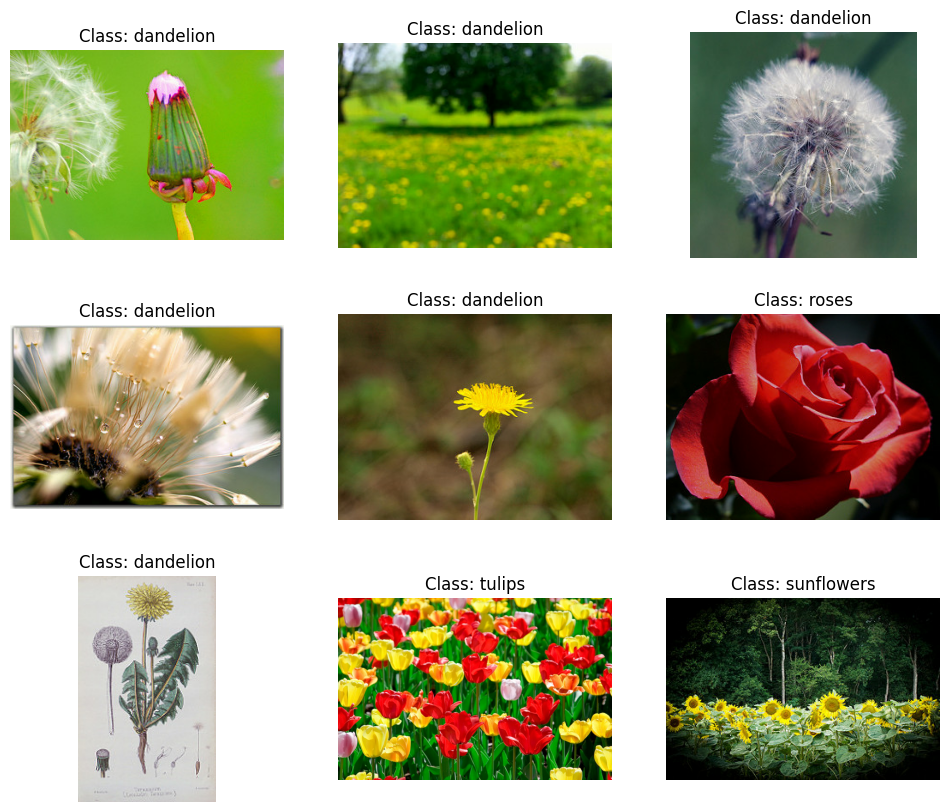

In [ ]:
plt.figure(figsize=(12, 10))
index = 0
for image, label in valid_set_raw.take(9):
    index += 1
    plt.subplot(3, 3, index)
    plt.imshow(image)
    plt.title(f"Class: {class_names[label]}")
    plt.axis("off")

### Preprocess data

In [ ]:
base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B2(weights="imagenet", include_top=False)

35839040/35839040 [==============================] - 0s 0us/step


In [ ]:
base_model.input # Base model already contain the scaling layer

<KerasTensor: shape=(None, None, None, 3) dtype=float32 (created by layer 'input_1')>

In [ ]:
batch_size = 32
resize = tf.keras.layers.Resizing(height=260, width=260, crop_to_aspect_ratio=True)
train_set = train_set_raw.map(lambda X, y: (resize(X), y))
train_set = train_set.shuffle(1000, seed=42).batch(batch_size).prefetch(1)
valid_set = valid_set_raw.map(lambda X, y: (resize(X), y)).batch(batch_size)
test_set = test_set_raw.map(lambda X, y: (resize(X), y)).batch(batch_size)

### Train with freezed weights

In [ ]:
avg = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
out = tf.keras.layers.Dense(n_classes, activation="softmax")(avg)
model = tf.keras.Model(inputs=base_model.input, outputs=out)

In [ ]:
for layer in base_model.layers:
    layer.trainable = False

In [ ]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.1, momentum=0.9)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
history = model.fit(train_set, validation_data=valid_set, epochs=5)

Epoch 1/5
86/86 [==============================] - 32s 194ms/step - loss: 0.4127 - accuracy: 0.8674 - val_loss: 0.3552 - val_accuracy: 0.8929
Epoch 2/5
86/86 [==============================] - 12s 132ms/step - loss: 0.2022 - accuracy: 0.9382 - val_loss: 0.3784 - val_accuracy: 0.9093
Epoch 3/5
86/86 [==============================] - 13s 143ms/step - loss: 0.1617 - accuracy: 0.9517 - val_loss: 0.2938 - val_accuracy: 0.9074
Epoch 4/5
86/86 [==============================] - 13s 137ms/step - loss: 0.1153 - accuracy: 0.9604 - val_loss: 0.3727 - val_accuracy: 0.9002
Epoch 5/5
86/86 [==============================] - 13s 140ms/step - loss: 0.0982 - accuracy: 0.9680 - val_loss: 0.3306 - val_accuracy: 0.9038


In [ ]:
model.save("freezed_flower_classifier")

### Fine-Tuning

In [ ]:
model = tf.keras.models.load_model("freezed_flower_classifier")

In [ ]:
len(model.layers)

351

In [ ]:
for row_indices in zip(range(70), range(70, 140), range(140, 210), range(210, 280), range(280, 350)):
    for row_idx in row_indices:
        print(f"{row_idx:3}: {model.layers[row_idx].name:30}", end="")
    print()

  0: input_1                        70: block4b_activation            140: block5c_expand_activation     210: block6a_project_bn            280: block6f_se_expand             
  1: rescaling                      71: block4b_se_squeeze            141: block5c_dwconv2               211: block6b_expand_conv           281: block6f_se_excite             
  2: normalization                  72: block4b_se_reshape            142: block5c_bn                    212: block6b_expand_bn             282: block6f_project_conv          
  3: stem_conv                      73: block4b_se_reduce             143: block5c_activation            213: block6b_expand_activation     283: block6f_project_bn            
  4: stem_bn                        74: block4b_se_expand             144: block5c_se_squeeze            214: block6b_dwconv2               284: block6f_drop                  
  5: stem_activation                75: block4b_se_excite             145: block5c_se_reshape            215: block6b_bn

In [ ]:
for layer in model.layers[198:]: # activate 6th block
    layer.trainable = True

In [ ]:
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
    './temp/checkpoint',
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=True,
    verbose=1
)
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
history = model.fit(train_set, validation_data=valid_set, epochs=10, callbacks=[checkpoint_cb])

Epoch 1/10
86/86 [==============================] - ETA: 0s - loss: 0.0591 - accuracy: 0.9829
Epoch 1: val_loss improved from inf to 0.19278, saving model to ./temp/checkpoint
86/86 [==============================] - 43s 242ms/step - loss: 0.0591 - accuracy: 0.9829 - val_loss: 0.1928 - val_accuracy: 0.9347
Epoch 2/10
86/86 [==============================] - ETA: 0s - loss: 0.0354 - accuracy: 0.9898
Epoch 2: val_loss improved from 0.19278 to 0.18994, saving model to ./temp/checkpoint
86/86 [==============================] - 20s 221ms/step - loss: 0.0354 - accuracy: 0.9898 - val_loss: 0.1899 - val_accuracy: 0.9347
Epoch 3/10
86/86 [==============================] - ETA: 0s - loss: 0.0182 - accuracy: 0.9945
Epoch 3: val_loss improved from 0.18994 to 0.18830, saving model to ./temp/checkpoint
86/86 [==============================] - 19s 212ms/step - loss: 0.0182 - accuracy: 0.9945 - val_loss: 0.1883 - val_accuracy: 0.9347
Epoch 4/10
86/86 [==============================] - ETA: 0s - loss: 

In [ ]:
model.load_weights("./temp/checkpoint")

In [ ]:
model.evaluate(test_set)

12/12 [==============================] - 4s 289ms/step - loss: 0.1719 - accuracy: 0.9564


[0.1719064712524414, 0.9564032554626465]

## Classification and Localization

- Localizing an object in a picture can be expressed as a regression task: to predict a bounding box around the object, a common approach is to predict the horizontal and vertical coordinates of the object’s center, as well as its height and width. This means we have four numbers to predict. It does not require much change to the model; we just need to add a second dense output layer with four units (typically on top of the global average pooling layer), and it can be trained using the MSE loss:

    ```python
    base_model = tf.keras.applications.xception.Xception(weights="imagenet",
                                                     include_top=False)
    avg = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
    class_output = tf.keras.layers.Dense(n_classes, activation="softmax")(avg)
    loc_output = tf.keras.layers.Dense(4)(avg)
    model = tf.keras.Model(inputs=base_model.input,
                       outputs=[class_output, loc_output])
    model.compile(loss=["sparse_categorical_crossentropy", "mse"],
              loss_weights=[0.8, 0.2],  # depends on what you care most about
              optimizer=optimizer, metrics=["accuracy"])
    ```

- You then need to create a dataset whose items will be batches of preprocessed images along with their class labels and their bounding boxes. Each item should be a tuple of the form `(images, (class_labels, bounding_boxes))`.

- The MSE often works fairly well as a cost function to train the model, but it is not a great metric to evaluate how well the model can predict bounding boxes. The most common metric for this is the intersection over union (IoU): the area of overlap between the predicted bounding box and the target bounding box, divided by the area of their union (see Figure 14-24). In Keras, it is implemented by the `tf.keras.metrics.MeanIoU` class.

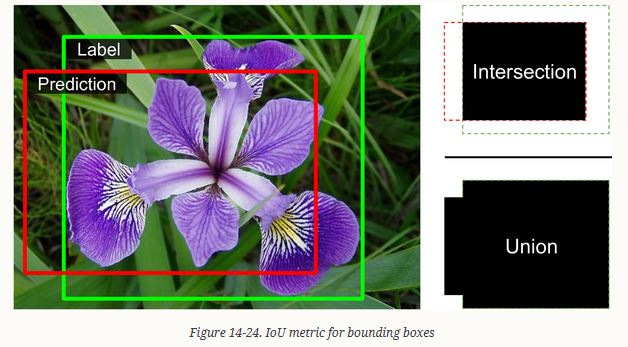

## Object Detection

- The task of classifying and localizing multiple objects in an image is called object detection. Until a few years ago, a common approach was to take a CNN that was trained to classify and locate a single object roughly centered in the image, then slide this CNN across the image and make predictions at each step. The CNN was generally trained to predict not only class probabilities and a bounding box, but also an objectness score: this is the estimated probability that the image does indeed contain an object centered near the middle. This is a binary classification output; it can be produced by a dense output layer with a single unit, using the sigmoid activation function and trained using the binary cross-entropy loss.

- Note: *Instead of an objectness score, a “no-object” class was sometimes added, but in general this did not work as well: the questions “Is an object present?” and “What type of object is it?” are best answered separately.*

- This sliding-CNN approach is illustrated in Figure 14-25. In this example, the image was chopped into a 5 × 7 grid, and we see a CNN—the thick black rectangle—sliding across all 3 × 3 regions and making predictions at each step.

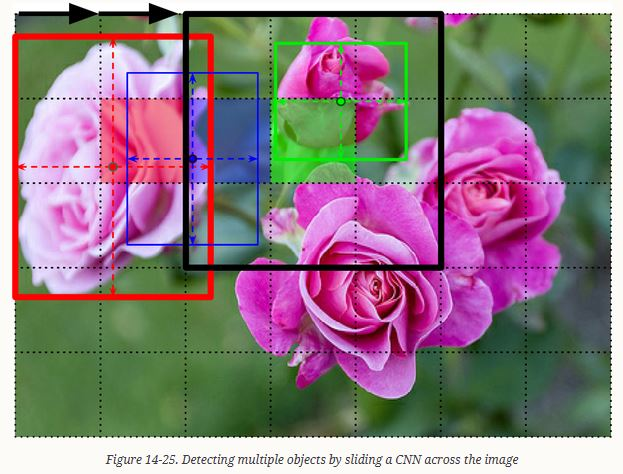

- In this figure, the CNN has already made predictions for three of these 3 × 3 regions:

 - When looking at the top-left 3 × 3 region (centered on the red-shaded grid cell located in the second row and second column), it detected the leftmost rose. Notice that the predicted bounding box exceeds the boundary of this 3 × 3 region. That’s absolutely fine: even though the CNN could not see the bottom part of the rose, it was able to make a reasonable guess as to where it might be. It also predicted class probabilities, giving a high probability to the “rose” class. Lastly, it predicted a fairly high objectness score, since the center of the bounding box lies within the central grid cell (in this figure, the objectness score is represented by the thickness of the bounding box).

 - When looking at the next 3 × 3 region, one grid cell to the right (centered on the shaded blue square), it did not detect any flower centered in that region, so it predicted a very low objectness score; therefore, the predicted bounding box and class probabilities can safely be ignored. You can see that the predicted bounding box was no good anyway.

 - finally, when looking at the next 3 × 3 region, again one grid cell to the right (centered on the shaded green cell), it detected the rose at the top, although not perfectly: this rose is not well centered within this region, so the predicted objectness score was not very high.

- You can imagine how sliding the CNN across the whole image would give you a total of 15 predicted bounding boxes, organized in a 3 × 5 grid, with each bounding box accompanied by its estimated class probabilities and objectness score. Since objects can have varying sizes, you may then want to slide the CNN again across larger 4 × 4 regions as well, to get even more bounding boxes.

 **Non-Max Suppression:**
- This technique is fairly straightforward, but as you can see it will often detect the same object multiple times, at slightly different positions. Some postprocessing is needed to get rid of all the unnecessary bounding boxes. A common approach for this is called non-max suppression. Here’s how it works:

 1. First, get rid of all the bounding boxes for which the objectness score is below some threshold: since the CNN believes there’s no object at that location, the bounding box is useless.

 2. Find the remaining bounding box with the highest objectness score, and get rid of all the other remaining bounding boxes that overlap a lot with it (e.g., with an IoU greater than 60%). For example, in Figure 14-25, the bounding box with the max objectness score is the thick bounding box over the leftmost rose. The other bounding box that touches this same rose overlaps a lot with the max bounding box, so we will get rid of it (although in this example it would already have been removed in the previous step).

 3. Repeat step 2 until there are no more bounding boxes to get rid of.

- This simple approach to object detection works pretty well, but it requires running the CNN many times (15 times in this example), so it is quite slow. Fortunately, there is a much faster way to slide a CNN across an image: using a fully convolutional network (FCN).

### YOLO

- It use Fully Convolutional Network (FCN) which replaces the output dense layer with the convolutional layer. FCN approach is much more efficient, since the network only looks at the image once.

- For example, suppose we’d already trained a CNN for flower classification and localization. It was trained on 224 × 224 images, and it outputs 10 numbers:

 - Outputs 0 to 4 are sent through the softmax activation function, and this gives the class probabilities (one per class).

 - Output 5 is sent through the sigmoid activation function, and this gives the objectness score.

 - Outputs 6 and 7 represent the bounding box’s center coordinates; they also go through a sigmoid activation function to ensure they range from 0 to 1.

 - Lastly, outputs 8 and 9 represent the bounding box’s height and width; they do not go through any activation function to allow the bounding boxes to extend beyond the borders of the image.

 We can now convert the CNN’s dense layers to convolutional layers. Suppose the last convolutional layer before the output layer (also called the bottleneck layer) outputs 7 × 7 feature maps when the network is fed a 224 × 224 image (see the left side of Figure 14-26). If we feed the FCN a 448 × 448 image (see the right side of Figure 14-26), the bottleneck layer will now output 14 × 14 feature maps. Since the dense output layer was replaced by a convolutional layer using 10 filters of size 7 × 7, with "valid" padding and stride 1, the output will be composed of 10 features maps, each of size 8 × 8 (since 14 – 7 + 1 = 8). In other words, the FCN will process the whole image only once, and it will output an 8 × 8 grid where each cell contains 10 numbers (5 class probabilities, 1 objectness score, and 4 bounding box coordinates). It’s exactly like taking the original CNN and sliding it across the image using 8 steps per row and 8 steps per column.



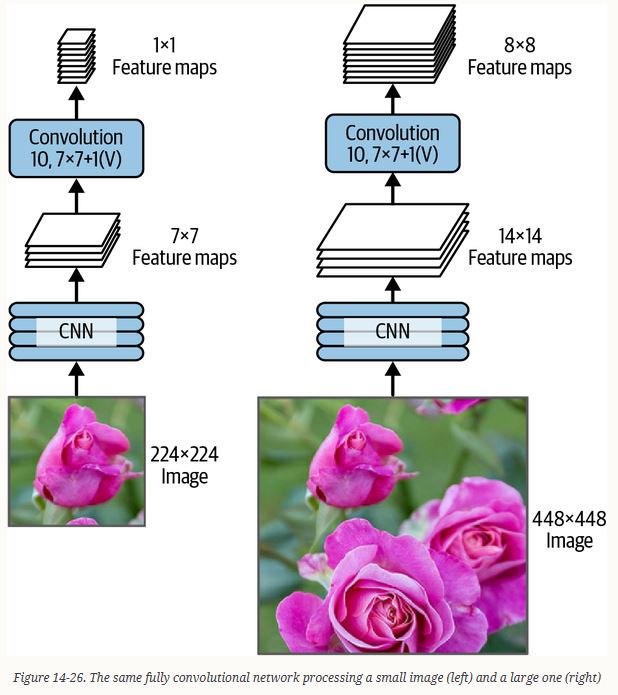

- For each grid cell, YOLO only considers objects whose bounding box center lies within that cell. The bounding box coordinates are relative to that cell, where (0, 0) means the top-left corner of the cell and (1, 1) means the bottom right. However, the bounding box’s height and width may extend well beyond the cell.

- It outputs two bounding boxes for each grid cell (instead of just one), which allows the model to handle cases where two objects are so close to each other that their bounding box centers lie within the same cell. Each bounding box also comes with its own objectness score.

- YOLO also outputs a class probability distribution for each grid cell, predicting 20 class probabilities per grid cell since YOLO was trained on the PASCAL VOC dataset, which contains 20 classes. This produces a coarse class probability map. Note that the model predicts one class probability distribution per grid cell, not per bounding box. However, it’s possible to estimate class probabilities for each bounding box during postprocessing, by measuring how well each bounding box matches each class in the class probability map. For example, imagine a picture of a person standing in front of a car. There will be two bounding boxes: one large horizontal one for the car, and a smaller vertical one for the person. These bounding boxes may have their centers within the same grid cell. So how can we tell which class should be assigned to each bounding box? Well, the class probability map will contain a large region where the “car” class is dominant, and inside it there will be a smaller region where the “person” class is dominant. Hopefully, the car’s bounding box will roughly match the “car” region, while the person’s bounding box will roughly match the “person” region: this will allow the correct class to be assigned to each bounding box.

- Each version brought some impressive improvements in speed and accuracy, using a variety of techniques; for example, YOLOv3 boosted accuracy in part thanks to anchor priors, exploiting the fact that some bounding box shapes are more likely than others, depending on the class (e.g., people tend to have vertical bounding boxes, while cars usually don’t). They also increased the number of bounding boxes per grid cell, they trained on different datasets with many more classes (up to 9,000 classes organized in a hierarchy in the case of YOLO9000), they added skip connections to recover some of the spatial resolution that is lost in the CNN (we will discuss this shortly, when we look at semantic segmentation), and much more. There are many variants of these models too, such as YOLOv4-tiny, which is optimized to be trained on less powerful machines and which can run extremely fast (at over 1,000 frames per second!), but with a slightly lower mean average precision (mAP).

- Many object detection models are available on TensorFlow Hub, often with pretrained weights, such as YOLOv5, SSD, Faster R-CNN, and EfficentDet.

So far, we’ve only considered detecting objects in single images. But what about videos? Objects must not only be detected in each frame, they must also be tracked over time. Let’s take a quick look at object tracking now.

## Object tracking:

- One of the most popular object tracking systems is DeepSORT. It is based on a combination of classical algorithms and deep learning:

 - It uses Kalman filters to estimate the most likely current position of an object given prior detections, and assuming that objects tend to move at a constant speed.

 - It uses a deep learning model to measure the resemblance between new detections and existing tracked objects.

 - Lastly, it uses the Hungarian algorithm to map new detections to existing tracked objects (or to new tracked objects): this algorithm efficiently finds the combination of mappings that minimizes the distance between the detections and the predicted positions of tracked objects, while also minimizing the appearance discrepancy.

- For example, imagine a red ball that just bounced off a blue ball traveling in the opposite direction. Based on the previous positions of the balls, the Kalman filter will predict that the balls will go through each other: indeed, it assumes that objects move at a constant speed, so it will not expect the bounce. If the Hungarian algorithm only considered positions, then it would happily map the new detections to the wrong balls, as if they had just gone through each other and swapped colors. But thanks to the resemblance measure, the Hungarian algorithm will notice the problem. Assuming the balls are not too similar, the algorithm will map the new detections to the correct balls.

## Semantic Segmentation

- In semantic segmentation, each pixel is classified according to the class of the object it belongs to (e.g., road, car, pedestrian, building, etc.), as shown in Figure 14-27. Note that different objects of the same class are not distinguished. For example, all the bicycles on the right side of the segmented image end up as one big lump of pixels. The main difficulty in this task is that when images go through a regular CNN, they gradually lose their spatial resolution (due to the layers with strides greater than 1); so, a regular CNN may end up knowing that there’s a person somewhere in the bottom left of the image, but it will not be much more precise than that.

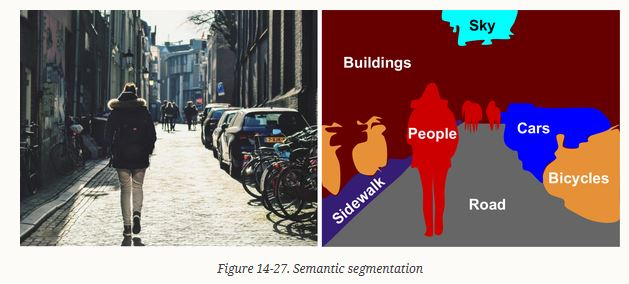

 - Just like for object detection, there are many different approaches to tackle this problem, some quite complex. However, a fairly simple solution was proposed in the 2015 paper by Jonathan Long et al. I mentioned earlier, on fully convolutional networks. The authors start by taking a pretrained CNN and turning it into an FCN. The CNN applies an overall stride of 32 to the input image (i.e., if you add up all the strides greater than 1), meaning the last layer outputs feature maps that are 32 times smaller than the input image. This is clearly too coarse, so they added a single upsampling layer that multiplies the resolution by 32.

- There are several solutions available for upsampling (increasing the size of an image), such as bilinear interpolation, but that only works reasonably well up to ×4 or ×8. Instead, they use a transposed convolutional layer: this is equivalent to first stretching the image by inserting empty rows and columns (full of zeros), then performing a regular convolution (see Figure 14-28). Alternatively, some people prefer to think of it as a regular convolutional layer that uses fractional strides (e.g., the stride is 1/2 in Figure 14-28). The transposed convolutional layer can be initialized to perform something close to linear interpolation, but since it is a trainable layer, it will learn to do better during training. In Keras, you can use the Conv2DTranspose layer.

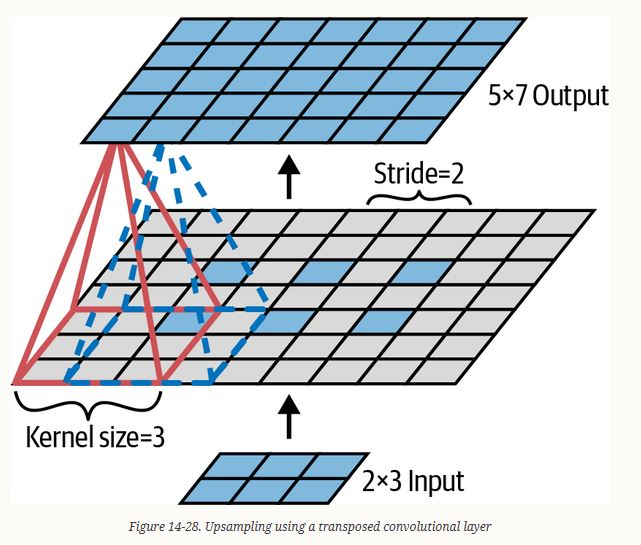

- Using transposed convolutional layers for upsampling is OK, but still too imprecise. To do better, Long et al. added skip connections from lower layers: for example, they upsampled the output image by a factor of 2 (instead of 32), and they added the output of a lower layer that had this double resolution. Then they upsampled the result by a factor of 16, leading to a total upsampling factor of 32 (see Figure 14-29). This recovered some of the spatial resolution that was lost in earlier pooling layers. In their best architecture, they used a second similar skip connection to recover even finer details from an even lower layer. In short, the output of the original CNN goes through the following extra steps: upsample ×2, add the output of a lower layer (of the appropriate scale), upsample ×2, add the output of an even lower layer, and finally upsample ×8. It is even possible to scale up beyond the size of the original image: this can be used to increase the resolution of an image, which is a technique called super-resolution.

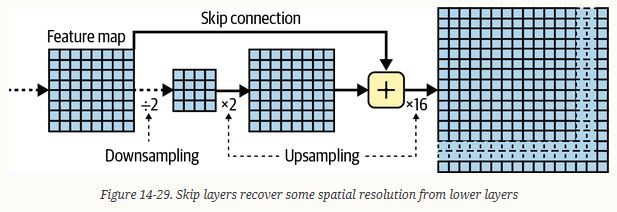

# RNN

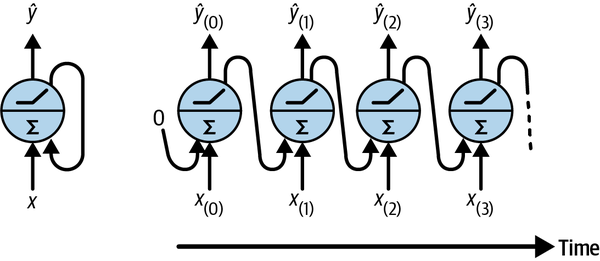

*Figure 15-1. A recurrent neuron (left) unrolled through time (right)*

- You can easily create a layer of recurrent neurons. At each time step t, every neuron receives both the input vector x(t) and the output vector from the previous time step ŷ(t–1), as shown in Figure 15-2.

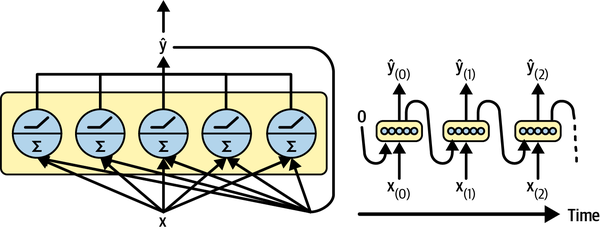

*Figure 15-2. A layer of recurrent neurons (left) unrolled through time (right)*

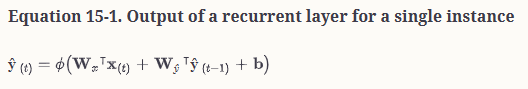

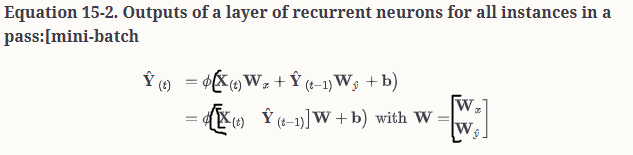

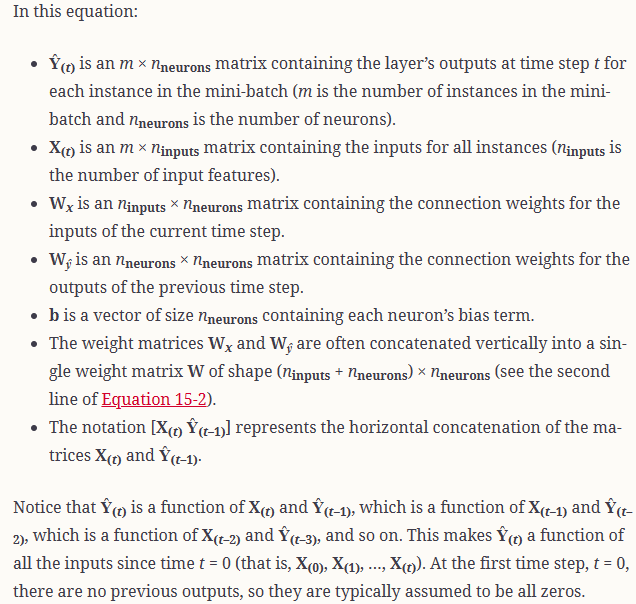

## Memory Cells

- Since the output of a recurrent neuron at time step t is a function of all the inputs from previous time steps, you could say it has a form of memory. A part of a neural network that preserves some state across time steps is called a memory cell (or simply a cell). A single recurrent neuron, or a layer of recurrent neurons, is a very basic cell, capable of learning only short patterns (typically about 10 steps long, but this varies depending on the task).

- 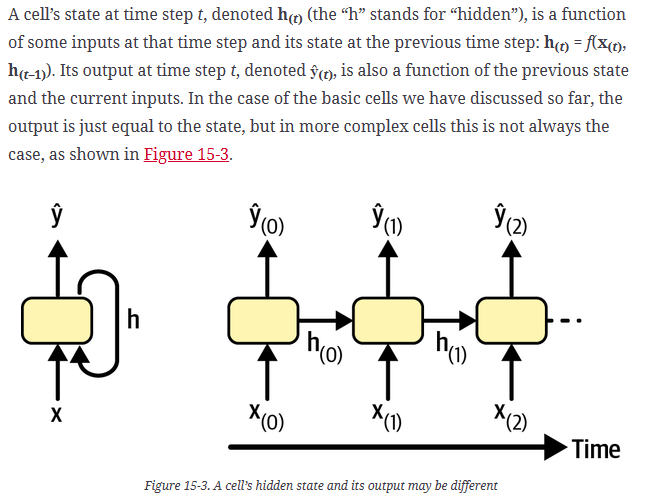

## Input and Output Sequences

- **sequence-to-sequence network:**
    
    An RNN can simultaneously take a sequence of inputs and produce a sequence of outputs (see the top-left network in Figure 15-4). This type of sequence-to-sequence network is useful to forecast time series, such as your home’s daily power consumption: you feed it the data over the last N days, and you train it to output the power consumption shifted by one day into the future (i.e., from N – 1 days ago to tomorrow).

- **sequence-to-vector network:**

    You could feed the network a sequence of inputs and ignore all outputs except for the last one (see the top-right network in Figure 15-4). This is a sequence-to-vector network. For example, you could feed the network a sequence of words corresponding to a movie review, and the network would output a sentiment score (e.g., from 0 [hate] to 1 [love]).

- **vector-to-sequence network:**

    Conversely, you could feed the network the same input vector over and over again at each time step and let it output a sequence (see the bottom-left network of Figure 15-4). This is a vector-to-sequence network. For example, the input could be an image (or the output of a CNN), and the output could be a caption for that image.

- **encoder-decoder:**

    Lastly, you could have a sequence-to-vector network, called an encoder, followed by a vector-to-sequence network, called a decoder (see the bottom-right network of Figure 15-4). For example, this could be used for translating a sentence from one language to another. You would feed the network a sentence in one language, the encoder would convert this sentence into a single vector representation, and then the decoder would decode this vector into a sentence in another language. This two-step model, called an encoder–decoder,⁠2 works much better than trying to translate on the fly with a single sequence-to-sequence RNN (like the one represented at the top left): the last words of a sentence can affect the first words of the translation, so you need to wait until you have seen the whole sentence before translating it.

- 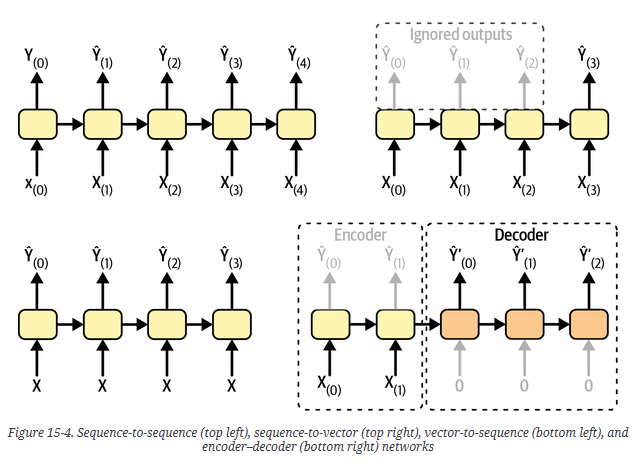

## Training RNN

To train an RNN, the trick is to unroll it through time (like we just did) and then use regular backpropagation (see Figure 15-5). This strategy is called backpropagation through time (BPTT).

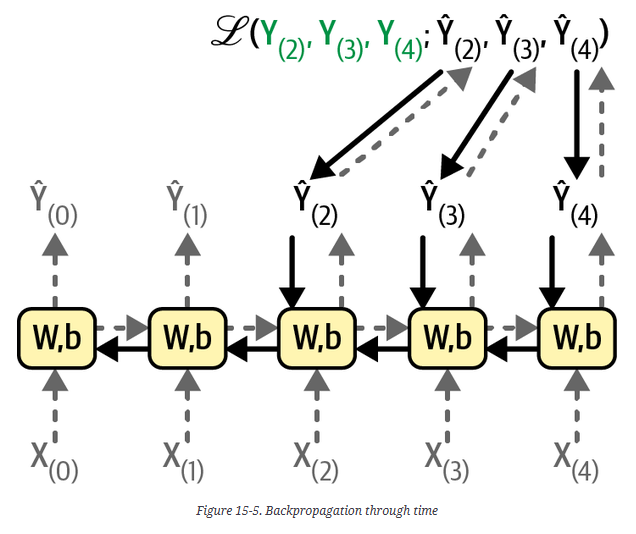

- Just like in regular backpropagation, there is a first forward pass through the unrolled network (represented by the dashed arrows). Then the output sequence is evaluated using a loss function ℒ(Y(0), Y(1), …​, Y(T); Ŷ(0), Ŷ(1), …​, Ŷ(T)) (where Y(i) is the ith target, Ŷ(i) is the ith prediction, and T is the max time step). Note that this loss function may ignore some outputs. For example, in a sequence-to-vector RNN, all outputs are ignored except for the very last one. In Figure 15-5, the loss function is computed based on the last three outputs only. The gradients of that loss function are then propagated backward through the unrolled network (represented by the solid arrows). In this example, since the outputs Ŷ(0) and Ŷ(1) are not used to compute the loss, the gradients do not flow backward through them; they only flow through Ŷ(2), Ŷ(3), and Ŷ(4). Moreover, since the same parameters W and b are used at each time step, their gradients will be tweaked multiple times during backprop. Once the backward phase is complete and all the gradients have been computed, BPTT can perform a gradient descent step to update the parameters (this is no different from regular backprop).

## Forecasting a Time Series

All right! Let’s pretend you’ve just been hired as a data scientist by Chicago’s Transit Authority. Your first task is to build a model capable of forecasting the number of passengers that will ride on bus and rail the next day. You have access to daily ridership data since 2001. Let’s walk through together how you would handle this. We’ll start by loading and cleaning up the data:

In [ ]:
import tensorflow as tf
tf.keras.utils.get_file(fname="ridership.tgz", origin="https://github.com/ageron/data/raw/main/ridership.tgz",
                        cache_dir="./", extract=True)

108512/108512 [==============================] - 0s 0us/step


'./datasets/ridership.tgz'

In [ ]:
import pandas as pd
df = pd.read_csv("datasets/ridership/CTA_-_Ridership_-_Daily_Boarding_Totals.csv", parse_dates=["service_date"])

In [ ]:
df.head()

service_date day_type     bus  rail_boardings  total_rides
0   2001-01-01        U  297192          126455       423647
1   2001-01-02        W  780827          501952      1282779
2   2001-01-03        W  824923          536432      1361355
3   2001-01-04        W  870021          550011      1420032
4   2001-01-05        W  890426          557917      1448343

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7701 entries, 0 to 7700
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   service_date    7701 non-null   datetime64[ns]
 1   day_type        7701 non-null   object        
 2   bus             7701 non-null   int64         
 3   rail_boardings  7701 non-null   int64         
 4   total_rides     7701 non-null   int64         
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 300.9+ KB


In [ ]:
df.columns = ["date", "day_type", "bus", "rail", "total"]
df = df.sort_values("date").set_index("date")
df = df.drop("total", axis=1)
df = df.drop_duplicates()

In [ ]:
df.head()

day_type     bus    rail
date                               
2001-01-01        U  297192  126455
2001-01-02        W  780827  501952
2001-01-03        W  824923  536432
2001-01-04        W  870021  550011
2001-01-05        W  890426  557917

In [ ]:
df.tail()

day_type     bus    rail
date                               
2021-11-26        W  257700  189694
2021-11-27        A  237839  187065
2021-11-28        U  184817  147830
2021-11-29        W  421322  276090
2021-11-30        W  450230  302349

- The day_type column contains W for Weekdays, A for Saturdays, and U for Sundays or holidays.

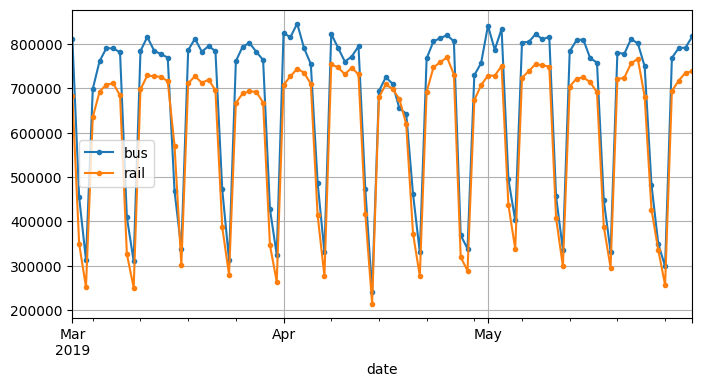

In [ ]:
df["2019-03": "2019-05"].plot(grid=True, figsize=(8, 4), marker=".");

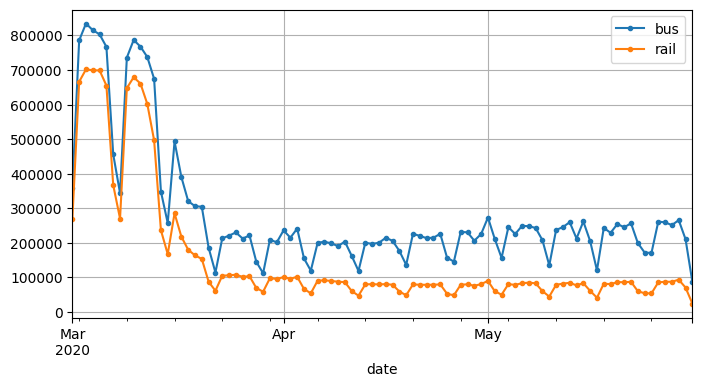

In [ ]:
df["2020-03": "2020-05"].plot(grid=True, figsize=(8, 4), marker=".");

- Since there are multiple values per time step, this is called a multivariate time series.
- We can see that a similar pattern is clearly repeated every week. This is called a weekly seasonality. In fact, it’s so strong in this case that forecasting tomorrow’s ridership by just copying the values from a week earlier will yield reasonably good results. This is called naive forecasting: simply copying a past value to make our forecast. Naive forecasting is often a great baseline, and it can even be tricky to beat in some cases.
- Note: In general, naive forecasting means copying the latest known value (e.g., forecasting that tomorrow will be the same as today). However, in our case, copying the value from the previous week works better, due to the strong weekly seasonality.

- To visualize these naive forecasts, let’s overlay the two time series (for bus and rail) as well as the same time series lagged by one week (i.e., shifted toward the right) using dotted lines.

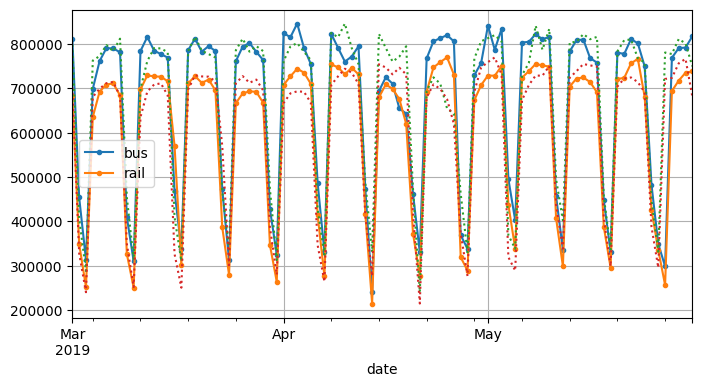

In [ ]:
ax = df["2019-03": "2019-05"].plot(grid=True, figsize=(8, 4), marker=".");
df.shift(7)["2019-03": "2019-05"].plot(grid=True, figsize=(8, 4), ls=":", ax=ax, legend=False);

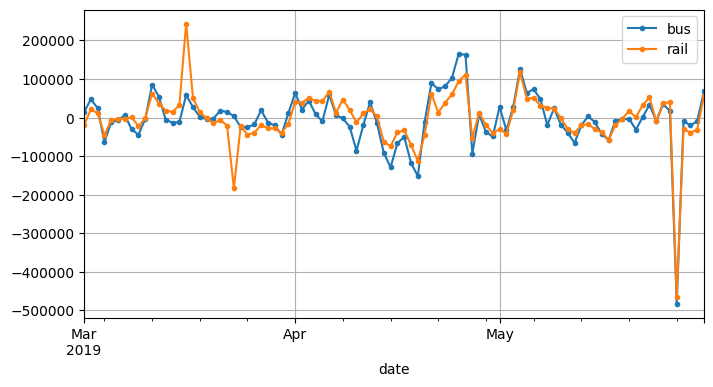

In [ ]:
diff_7 = df[["bus", "rail"]].diff(7)["2019-03": "2019-05"]
diff_7.plot(grid=True, figsize=(8, 4), marker=".");

- Not too bad! Notice how closely the lagged time series track the actual time series. When a time series is correlated with a lagged version of itself, we say that the time series is autocorrelated. As you can see, most of the differences are fairly small, except at the end of May. Maybe there was a holiday at that time? Let’s check the `day_type` column:

In [ ]:
df["day_type"]["2019-05-25": "2019-05-30"]

date
2019-05-25    A
2019-05-26    U
2019-05-27    U
2019-05-28    W
2019-05-29    W
2019-05-30    W
Name: day_type, dtype: object

- There is a holiday on Monday, 2019-05-27. That's why differce (True - Lag) is a large negative value.

- Let's find MAPE when predicting actual value using value a week before.

In [ ]:
AE = diff_7["2019-03": "2019-05"].abs()
MAE = AE.mean()
target = df[["bus", "rail"]]["2019-03": "2019-05"].abs()
APE = (AE / target) * 100
MAPE = APE.mean()

In [ ]:
MAE

bus     43915.608696
rail    42143.271739
dtype: float64

In [ ]:
MAPE

bus     8.293847
rail    8.994765
dtype: float64

- Let's check whether there is any monthly

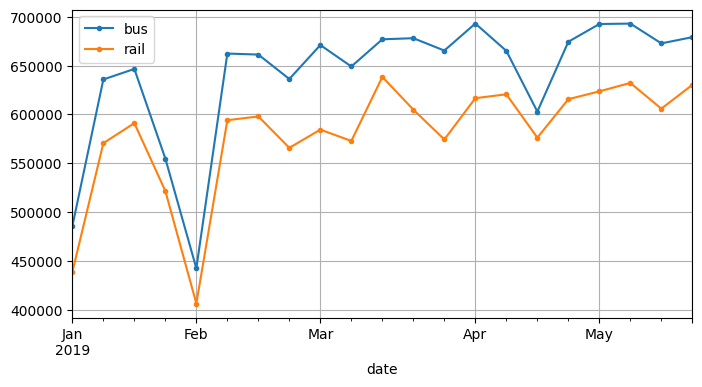

In [ ]:
df_weekly = df.resample("W").mean(numeric_only=True)
df_weekly["2019-01": "2019-5"].plot(grid=True, figsize=(8, 4), marker=".");

- There is no monthly seasonality. Now check yearly seasonality. To reduce the risk of data snooping, we’ll ignore more recent data for now. Let’s also plot a 12-month rolling average for each series to visualize long-term trends

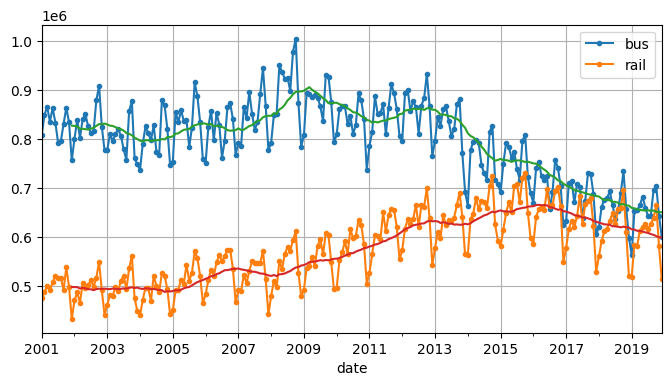

In [ ]:
df_monthly = df.resample("M").mean(numeric_only=True)
ax = df_monthly["2001": "2019"].plot(grid=True, figsize=(8, 4), marker=".");
df_monthly["2001": "2019"].rolling(window=12).mean().plot(ax=ax, grid=True, legend=False);

- Yep! There’s definitely some yearly seasonality as well, although it is noisier than the weekly seasonality, and more visible for the rail series than the bus series: we see peaks and troughs at roughly the same dates each year. Let’s check what we get if we plot the 12-month difference.

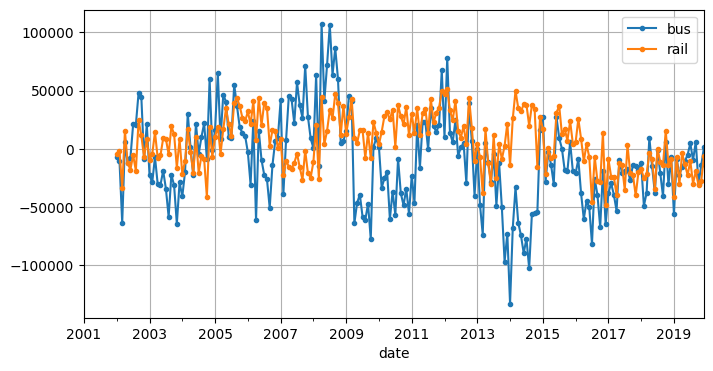

In [ ]:
df_monthly.diff(12)["2001": "2019"].plot(grid=True, figsize=(8, 4), marker=".");

- Notice how differencing not only removed the yearly seasonality, but it also removed the long-term trends. For example, the linear downward trend present in the time series from 2016 to 2019 became a roughly constant negative value in the differenced time series. In fact, differencing is a common technique used to remove trend and seasonality from a time series: it’s easier to study a stationary time series, meaning one whose statistical properties remain constant over time, without any seasonality or trends. Once you’re able to make accurate forecasts on the differenced time series, it’s easy to turn them into forecasts for the actual time series by just adding back the past values that were previously subtracted.


- You may be thinking that we’re only trying to predict tomorrow’s ridership, so the long-term patterns matter much less than the short-term ones. You’re right, but still, we may be able to improve performance slightly by taking long-term patterns into account. For example, daily bus ridership dropped by about 2,500 in October 2017, which represents about 570 fewer passengers each week, so if we were at the end of October 2017, it would make sense to forecast tomorrow’s ridership by copying the value from last week, minus 570. Accounting for the trend will make your forecasts a bit more accurate on average.

- let’s take a quick look at a very popular family of statistical models that are commonly used to analyze time series.

## The ARMA Model Family

- We’ll start with the autoregressive moving average (ARMA) model, developed by Herman Wold in the 1930s: it computes its forecasts using a simple weighted sum of lagged values and corrects these forecasts by adding a moving average, very much like we just discussed. Specifically, the moving average component is computed using a weighted sum of the last few forecast errors.

- 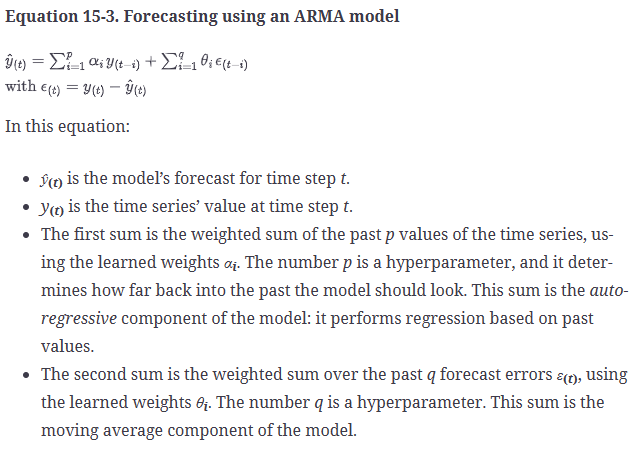

- Importantly, **this model assumes that the time series is stationary. If it is not, then differencing may help**. Using differencing over a single time step will produce an approximation of the derivative of the time series: indeed, it will give the slope of the series at each time step. This means that it will eliminate any linear trend, transforming it into a constant value. For example, if you apply one-step differencing to the series [3, 5, 7, 9, 11], you get the differenced series [2, 2, 2, 2].

- If the original time series has a quadratic trend instead of a linear trend, then a single round of differencing will not be enough. For example, the series [1, 4, 9, 16, 25, 36] becomes [3, 5, 7, 9, 11] after one round of differencing, but if you run differencing for a second round, then you get [2, 2, 2, 2]. So, running two rounds of differencing will eliminate quadratic trends. More generally, running d consecutive rounds of differencing computes an approximation of the dth order derivative of the time series, so it will eliminate polynomial trends up to degree d. This hyperparameter d is called the order of integration.

- Differencing is the central contribution of the autoregressive integrated moving average (ARIMA) model, introduced in 1970 by George Box and Gwilym Jenkins in their book Time Series Analysis (Wiley): this model runs d rounds of differencing to make the time series more stationary, then it applies a regular ARMA model. When making forecasts, it uses this ARMA model, then it adds back the terms that were subtracted by differencing.

- One last member of the ARMA family is the seasonal ARIMA (SARIMA) model: it models the time series in the same way as ARIMA, but it additionally models a seasonal component for a given frequency (e.g., weekly), using the exact same ARIMA approach. It has a total of seven hyperparameters: the same p, d, and q hyperparameters as ARIMA, plus additional P, D, and Q hyperparameters to model the seasonal pattern, and lastly the period of the seasonal pattern, noted s. The hyperparameters P, D, and Q are just like p, d, and q, but they are used to model the time series at t – s, t – 2s, t – 3s, etc.

- The MAE baseline of ARIMA is about 32,041 for rail. RNN beats ARIMA so let's just use it.



## Preparing the Data for Machine Learning Models

-  Our goal will be to forecast tomorrow’s ridership based on the ridership of the past 8 weeks of data (56 days). The inputs to our model will therefore be sequences (usually a single sequence per day once the model is in production), each containing 56 values from time steps t – 55 to t. For each input sequence, the model will output a single value: the forecast for time step t + 1.

- But what will we use as training data? Well, that’s the trick: we will use every 56-day window from the past as training data, and the target for each window will be the value immediately following it.

- Now, before we start training, we need to split our data into a training period, a validation period, and a test period. We will focus on the rail ridership for now. We will also scale it down by a factor of one million, to ensure the values are near the 0–1 range; this plays nicely with the default weight initialization and learning rate:

In [ ]:
rail_train = df["2016-01":"2018-12"]["rail"] / 1e6
rail_valid = df["2019-01":"2019-05"]["rail"] / 1e6
rail_test = df["2019-06":]["rail"] / 1e6

In [ ]:
seq_length = 56
train_ds = tf.keras.utils.timeseries_dataset_from_array(
    rail_train.to_numpy(),
    targets=rail_train[seq_length:],
    sequence_length=seq_length,
    batch_size=32,
    shuffle=True,
    seed=42
)
valid_ds = tf.keras.utils.timeseries_dataset_from_array(
    rail_valid.to_numpy(),
    targets=rail_valid[seq_length:],
    sequence_length=seq_length,
    batch_size=32
)

In [ ]:
for i in train_ds.take(1):
    print(i)

(<tf.Tensor: shape=(32, 56), dtype=float64, numpy=
array([[0.369396, 0.290753, 0.726945, ..., 0.71368 , 0.720369, 0.70129 ],
       [0.842885, 0.891357, 1.146516, ..., 0.131542, 0.292312, 0.490822],
       [0.723488, 0.748753, 0.754918, ..., 0.718317, 0.445798, 0.396317],
       ...,
       [0.460385, 0.357897, 0.748976, ..., 0.742502, 0.775495, 0.804635],
       [0.327173, 0.739174, 0.781301, ..., 0.821158, 0.815629, 0.416588],
       [0.402811, 0.816014, 0.826518, ..., 0.80725 , 0.721083, 0.474411]])>, <tf.Tensor: shape=(32,), dtype=float64, numpy=
array([0.449322, 0.537443, 0.744165, 0.668762, 0.71522 , 0.797545,
       0.751342, 0.320982, 0.813161, 0.332004, 0.689577, 0.690845,
       0.742215, 0.743427, 0.741459, 0.285153, 0.755604, 0.81009 ,
       0.73144 , 0.660176, 0.336441, 0.736966, 0.786422, 0.799529,
       0.692183, 0.832417, 0.292995, 0.329445, 0.65065 , 0.528345,
       0.334275, 0.338339])>)


## Forecasting Using a Simple RNN

In [ ]:
tf.keras.utils.set_random_seed(42)
model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(1, input_shape=[None, 1])
])

In [ ]:
model.summary()

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_25 (SimpleRNN)   (None, 1)                 3         
                                                                 
Total params: 3 (12.00 Byte)
Trainable params: 3 (12.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


- All recurrent layers in Keras expect 3D inputs of shape `[batch size, time steps, dimensionality]`, where dimensionality is 1 for univariate time series and more for multivariate time series. Recall that the input_shape argument ignores the first dimension (i.e., the batch size), and since recurrent layers can accept input sequences of any length, we can set the second dimension to None, which means “any size”. Lastly, since we’re dealing with a univariate time series, we need the last dimension’s size to be 1. This is why we specified the input shape [None, 1]: it means “univariate sequences of any length”. Note that the datasets actually contain inputs of shape `[batch size, time steps]`, so we’re missing the last dimension, of size 1, but Keras is kind enough to add it for us in this case.

- This model works exactly as we saw earlier: the initial state h(init) is set to 0, and it is passed to a single recurrent neuron, along with the value of the first time step, x(0). The neuron computes a weighted sum of these values plus the bias term, and it applies the activation function to the result, using the hyperbolic tangent function by default. The result is the first output, y0. In a simple RNN, this output is also the new state h0. This new state is passed to the same recurrent neuron along with the next input value, x(1), and the process is repeated until the last time step. At the end, the layer just outputs the last value: in our case the sequences are 56 steps long, so the last value is y55. All of this is performed simultaneously for every sequence in the batch, of which there are 32 in this case.

- It’s a sequence-to-vector model. Since there’s a single output neuron, the output vector has a size of 1.



In [ ]:
def fit_and_evaluate(model, train_set, valid_set, learning_rate, epochs=100):
    early_stopping_cb = tf.keras.callbacks.EarlyStopping(monitor="val_mae", patience=30, restore_best_weights=True)
    performance_sch_cb = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_mae', factor=0.1, patience=20, min_delta=0.0001)
    opt = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)
    model.compile(loss=tf.keras.losses.Huber(), optimizer=opt, metrics=["mae"])
    history = model.fit(train_set, validation_data=valid_set, epochs=epochs, callbacks=[early_stopping_cb, performance_sch_cb])
    valid_loss, valid_mae = model.evaluate(valid_set)
    return valid_mae * 1e6

In [ ]:
fit_and_evaluate(model, train_ds, valid_ds, learning_rate=0.1, epochs=100)

Epoch 1/100
33/33 [==============================] - 2s 24ms/step - loss: 0.0319 - mae: 0.1995 - val_loss: 0.0210 - val_mae: 0.1606 - lr: 0.1000
Epoch 2/100
33/33 [==============================] - 1s 15ms/step - loss: 0.0168 - mae: 0.1456 - val_loss: 0.0167 - val_mae: 0.1468 - lr: 0.1000
Epoch 3/100
33/33 [==============================] - 1s 17ms/step - loss: 0.0150 - mae: 0.1438 - val_loss: 0.0156 - val_mae: 0.1313 - lr: 0.1000
Epoch 4/100
33/33 [==============================] - 1s 26ms/step - loss: 0.0144 - mae: 0.1433 - val_loss: 0.0148 - val_mae: 0.1299 - lr: 0.1000
Epoch 5/100
33/33 [==============================] - 2s 50ms/step - loss: 0.0140 - mae: 0.1431 - val_loss: 0.0142 - val_mae: 0.1319 - lr: 0.1000
Epoch 6/100
33/33 [==============================] - 1s 37ms/step - loss: 0.0137 - mae: 0.1440 - val_loss: 0.0147 - val_mae: 0.1225 - lr: 0.1000
Epoch 7/100
33/33 [==============================] - 1s 24ms/step - loss: 0.0136 - mae: 0.1406 - val_loss: 0.0138 - val_mae: 0.126

102769.79207992554

- Its validation MAE is greater than 100,000! Ouch. It is worse than than trivial approach and ARIMA. That was to be expected, for two reasons:

    - The model only has a single recurrent neuron, so the only data it can use to make a prediction at each time step is the input value at the current time step and the output value from the previous time step. That’s not much to go on! In other words, the RNN’s memory is extremely limited: it’s just a single number, its previous output. And let’s count how many parameters this model has: since there’s just one recurrent neuron with only two input values, the whole model only has three parameters (two weights plus a bias term). That’s far from enough for this time series.

    - The time series contains values from 0 to about 1.4, but since the default activation function is tanh, the recurrent layer can only output values between –1 and +1. There’s no way it can predict values between 1.0 and 1.4.

- Let’s fix both of these issues: we will create a model with a larger recurrent layer, containing 32 recurrent neurons, and we will add a dense output layer on top of it with a single output neuron and no activation function. The recurrent layer will be able to carry much more information from one time step to the next, and the dense output layer will project the final output from 32 dimensions down to 1, without any value range constraints:

In [ ]:
tf.keras.utils.set_random_seed(42)
univar_model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(32, input_shape=[None, 1]),
    tf.keras.layers.Dense(1)
])

In [ ]:
fit_and_evaluate(univar_model, train_ds, valid_ds, learning_rate=0.05, epochs=100)

Epoch 1/100
33/33 [==============================] - 2s 24ms/step - loss: 0.0426 - mae: 0.2159 - val_loss: 0.0072 - val_mae: 0.0975 - lr: 0.0500
Epoch 2/100
33/33 [==============================] - 1s 20ms/step - loss: 0.0058 - mae: 0.0794 - val_loss: 0.0044 - val_mae: 0.0739 - lr: 0.0500
Epoch 3/100
33/33 [==============================] - 1s 17ms/step - loss: 0.0051 - mae: 0.0726 - val_loss: 0.0056 - val_mae: 0.0878 - lr: 0.0500
Epoch 4/100
33/33 [==============================] - 1s 17ms/step - loss: 0.0052 - mae: 0.0734 - val_loss: 0.0031 - val_mae: 0.0593 - lr: 0.0500
Epoch 5/100
33/33 [==============================] - 1s 16ms/step - loss: 0.0036 - mae: 0.0571 - val_loss: 0.0019 - val_mae: 0.0324 - lr: 0.0500
Epoch 6/100
33/33 [==============================] - 1s 16ms/step - loss: 0.0032 - mae: 0.0520 - val_loss: 0.0023 - val_mae: 0.0396 - lr: 0.0500
Epoch 7/100
33/33 [==============================] - 1s 19ms/step - loss: 0.0029 - mae: 0.0470 - val_loss: 0.0023 - val_mae: 0.042

29401.43272280693

- The MAE is 29,264 which is improvement over trivial approach and ARIMA.

## Forecasting Using a Deep RNN

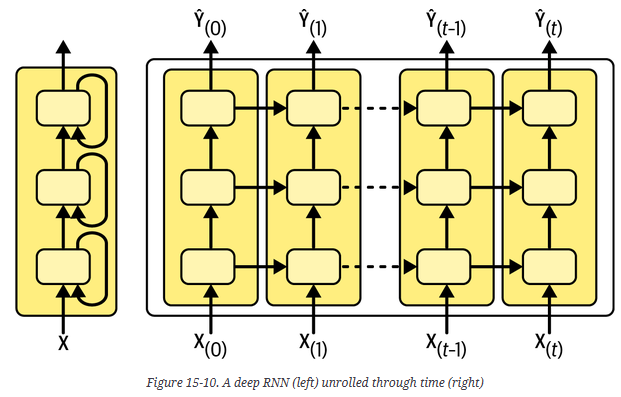

- Implementing a deep RNN with Keras is straightforward: just stack recurrent layers. In the following example, we use three SimpleRNN layers (but we could use any other type of recurrent layer instead, such as an LSTM layer or a GRU layer, which we will discuss shortly). The first two are sequence-to-sequence layers, and the last one is a sequence-to-vector layer. Finally, the Dense layer produces the model’s forecast (you can think of it as a vector-to-vector layer). So this model is just like the model represented in Figure 15-10, except the outputs Ŷ(0) to Ŷ(t–1) are ignored, and there’s a dense layer on top of Ŷ(t), which outputs the actual forecast:

In [ ]:
tf.keras.utils.set_random_seed(42)
deep_model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(32, return_sequences=True, input_shape=[None, 1]),
    tf.keras.layers.SimpleRNN(32, return_sequences=True),
    tf.keras.layers.SimpleRNN(32),
    tf.keras.layers.Dense(1)
])

In [ ]:
deep_model.summary()

Model: "sequential_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_33 (SimpleRNN)   (None, None, 32)          1088      
                                                                 
 simple_rnn_34 (SimpleRNN)   (None, None, 32)          2080      
                                                                 
 simple_rnn_35 (SimpleRNN)   (None, 32)                2080      
                                                                 
 dense_14 (Dense)            (None, 1)                 33        
                                                                 
Total params: 5281 (20.63 KB)
Trainable params: 5281 (20.63 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


- Make sure to set `return_sequences=True` for all recurrent layers (except the last one, if you only care about the last output). If you forget to set this parameter for one recurrent layer, it will output a 2D array containing only the output of the last time step, instead of a 3D array containing outputs for all time steps. The next recurrent layer will complain that you are not feeding it sequences in the expected 3D format.

In [ ]:
fit_and_evaluate(deep_model, train_ds, valid_ds, learning_rate=0.05, epochs=100)

Epoch 1/100
33/33 [==============================] - 5s 67ms/step - loss: 0.0817 - mae: 0.2999 - val_loss: 0.0322 - val_mae: 0.1830 - lr: 0.0500
Epoch 2/100
33/33 [==============================] - 1s 38ms/step - loss: 0.0211 - mae: 0.1692 - val_loss: 0.0435 - val_mae: 0.2374 - lr: 0.0500
Epoch 3/100
33/33 [==============================] - 1s 38ms/step - loss: 0.0249 - mae: 0.1813 - val_loss: 0.0622 - val_mae: 0.3070 - lr: 0.0500
Epoch 4/100
33/33 [==============================] - 1s 38ms/step - loss: 0.0216 - mae: 0.1745 - val_loss: 0.0536 - val_mae: 0.2798 - lr: 0.0500
Epoch 5/100
33/33 [==============================] - 1s 38ms/step - loss: 0.0226 - mae: 0.1736 - val_loss: 0.0300 - val_mae: 0.1918 - lr: 0.0500
Epoch 6/100
33/33 [==============================] - 1s 39ms/step - loss: 0.0145 - mae: 0.1285 - val_loss: 0.0104 - val_mae: 0.1229 - lr: 0.0500
Epoch 7/100
33/33 [==============================] - 2s 44ms/step - loss: 0.0081 - mae: 0.0942 - val_loss: 0.0030 - val_mae: 0.052

32277.59152650833

- It does not beat the shallow RNN.

## Forecasting Multivariate Time Series

- A great quality of neural networks is their flexibility: in particular, they can deal with multivariate time series with almost no change to their architecture. For example, let’s try to forecast the rail time series using both the bus and rail data as input. In fact, let’s also throw in the day type! Since we can always know in advance whether tomorrow is going to be a weekday, a weekend, or a holiday, we can shift the day type series one day into the future, so that the model is given tomorrow’s day type as input. For simplicity, we’ll do this processing using Pandas:

In [ ]:
df_mulvar = df[["bus", "rail"]] / 1e6
df_mulvar["next_day_type"] = df["day_type"].shift(-1)
df_mulvar = pd.get_dummies(df_mulvar)

In [ ]:
mulvar_train = df_mulvar["2016-01":"2018-12"]
mulvar_valid = df_mulvar["2019-01":"2019-05"]
mulvar_test = df_mulvar["2019-06":]

In [ ]:
mulvar_train.head()

bus      rail  next_day_type_A  next_day_type_U  \
date                                                               
2016-01-01  0.303321  0.319835                1                0   
2016-01-02  0.448859  0.365509                0                1   
2016-01-03  0.340540  0.287661                0                0   
2016-01-04  0.829429  0.703185                0                0   
2016-01-05  0.846789  0.727716                0                0   

            next_day_type_W  
date                         
2016-01-01                0  
2016-01-02                0  
2016-01-03                1  
2016-01-04                1  
2016-01-05                1

In [ ]:
# Forecasting only rail
tf.keras.utils.set_random_seed(42)

seq_length = 56
train_mulvar_ds = tf.keras.utils.timeseries_dataset_from_array(
    mulvar_train.to_numpy(),  # use all 5 columns as input
    targets=mulvar_train["rail"][seq_length:],  # forecast only the rail series
    sequence_length=seq_length,
    batch_size=32,
    shuffle=True,
    seed=42
)
valid_mulvar_ds = tf.keras.utils.timeseries_dataset_from_array(
    mulvar_valid.to_numpy(),
    targets=mulvar_valid["rail"][seq_length:],
    sequence_length=seq_length,
    batch_size=32
)

mulvar_model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(32, input_shape=[None, 5]),
    tf.keras.layers.Dense(1)
])

fit_and_evaluate(mulvar_model, train_mulvar_ds, valid_mulvar_ds, learning_rate=0.02, epochs=100)

Epoch 1/100
33/33 [==============================] - 2s 27ms/step - loss: 0.0161 - mae: 0.1236 - val_loss: 0.0071 - val_mae: 0.1005 - lr: 0.0200
Epoch 2/100
33/33 [==============================] - 1s 18ms/step - loss: 0.0045 - mae: 0.0674 - val_loss: 0.0011 - val_mae: 0.0359 - lr: 0.0200
Epoch 3/100
33/33 [==============================] - 1s 29ms/step - loss: 0.0030 - mae: 0.0516 - val_loss: 9.0224e-04 - val_mae: 0.0323 - lr: 0.0200
Epoch 4/100
33/33 [==============================] - 1s 24ms/step - loss: 0.0025 - mae: 0.0485 - val_loss: 0.0016 - val_mae: 0.0457 - lr: 0.0200
Epoch 5/100
33/33 [==============================] - 1s 18ms/step - loss: 0.0022 - mae: 0.0441 - val_loss: 0.0014 - val_mae: 0.0419 - lr: 0.0200
Epoch 6/100
33/33 [==============================] - 1s 29ms/step - loss: 0.0020 - mae: 0.0434 - val_loss: 8.2697e-04 - val_mae: 0.0305 - lr: 0.0200
Epoch 7/100
33/33 [==============================] - 2s 44ms/step - loss: 0.0017 - mae: 0.0395 - val_loss: 7.3941e-04 - va

22753.24799120426

- MAE of 22,753 is better than any othe model.

- In fact, it’s not too hard to make the RNN forecast both the bus and rail ridership. You just need to change the targets when creating the datasets, setting them to `mulvar_train[["bus", "rail"]][seq_length:]` for the training set, and `mulvar_valid[["bus", "rail"]][seq_length:]` for the validation set. You must also add an extra neuron in the output Dense layer, since it must now make two forecasts: one for tomorrow’s bus ridership, and the other for rail. That’s all there is to it!

In [ ]:
# Forecasting both rail and bus
tf.keras.utils.set_random_seed(42)
seq_length = 56

train_multask_ds = tf.keras.utils.timeseries_dataset_from_array(
    mulvar_train.to_numpy(),
    targets=mulvar_train[["bus", "rail"]][seq_length:],  # 2 targets per day
    sequence_length=seq_length,
    batch_size=32,
    shuffle=True,
    seed=42
)
valid_multask_ds = tf.keras.utils.timeseries_dataset_from_array(
    mulvar_valid.to_numpy(),
    targets=mulvar_valid[["bus", "rail"]][seq_length:],
    sequence_length=seq_length,
    batch_size=32
)

tf.random.set_seed(42)
multask_model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(32, input_shape=[None, 5]),
    tf.keras.layers.Dense(2)
])

fit_and_evaluate(multask_model, train_multask_ds, valid_multask_ds,
                 learning_rate=0.02)

Epoch 1/100
33/33 [==============================] - 4s 25ms/step - loss: 0.0583 - mae: 0.2276 - val_loss: 0.0025 - val_mae: 0.0455 - lr: 0.0200
Epoch 2/100
33/33 [==============================] - 1s 17ms/step - loss: 0.0040 - mae: 0.0621 - val_loss: 0.0024 - val_mae: 0.0516 - lr: 0.0200
Epoch 3/100
33/33 [==============================] - 1s 17ms/step - loss: 0.0030 - mae: 0.0514 - val_loss: 0.0017 - val_mae: 0.0413 - lr: 0.0200
Epoch 4/100
33/33 [==============================] - 1s 16ms/step - loss: 0.0026 - mae: 0.0491 - val_loss: 0.0022 - val_mae: 0.0531 - lr: 0.0200
Epoch 5/100
33/33 [==============================] - 1s 17ms/step - loss: 0.0025 - mae: 0.0483 - val_loss: 0.0013 - val_mae: 0.0374 - lr: 0.0200
Epoch 6/100
33/33 [==============================] - 1s 27ms/step - loss: 0.0023 - mae: 0.0463 - val_loss: 0.0014 - val_mae: 0.0398 - lr: 0.0200
Epoch 7/100
33/33 [==============================] - 1s 40ms/step - loss: 0.0022 - mae: 0.0462 - val_loss: 0.0012 - val_mae: 0.036

27492.305263876915

In [ ]:
pred = multask_model.predict(valid_multask_ds)
pred_bus = pred[:, 0]
pred_rail = pred[:, 1]
true_bus = mulvar_valid["bus"][seq_length:]
true_rail = mulvar_valid["rail"][seq_length:]
mae_bus = 1e6 * tf.keras.metrics.mean_absolute_error(true_bus, pred_bus)
mae_rail = 1e6 * tf.keras.metrics.mean_absolute_error(true_rail, pred_rail)

3/3 [==============================] - 0s 14ms/step


In [ ]:
mae_bus, mae_rail

(<tf.Tensor: shape=(), dtype=float32, numpy=26898.768>,
 <tf.Tensor: shape=(), dtype=float32, numpy=28085.84>)

- Using a single model for multiple related tasks often results in better performance than using a separate model for each task, since features learned for one task may be useful for the other tasks, and also because having to perform well across multiple tasks prevents the model from overfitting (it’s a form of regularization). However, it depends on the task, and in this particular case the multitask RNN that forecasts both the bus and the rail ridership doesn’t perform quite as well as dedicated models that forecast one or the other (using all five columns as input)

## Forecasting Several Time Steps Ahead

-  Train an RNN to predict the next 14 values in one shot. We can still use a sequence-to-vector model, but it will output 14 values instead of 1. However, we first need to change the targets to be vectors containing the next 14 values. To do this, we can use `timeseries_dataset_from_array()` again, but this time asking it to create datasets without targets (targets=None) and with longer sequences, of length `seq_length + 14`. Then we can use the datasets’ `map()` method to apply a custom function to each batch of sequences, splitting them into inputs and targets. In this example, we use the multivariate time series as input (using all five columns), and we forecast the rail ridership for the next 14 days:

In [ ]:
tf.keras.utils.set_random_seed(42)
seq_length = 56
ahead = 14
batch_size = 32

def split_inputs_and_targets(mulvar_seq_batch, ahead=ahead, target_col=1):
    return (mulvar_seq_batch[:, :-ahead], mulvar_seq_batch[:, -ahead:, target_col])

ahead_train_ds = tf.keras.utils.timeseries_dataset_from_array(
    mulvar_train.to_numpy(),
    targets = None,
    sequence_length = seq_length + ahead,
    batch_size = batch_size,
    shuffle = True,
    seed = 42
).map(split_inputs_and_targets)

ahead_valid_ds = tf.keras.utils.timeseries_dataset_from_array(
    mulvar_valid.to_numpy(),
    targets = None,
    sequence_length = seq_length + ahead,
    batch_size = batch_size,
).map(split_inputs_and_targets)

ahead_model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(32, input_shape=[None, 5]),
    tf.keras.layers.Dense(14)
])

In [ ]:
fit_and_evaluate(ahead_model, ahead_train_ds, ahead_valid_ds,
                 learning_rate=0.02, epochs=200)

Epoch 1/200
33/33 [==============================] - 2s 20ms/step - loss: 0.1222 - mae: 0.3809 - val_loss: 0.0314 - val_mae: 0.2018 - lr: 0.0200
Epoch 2/200
33/33 [==============================] - 0s 12ms/step - loss: 0.0222 - mae: 0.1682 - val_loss: 0.0158 - val_mae: 0.1370 - lr: 0.0200
Epoch 3/200
33/33 [==============================] - 0s 13ms/step - loss: 0.0145 - mae: 0.1352 - val_loss: 0.0115 - val_mae: 0.1175 - lr: 0.0200
Epoch 4/200
33/33 [==============================] - 0s 12ms/step - loss: 0.0118 - mae: 0.1214 - val_loss: 0.0092 - val_mae: 0.1056 - lr: 0.0200
Epoch 5/200
33/33 [==============================] - 0s 12ms/step - loss: 0.0100 - mae: 0.1116 - val_loss: 0.0078 - val_mae: 0.0968 - lr: 0.0200
Epoch 6/200
33/33 [==============================] - 1s 20ms/step - loss: 0.0087 - mae: 0.1027 - val_loss: 0.0063 - val_mae: 0.0885 - lr: 0.0200
Epoch 7/200
33/33 [==============================] - 1s 21ms/step - loss: 0.0077 - mae: 0.0956 - val_loss: 0.0054 - val_mae: 0.081

36000.90369582176

In [ ]:
Y_pred_valid = ahead_model.predict(ahead_valid_ds) # only final forecasts [82, 14]
true_ds = ahead_valid_ds.map(lambda x,y: y).interleave(tf.data.Dataset.from_tensor_slices, cycle_length=1)
true = np.array(list(true_ds)) # [82, 14]
maes = np.abs(true - Y_pred_valid).mean(axis=0) * 1e6
for ahead in range(14):
    print(f"MAE for +{ahead + 1}: {maes[ahead]:,.0f}")

3/3 [==============================] - 0s 8ms/step
MAE for +1: 29,218
MAE for +2: 30,520
MAE for +3: 37,297
MAE for +4: 41,522
MAE for +5: 32,780
MAE for +6: 35,756
MAE for +7: 39,041
MAE for +8: 35,932
MAE for +9: 32,578
MAE for +10: 35,680
MAE for +11: 39,286
MAE for +12: 39,301
MAE for +13: 38,872
MAE for +14: 36,229


## Forecasting Using a Sequence-to-Sequence Model

- Instead of training the model to forecast the next 14 values only at the very last time step, we can train it to forecast the next 14 values at each and every time step. In other words, we can turn this sequence-to-vector RNN into a sequence-to-sequence RNN. The advantage of this technique is that the loss will contain a term for the output of the RNN at each and every time step, not just for the output at the last time step.

- This means there will be many more error gradients flowing through the model, and they won’t have to flow through time as much since they will come from the output of each time step, not just the last one. This will both stabilize and speed up training.

- To be clear, at time step 0 the model will output a vector containing the forecasts for time steps 1 to 14, then at time step 1 the model will forecast time steps 2 to 15, and so on. In other words, the targets are sequences of consecutive windows, shifted by one time step at each time step. The target is not a vector anymore, but a sequence of the same length as the inputs, containing a 14-dimensional vector at each step.

- Preparing the datasets is not trivial, since each instance has a window as input and a sequence of windows as output. One way to do this is to use the `to_windows()` twice in a row, to get windows of consecutive windows.

In [ ]:
def to_windows(dataset, length):
    dataset = dataset.window(length, shift=1, drop_remainder=True)
    # window creates nested dataset of windows represented as datasets so interleave
    return dataset.flat_map(lambda x: x.batch(length))

In [ ]:
# Creating windows, each representing input sequence
my_series = tf.data.Dataset.range(7)
dataset = to_windows(my_series, 3)
list(dataset)

[<tf.Tensor: shape=(3,), dtype=int64, numpy=array([0, 1, 2])>,
 <tf.Tensor: shape=(3,), dtype=int64, numpy=array([1, 2, 3])>,
 <tf.Tensor: shape=(3,), dtype=int64, numpy=array([2, 3, 4])>,
 <tf.Tensor: shape=(3,), dtype=int64, numpy=array([3, 4, 5])>,
 <tf.Tensor: shape=(3,), dtype=int64, numpy=array([4, 5, 6])>]

In [ ]:
# Creating windows of windows
dataset = to_windows(dataset, 4)
list(dataset)

[<tf.Tensor: shape=(4, 3), dtype=int64, numpy=
 array([[0, 1, 2],
        [1, 2, 3],
        [2, 3, 4],
        [3, 4, 5]])>,
 <tf.Tensor: shape=(4, 3), dtype=int64, numpy=
 array([[1, 2, 3],
        [2, 3, 4],
        [3, 4, 5],
        [4, 5, 6]])>]

In [ ]:
# split these windows of windows into inputs and targets
dataset = dataset.map(lambda x: (x[:, 0], x[:, 1:]))
list(dataset)
# For each input sequence, the output is sequence of windows representing future forecasts

[(<tf.Tensor: shape=(4,), dtype=int64, numpy=array([0, 1, 2, 3])>,
  <tf.Tensor: shape=(4, 2), dtype=int64, numpy=
  array([[1, 2],
         [2, 3],
         [3, 4],
         [4, 5]])>),
 (<tf.Tensor: shape=(4,), dtype=int64, numpy=array([1, 2, 3, 4])>,
  <tf.Tensor: shape=(4, 2), dtype=int64, numpy=
  array([[2, 3],
         [3, 4],
         [4, 5],
         [5, 6]])>)]

- Now the dataset contains sequences of length 4 as inputs, and the targets are sequences containing the next two steps, for each time step. For example, the first input sequence is [0, 1, 2, 3], and its corresponding targets are [[1, 2], [2, 3], [3, 4], [4, 5]], which are the next two values for each time step.

In [ ]:
# Combining all
def to_seq2seq_dataset(series, ahead=14, seq_length=56, target_col=1, batch_size=32, shuffle=False, seed=None):
    ds = to_windows(tf.data.Dataset.from_tensor_slices(series), ahead + 1) # 2D sequences
    ds = to_windows(ds, seq_length).map(lambda x: (x[:, 0], x[:, 1:, target_col]))
    if shuffle:
        ds = ds.shuffle(8 * batch_size, seed=seed)
    return ds.batch(batch_size)

In [ ]:
seq2seq_train = to_seq2seq_dataset(mulvar_train, shuffle=True, seed=42)
seq2seq_valid = to_seq2seq_dataset(mulvar_valid)

In [ ]:
for x,y in seq2seq_train.take(1):
    print(x.shape, y.shape)

(32, 56, 5) (32, 56, 14)


In [ ]:
tf.random.set_seed(42)
seq2seq_model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(32, return_sequences=True, input_shape=[None, 5]),
    tf.keras.layers.Dense(14)
    # also equivalent: tf.keras.layers.Conv1D(14, kernel_size=1)
])
seq2seq_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, None, 32)          1216      
                                                                 
 dense (Dense)               (None, None, 14)          462       
                                                                 
Total params: 1678 (6.55 KB)
Trainable params: 1678 (6.55 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


- It is almost identical to our previous model: the only difference is that we set return_sequences=True in the SimpleRNN layer. This way, it will output a sequence of vectors (each of size 32), instead of outputting a single vector at the last time step. The Dense layer is smart enough to handle sequences as input: it will be applied at each time step, taking a 32-dimensional vector as input and outputting a 14-dimensional vector. In fact, another way to get the exact same result is to use a Conv1D layer with a kernel size of 1: Conv1D(14, kernel_size=1)

In [ ]:
fit_and_evaluate(seq2seq_model, seq2seq_train, seq2seq_valid,
                 learning_rate=0.5)

Epoch 1/100
33/33 [==============================] - 3s 45ms/step - loss: 0.0036 - mae: 0.0536 - val_loss: 0.0039 - val_mae: 0.0527 - lr: 0.5000
Epoch 2/100
33/33 [==============================] - 1s 19ms/step - loss: 0.0036 - mae: 0.0530 - val_loss: 0.0043 - val_mae: 0.0594 - lr: 0.5000
Epoch 3/100
33/33 [==============================] - 1s 19ms/step - loss: 0.0037 - mae: 0.0547 - val_loss: 0.0039 - val_mae: 0.0540 - lr: 0.5000
Epoch 4/100
33/33 [==============================] - 1s 23ms/step - loss: 0.0037 - mae: 0.0554 - val_loss: 0.0035 - val_mae: 0.0476 - lr: 0.5000
Epoch 5/100
33/33 [==============================] - 1s 34ms/step - loss: 0.0037 - mae: 0.0546 - val_loss: 0.0036 - val_mae: 0.0483 - lr: 0.5000
Epoch 6/100
33/33 [==============================] - 1s 18ms/step - loss: 0.0036 - mae: 0.0526 - val_loss: 0.0035 - val_mae: 0.0471 - lr: 0.5000
Epoch 7/100
33/33 [==============================] - 1s 21ms/step - loss: 0.0035 - mae: 0.0529 - val_loss: 0.0043 - val_mae: 0.059

46764.5563185215

In [ ]:
Y_pred_valid = seq2seq_model.predict(seq2seq_valid)[:, -1, :] # only final forecasts [82, 14]
true_ds = seq2seq_valid.map(lambda x,y: y[:, -1, :]).interleave(tf.data.Dataset.from_tensor_slices, cycle_length=1)
true = np.array(list(true_ds)) # [82, 14]
maes = np.abs(true - Y_pred_valid).mean(axis=0) * 1e6
for ahead in range(14):
    print(f"MAE for +{ahead + 1}: {maes[ahead]:,.0f}")

3/3 [==============================] - 18s 16ms/step
MAE for +1: 27,735
MAE for +2: 31,712
MAE for +3: 30,191
MAE for +4: 33,555
MAE for +5: 29,563
MAE for +6: 31,643
MAE for +7: 32,962
MAE for +8: 33,357
MAE for +9: 32,272
MAE for +10: 35,990
MAE for +11: 37,341
MAE for +12: 37,068
MAE for +13: 38,092
MAE for +14: 35,606


## Handling Long Sequences

- To train an RNN on long sequences, we must run it over many time steps, making the unrolled RNN a very deep network. Just like any deep neural network it may suffer from the unstable gradients problem, discussed in Chapter 11: it may take forever to train, or training may be unstable. Moreover, when an RNN processes a long sequence, it will gradually forget the first inputs in the sequence. Let’s look at both these problems, starting with the unstable gradients problem.

### Fighting the Unstable Gradients Problem

- Many of the tricks we used in deep nets to alleviate the unstable gradients problem can also be used for RNNs: good parameter initialization, faster optimizers, dropout, and so on. However, nonsaturating activation functions (e.g., ReLU) may not help as much here. In fact, they may actually lead the RNN to be even more unstable during training. Why? Well, suppose gradient descent updates the weights in a way that increases the outputs slightly at the first time step. Because the same weights are used at every time step, the outputs at the second time step may also be slightly increased, and those at the third, and so on until the outputs explode—and a nonsaturating activation function does not prevent that.

 You can reduce this risk by using a smaller learning rate, or you can use a saturating activation function like the hyperbolic tangent (this explains why it’s the default).

- Moreover, batch normalization cannot be used as efficiently with RNNs as with deep feedforward nets. In fact, you cannot use it between time steps, only between recurrent layers.

 To be more precise, it is technically possible to add a BN layer to a memory cell (as you will see shortly) so that it will be applied at each time step (both on the inputs for that time step and on the hidden state from the previous step). However, the same BN layer will be used at each time step, with the same parameters, regardless of the actual scale and offset of the inputs and hidden state. In practice, this does not yield good results

- Another form of normalization often works better with RNNs: layer normalization. It is very similar to batch normalization, but instead of normalizing across the batch dimension, layer normalization normalizes across the features dimension.

- Most recurrent layers and cells provided by Keras have `dropout` and `recurrent_dropout` hyperparameters: the former defines the dropout rate to apply to the inputs, and the latter defines the dropout rate for the hidden states, between time steps.

### Tackling the Short-Term Memory Problem

- Due to the transformations that the data goes through when traversing an RNN, some information is lost at each time step. After a while, the RNN’s state contains virtually no trace of the first inputs. This can be a showstopper. Imagine Dory the fish trying to translate a long sentence; by the time she’s finished reading it, she has no clue how it started. To tackle this problem, various types of cells with long-term memory have been introduced.

## LSTM cells

- The long short-term memory (LSTM) cell can be used very much like a basic cell, except it will perform much better; training will converge faster, and it will detect longer-term patterns in the data.

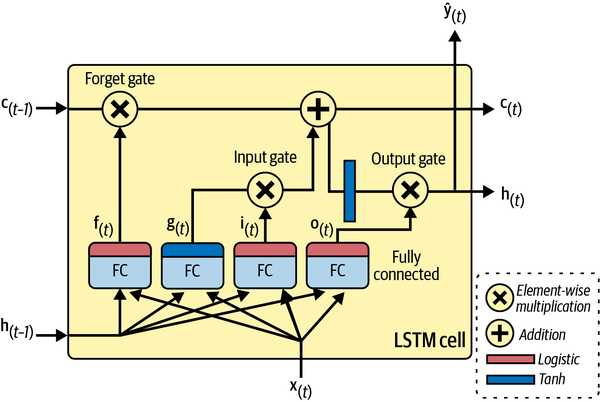

- The LSTM cell looks exactly like a regular cell, except that its state is split into two vectors: h(t) and c(t) (“c” stands for “cell”). You can think of h(t) as the short-term state and c(t) as the long-term state.

- First, the current input vector x(t) and the previous short-term state h(t–1) are fed to four different fully connected layers. They all serve a different purpose:

 - The main layer is the one that outputs g(t). It has the usual role of analyzing the current inputs x(t) and the previous (short-term) state h(t–1). In a basic cell, there is nothing other than this layer, and its output goes straight out to y(t) and h(t). But in an LSTM cell, this layer’s output does not go straight out; instead its most important parts are stored in the long-term state (and the rest is dropped).

 - The three other layers are gate controllers. Since they use the logistic activation function, the outputs range from 0 to 1. As you can see, the gate controllers’ outputs are fed to element-wise multiplication operations: if they output 0s they close the gate, and if they output 1s they open it. Specifically:

   - The forget gate (controlled by f(t)) controls which parts of the long-term state should be erased.

   - The input gate (controlled by i(t)) controls which parts of g(t) should be added to the long-term state.

   - Finally, the output gate (controlled by o(t)) controls which parts of the long-term state should be read and output at this time step, both to h(t) and to y(t).

- In short, an LSTM cell can learn to recognize an important input (that’s the role of the input gate), store it in the long-term state, preserve it for as long as it is needed (that’s the role of the forget gate), and extract it whenever it is needed. This explains why these cells have been amazingly successful at capturing long-term patterns in time series, long texts, audio recordings, and more.

- 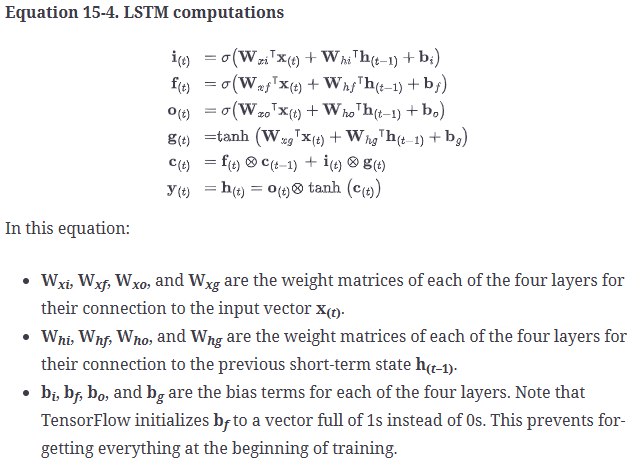

## GRU cells

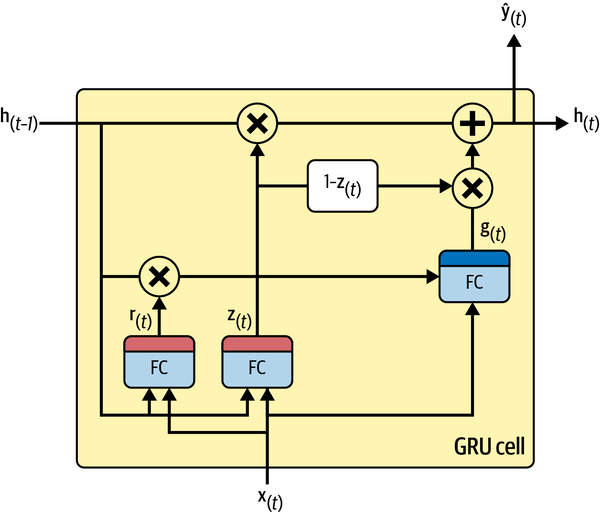

- The GRU cell is a simplified version of the LSTM cell, and it seems to perform just as well (which explains its growing popularity). These are the main simplifications:

 - Both state vectors are merged into a single vector h(t).

 - A single gate controller z(t) controls both the forget gate and the input gate. If the gate controller outputs a 1, the forget gate is open (= 1) and the input gate is closed (1 – 1 = 0). If it outputs a 0, the opposite happens. In other words, whenever a memory must be stored, the location where it will be stored is erased first. This is actually a frequent variant to the LSTM cell in and of itself.

 - There is no output gate; the full state vector is output at every time step. However, there is a new gate controller r(t) that controls which part of the previous state will be shown to the main layer (g(t)).

- 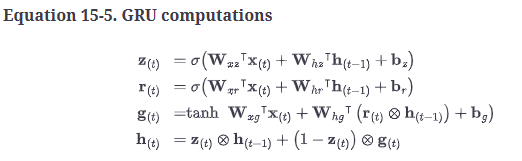

## Using 1D convolutional layers to process sequences

- LSTM and GRU cells are one of the main reasons behind the success of RNNs. Yet while they can tackle much longer sequences than simple RNNs, they still have a fairly limited short-term memory, and they have a hard time learning long-term patterns in sequences of 100 time steps or more, such as audio samples, long time series, or long sentences. One way to solve this is to shorten the input sequences; for example, using 1D convolutional layers.

- 1D convolutional layer slides several kernels across a sequence, producing a 1D feature map per kernel. Each kernel will learn to detect a single very short sequential pattern (no longer than the kernel size). If you use 10 kernels, then the layer’s output will be composed of 10 1D sequences (all of the same length), or equivalently you can view this output as a single 10D sequence. If you use "valid" padding or a stride greater than 1, then the output sequence will be shorter than the input sequence.

In [ ]:
import numpy as np
import tensorflow as tf

input = np.random.randn(32, 112, 5)

conv = tf.keras.layers.Conv1D(filters=32, kernel_size=4, strides=2,
                           activation="relu", input_shape=[None, 5])

conv(input).shape

TensorShape([32, 55, 32])

- If input has sequence length of 112 and dimensionality of 5 then 1D convolution with 32 filters and 2 stride will output sequence of length 55 and dimensionality 32. So we reduced the time steps while increasing the dimensionality of input x at each time step.

In [ ]:
conv.get_weights()[0].shape

(4, 5, 32)

- Each kernel span sequence of length 4 where each element of sequence has dimensionality of 5. Weighted sum of this sequence [4, 5] is computed by 32 different filters.

- The following model is the same as earlier, except it starts with a 1D convolutional layer that downsamples the input sequence by a factor of 2, using a stride of 2. The kernel size is larger than the stride, so all inputs will be used to compute the layer’s output, and therefore the model can learn to preserve the useful information, dropping only the unimportant details. By shortening the sequences the convolutional layer may help the GRU layers detect longer patterns, so we can afford to double the input sequence length to 112 days.

In [ ]:
conv_rnn_model = tf.keras.Sequential([
    # input : (32, 112, 5) [batch, seq_len, dim]
    tf.keras.layers.Conv1D(filters=32, kernel_size=4, strides=2,
                           activation="relu", input_shape=[None, 5]),
    # output: (32, 55, 32) [batch, seq_len', dim']
    tf.keras.layers.GRU(32, return_sequences=True),
    # output: (32, 55, 32) [batch, seq_len', GRU_neurons]
    tf.keras.layers.Dense(14)
    # output: (32, 55, 14) [batch, seq_len', dense_neurons]
])

In [ ]:
longer_train = to_seq2seq_dataset(mulvar_train, seq_length=112,
                                       shuffle=True, seed=42)
longer_valid = to_seq2seq_dataset(mulvar_valid, seq_length=112)

In [ ]:
for x,y in longer_train.take(1):
    print(x.shape, y.shape)

(32, 112, 5) (32, 112, 14)


- Note that we must also crop off the first three time steps in the targets: indeed, the kernel’s size is 4, so the first output of the convolutional layer will be based on the input time steps 0 to 3, and the first forecasts will be for time steps 4 to 17 (instead of time steps 1 to 14). Moreover, we must downsample the targets by a factor of 2, because of the stride.

- New time steps are 55. Each new time step is composed of original 4 time steps strided by 2. The output of first new time step is output of 4th original time step. The output of second new time step is output of 6th original time step and so on.

```
  |-----0-----|      |-----3----|      |--... |-------52------|
         |-----1----|      |-----4----|   ... |       |-------53------|
               |-----2----|     |------5--...-51------|       |-------54------|
X:  0  1  2  3  4  5  6  7  8  9 10 11 12 ...  104 105 106 107 108 109 110 111
Y:      from 4     6     8    10    12    ...      106     108     110     112
         to 17    19    21    23    25    ...      119     121     123     125
```

In [ ]:
y[:, 3::2, :].shape

TensorShape([32, 55, 14])

In [ ]:
downsampled_train = longer_train.map(lambda X, Y: (X, Y[:, 3::2]))
downsampled_valid = longer_valid.map(lambda X, Y: (X, Y[:, 3::2]))

In [ ]:
# Just training for 5 epochs to show that it works
fit_and_evaluate(conv_rnn_model, downsampled_train, downsampled_valid,
                 learning_rate=0.1, epochs=5)

Epoch 1/5
31/31 [==============================] - 14s 143ms/step - loss: 0.0578 - mae: 0.2618 - val_loss: 0.0208 - val_mae: 0.1627 - lr: 0.1000
Epoch 2/5
31/31 [==============================] - 3s 71ms/step - loss: 0.0164 - mae: 0.1540 - val_loss: 0.0175 - val_mae: 0.1423 - lr: 0.1000
Epoch 3/5
31/31 [==============================] - 3s 90ms/step - loss: 0.0145 - mae: 0.1460 - val_loss: 0.0163 - val_mae: 0.1358 - lr: 0.1000
Epoch 4/5
31/31 [==============================] - 2s 67ms/step - loss: 0.0134 - mae: 0.1388 - val_loss: 0.0152 - val_mae: 0.1286 - lr: 0.1000
Epoch 5/5
1/1 [==============================] - 0s 119ms/step - loss: 0.0136 - mae: 0.1233


123286.8954539299

## WaveNet

- In a 2016 paper, DeepMind researchers introduced a novel architecture called WaveNet. They stacked 1D convolutional layers, doubling the dilation rate (how spread apart each neuron’s inputs are) at every layer: the first convolutional layer gets a glimpse of just two time steps at a time, while the next one sees four time steps (its receptive field is four time steps long), the next one sees eight time steps, and so on (see Figure 15-14). This way, the lower layers learn short-term patterns, while the higher layers learn long-term patterns. Thanks to the doubling dilation rate, the network can process extremely large sequences very efficiently.

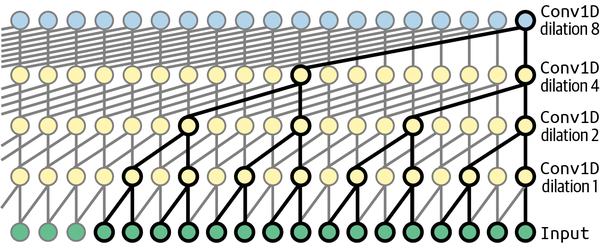

- The authors of the paper actually stacked 10 convolutional layers with dilation rates of 1, 2, 4, 8, …​, 256, 512, then they stacked another group of 10 identical layers (also with dilation rates 1, 2, 4, 8, …​, 256, 512), then again another identical group of 10 layers. They justified this architecture by pointing out that a single stack of 10 convolutional layers with these dilation rates will act like a super-efficient convolutional layer with a kernel of size 1,024 (except way faster, more powerful, and using significantly fewer parameters [20 instead of 1024 for one feature map]). They also left-padded the input sequences with a number of zeros equal to the dilation rate before every layer, to preserve the same sequence length throughout the network.

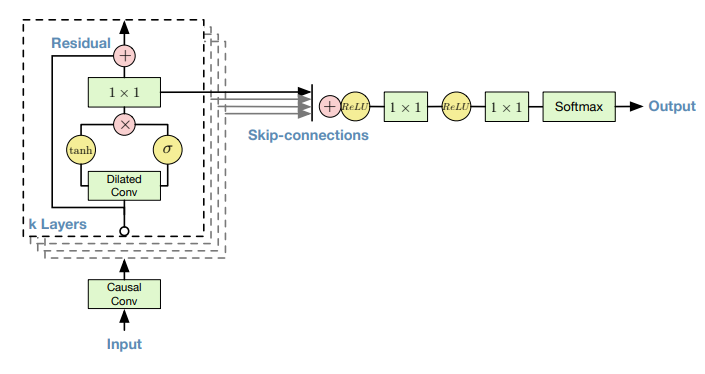

In [ ]:
import tensorflow as tf
import numpy as np

In [ ]:
class GatedActivationUnit(tf.keras.layers.Layer):
    def __init__(self, activation="tanh", **kwargs):
        super().__init__(**kwargs)
        self.activation = tf.keras.activations.get(activation)
        self.sigmoid = tf.keras.activations.sigmoid

    def call(self, inputs):
        n_filters = inputs.shape[-1] // 2
        linear_output = self.activation(inputs[..., :n_filters])
        gate = self.sigmoid(inputs[..., n_filters:])
        return linear_output * gate

In [ ]:
def wavenet_residual_block(inputs, n_filters, dilation_rate):
    z = tf.keras.layers.Conv1D(2 * n_filters, kernel_size=2, padding="causal",
                            dilation_rate=dilation_rate)(inputs)
    z = GatedActivationUnit()(z)
    z = tf.keras.layers.Conv1D(n_filters, kernel_size=1)(z)
    return tf.keras.layers.Add()([z, inputs]), z

In [ ]:
tf.keras.utils.set_random_seed(42)
tf.keras.backend.clear_session()

n_layers_per_block = 3  # 10 in the paper
n_blocks = 1  # 3 in the paper
n_filters = 32  # 128 in the paper
n_outputs = 14  # 256 in the paper

inputs = tf.keras.layers.Input(shape=[None, 5])
z = tf.keras.layers.Conv1D(n_filters, kernel_size=2, padding="causal")(inputs)
skip_to_last = []
for dilation_rate in [2**i for i in range(n_layers_per_block)] * n_blocks:
    z, skip = wavenet_residual_block(z, n_filters, dilation_rate)
    skip_to_last.append(skip)

z = tf.keras.activations.relu(tf.keras.layers.Add()(skip_to_last))
z = tf.keras.layers.Conv1D(n_filters, kernel_size=1, activation="relu")(z)
Y_preds = tf.keras.layers.Conv1D(n_outputs, kernel_size=1)(z)

full_wavenet_model = tf.keras.Model(inputs=[inputs], outputs=[Y_preds])

In [ ]:
full_wavenet_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, None, 5)]            0         []                            
                                                                                                  
 conv1d (Conv1D)             (None, None, 32)             352       ['input_1[0][0]']             
                                                                                                  
 conv1d_1 (Conv1D)           (None, None, 64)             4160      ['conv1d[0][0]']              
                                                                                                  
 gated_activation_unit (Gat  (None, None, 32)             0         ['conv1d_1[0][0]']            
 edActivationUnit)                                                                            

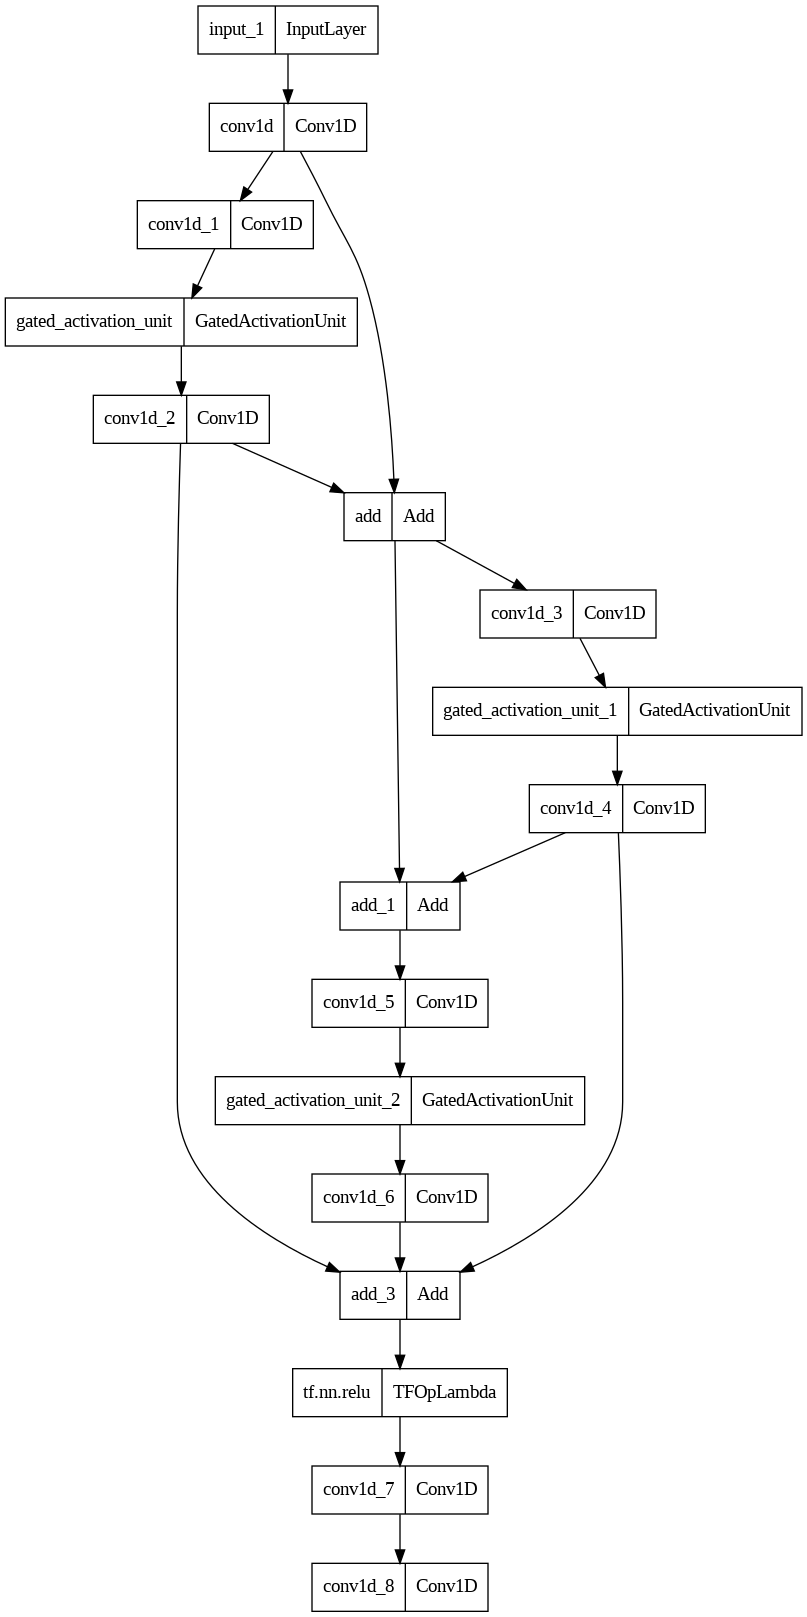

In [ ]:
tf.keras.utils.plot_model(full_wavenet_model)

# Natural Language Processing with RNNs and Attention

## Preparing Dataset

In [ ]:
import tensorflow as tf
import numpy as np

In [ ]:
url = "https://github.com/karpathy/char-rnn/raw/master/data/tinyshakespeare/input.txt"
filepath = tf.keras.utils.get_file(fname="shakespeare.txt", origin=url, cache_dir="./")

1115394/1115394 [==============================] - 0s 0us/step


In [ ]:
with open(filepath) as f:
    shakespere_text = f.read()

In [ ]:
print(shakespere_text[:150])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

A


In [ ]:
vectorizer = tf.keras.layers.TextVectorization(split="character", standardize="lower")
vectorizer.adapt([shakespere_text])

In [ ]:
encoded = vectorizer([shakespere_text])[0]

In [ ]:
vectorizer.get_vocabulary()[:10]

['', '[UNK]', ' ', 'e', 't', 'o', 'a', 'i', 'h', 's']

In [ ]:
vocab = vectorizer.get_vocabulary()[2:]
encoded -= 2

dataset_size = len(encoded)
n_tokens = len(vocab)

len(vocab), dataset_size

(39, 1115394)

In [ ]:
np.array(vocab)[encoded[:20]]

array(['f', 'i', 'r', 's', 't', ' ', 'c', 'i', 't', 'i', 'z', 'e', 'n',
       ':', '\n', 'b', 'e', 'f', 'o', 'r'], dtype='<U1')

In [ ]:
def to_dataset(sequence, length, shuffle=False, seed=None, batch_size=32):
    ds = tf.data.Dataset.from_tensor_slices(sequence)
    ds = ds.window(length + 1, shift=1, drop_remainder=True) # dataset size is dataset_size - length + 1
    ds = ds.flat_map(lambda x: x.batch(length + 1))
    if shuffle:
        ds = ds.shuffle(100_000, seed=seed)
    ds = ds.map(lambda x: (x[:-1], x[1:]))
    return ds.batch(batch_size).prefetch(1)

One sample in the dataset may be a sequence of character IDs representing the text “to be or not to b” (without the final “e”), and the corresponding target—a sequence of character IDs representing the text “o be or not to be” (with the final “e”, but without the leading “t”)

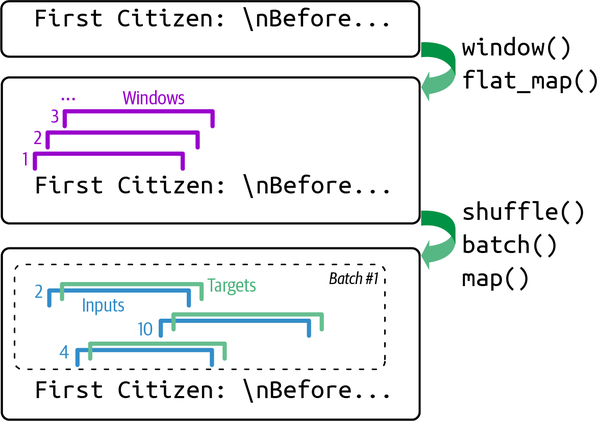

In [ ]:
dataset_size * 0.9, dataset_size * 0.05

(1003854.6, 55769.700000000004)

In [ ]:
length = 100
seed = 42

dataset_size = dataset_size - length + 1

# [90, 5, 5] split
train_set = to_dataset(encoded[:1_000_000], length=length, shuffle=True, seed=42)
valid_set = to_dataset(encoded[1_000_000:1_060_000], length=length)
test_set = to_dataset(encoded[1_060_000:], length=length)

In [ ]:
for x,y in train_set.take(1):
    print(x.shape, y.shape)

(32, 100) (32, 100)


## Building and Training the Char-RNN Model

- We have dataset of about million training examples. For such large dataset, we need highly flexible model.

- Each time step has input of one character. This single input will be ignored in the presense of inputs from hidden state of previous step. For better representation of characters, we will use embedding.

In [ ]:
tf.keras.utils.set_random_seed(42)

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=n_tokens, output_dim=16),
    tf.keras.layers.GRU(128, return_sequences=True),
    tf.keras.layers.Dense(n_tokens, activation="softmax")
])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 16)          624       
                                                                 
 gru (GRU)                   (None, None, 128)         56064     
                                                                 
 dense (Dense)               (None, None, 39)          5031      
                                                                 
Total params: 61719 (241.09 KB)
Trainable params: 61719 (241.09 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"]) # nadam is per-parameter adaptive learning rate: it will adjust lr of each param
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("my_shakespeare_model", save_best_only=True, moniter="val_accuracy")
history = model.fit(train_set, validation_data=valid_set, epochs=5,
                    callbacks=[checkpoint_cb])

Epoch 1/5
31247/31247 [==============================] - 509s 16ms/step - loss: 1.2534 - accuracy: 0.6060 - val_loss: 1.5562 - val_accuracy: 0.5455
Epoch 2/5
31247/31247 [==============================] - 531s 16ms/step - loss: 1.2495 - accuracy: 0.6068 - val_loss: 1.5636 - val_accuracy: 0.5451
Epoch 3/5
31247/31247 [==============================] - 518s 16ms/step - loss: 1.2469 - accuracy: 0.6075 - val_loss: 1.5643 - val_accuracy: 0.5484
Epoch 4/5
31247/31247 [==============================] - 515s 16ms/step - loss: 1.2444 - accuracy: 0.6080 - val_loss: 1.5577 - val_accuracy: 0.5464
Epoch 5/5
31247/31247 [==============================] - 529s 16ms/step - loss: 1.2430 - accuracy: 0.6081 - val_loss: 1.5561 - val_accuracy: 0.5472


In [ ]:
!tar -czf my_shakespeare_model.tgz my_shakespeare_model

## Generating Fake Shakespearean Text

In [ ]:
!tar -xzf my_shakespeare_model.tgz

In [ ]:
model = tf.keras.models.load_model("my_shakespeare_model")

In [ ]:
shakespeare_model = tf.keras.Sequential([
    vectorizer,
    tf.keras.layers.Lambda(lambda x: x - 2), # no <PAD> or <UNK> tokens
    model
])

- To generate new text using the char-RNN model, we could feed it some text, make the model predict the most likely next letter, add it to the end of the text, then give the extended text to the model to guess the next letter, and so on. This is called **greedy decoding**. But in practice this often leads to the same words being repeated over and over again. Instead, we can sample the next character randomly, with a probability equal to the estimated probability, using TensorFlow’s tf.random.categorical() function. This will generate more diverse and interesting text. The categorical() function samples random class indices, given the class log probabilities (logits).

In [ ]:
def next_char(text, temperature=1):
    y_proba = shakespeare_model.predict([text], verbose=0)[:, -1, :] # [batch, logits]
    rescaled_logits = tf.math.log(y_proba) / temperature
    sampled_char_id = tf.random.categorical(rescaled_logits, num_samples=1)[0, 0]
    return vectorizer.get_vocabulary()[sampled_char_id + 2]

- Probabilities are converted to logits in the range of [-inf, 0]
- To have more control over the diversity of the generated text, we can divide the logits by a number called the temperature
- Low probabilities having high negative logit values are more affected by multipication and division than high probabilities having logit value close to 0.
- temperature close to 0 --> logits multiplied by a factor --> negtive logits become more negative --> high-probabiliies are favored --> generate precise text, such as mathematical equations
- temperature is high --> logits divied by a factor --> negtive logits become close to 0 --> Equal probabilities are given --> generate more diverse and creative text

In [ ]:
def extend_text(text, n_chars=50, temperature=1):
    for _ in range(n_chars):
        text += next_char(text, temperature)
    return text

In [ ]:
tf.random.set_seed(42)

In [ ]:
print(extend_text("To be or not to be", temperature=0.01))

To be or not to be so married
the deed and the duke of such a strang


In [ ]:
print(extend_text("To be or not to be", temperature=1))

To be or not to beg; confric is.

gremio:
not that would.

escalus:



In [ ]:
print(extend_text("To be or not to be", temperature=100))

To be or not to be&fid:;zf.dex
 :lmd '!l?-kxd'a?cuwwdfjfdl;iip-i.obr


- To generate more convincing text, a common technique is to
 - sample only from the top k characters, or only from the smallest set of top characters whose total probability exceeds some threshold (this is called nucleus sampling).
 - Alternatively, you could try using beam search, which we will discuss later in this chapter, or
 - using more GRU layers and more neurons per layer, training for longer, and adding some regularization if needed.

- Also note that the model is currently incapable of learning patterns longer than length, which is just 100 characters. You could try making this window larger, but it will also make training harder, and even LSTM and GRU cells cannot handle very long sequences. An alternative approach is to use a stateful RNN.

## Stateful RNN

- Preserve final state of RNN after processing a training batch and use it as the initial state for the next training batch

- Model could learn long-term patterns despite only backpropagating through short sequences.

- Input sequence in a batch starts exactly where the corresponding sequence in the previous batch left off. So the first thing we need to do to build a stateful RNN is to use sequential and nonoverlapping input sequences.

In [ ]:
# For simplicity of preparing data that preserves the sequence between batches, use batch size of 1
def to_dataset_for_stateful_rnn(sequence, length):
    ds = tf.data.Dataset.from_tensor_slices(sequence)
    ds = ds.window(length + 1, shift=length, drop_remainder=True)
    ds = ds.flat_map(lambda window: window.batch(length + 1)).batch(1)
    return ds.map(lambda window: (window[:, :-1], window[:, 1:])).prefetch(1)

stateful_train_set = to_dataset_for_stateful_rnn(encoded[:1_000_000], length)
stateful_valid_set = to_dataset_for_stateful_rnn(encoded[1_000_000:1_060_000],
                                                 length)
stateful_test_set = to_dataset_for_stateful_rnn(encoded[1_060_000:], length)

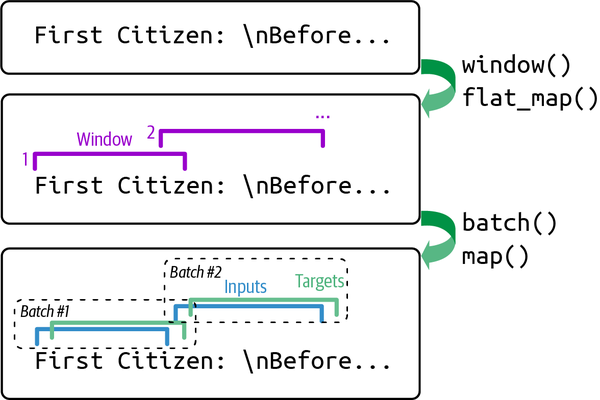

In [ ]:
list(to_dataset_for_stateful_rnn(tf.range(10), 3))

[(<tf.Tensor: shape=(1, 3), dtype=int32, numpy=array([[0, 1, 2]], dtype=int32)>,
  <tf.Tensor: shape=(1, 3), dtype=int32, numpy=array([[1, 2, 3]], dtype=int32)>),
 (<tf.Tensor: shape=(1, 3), dtype=int32, numpy=array([[3, 4, 5]], dtype=int32)>,
  <tf.Tensor: shape=(1, 3), dtype=int32, numpy=array([[4, 5, 6]], dtype=int32)>),
 (<tf.Tensor: shape=(1, 3), dtype=int32, numpy=array([[6, 7, 8]], dtype=int32)>,
  <tf.Tensor: shape=(1, 3), dtype=int32, numpy=array([[7, 8, 9]], dtype=int32)>)]

- Need to spcify the `batch_input_size`, RNN layers should `stateful=True`, and model state should be reset after each epoch.

In [ ]:
tf.keras.utils.set_random_seed(42)
state_model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=n_tokens, output_dim=16, batch_input_shape=[1, None]),
    tf.keras.layers.GRU(128, return_sequences=True, stateful=True),
    tf.keras.layers.Dense(n_tokens, activation="softmax")
])

class ResetStatesCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        self.model.reset_states() # base calss has model as attribute

state_model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("my_stateful_shakespeare_model", save_best_only=True, moniter="val_accuracy")
history = state_model.fit(stateful_train_set, validation_data=stateful_valid_set, epochs=1,
                    callbacks=[ResetStatesCallback(), checkpoint_cb])

9999/9999 [==============================] - 735s 73ms/step - loss: 1.8646 - accuracy: 0.4514 - val_loss: 1.7033 - val_accuracy: 0.4939


In [ ]:
state_shakespeare_model= tf.keras.Sequential([
    vectorizer,
    tf.keras.layers.Lambda(lambda X: X - 2),  # no <PAD> or <UNK> tokens
    state_model # only works with input of single batch
])

In [ ]:
prob = state_shakespeare_model.predict(["To be or not to b"])[0, -1, :]
pred = tf.argmax(prob)
vectorizer.get_vocabulary()[pred + 2]

1/1 [==============================] - 0s 80ms/step


'e'

## Sentiment Analysis

In [ ]:
import tensorflow_datasets as tfds
import tensorflow as tf

In [ ]:
raw_train_set, raw_valid_set, raw_test_set = tfds.load(
    name="imdb_reviews",
    split=["train[:90%]", "train[90%:]", "test"],
    as_supervised=True
)

In [ ]:
tf.random.set_seed(42)
train_set = raw_train_set.shuffle(5000, seed=42).batch(32).prefetch(1)
valid_set = raw_valid_set.batch(32).prefetch(1)
test_set = raw_test_set.batch(32).prefetch(1)

In [ ]:
for x,y in train_set.take(1):
    print(x.shape, y.shape)

(32,) (32,)


- **Byte pair encoding (BPE):** BPE works by splitting the whole training set
into individual characters (including spaces), then repeatedly merging the most frequent
adjacent pairs until the vocabulary reaches the desired size.
- **Subword regularization:** Improves
accuracy and robustness by introducing some randomness in tokenization during training: for
example, “New England” may be tokenized as “New” + “England”, or “New” + “Eng” +
“land”, or simply “New England” (just one token)

In [ ]:
vocab_size = 1000 # since it’s unlikely that very rare words will be important
embed_size = 128
tf.random.set_seed(42)

text_vec_layer = tf.keras.layers.TextVectorization(max_tokens=vocab_size)
text_vec_layer.adapt(train_set.map(lambda reviews, labels: reviews))

model = tf.keras.Sequential([
    text_vec_layer,
    tf.keras.layers.Embedding(vocab_size, embed_size, mask_zero=True),
    tf.keras.layers.GRU(128),
    tf.keras.layers.Dense(1, activation="sigmoid")
])
model.compile(loss="binary_crossentropy", optimizer="nadam",
              metrics=["accuracy"])
history = model.fit(train_set, validation_data=valid_set, epochs=1)

704/704 [==============================] - 958s 1s/step - loss: 0.5310 - accuracy: 0.7250 - val_loss: 0.4184 - val_accuracy: 0.8104


In [ ]:
model.predict(["What a great movie!"])[0, 0]

1/1 [==============================] - 0s 65ms/step


0.75227535

### Masking:
 - The reviews
have different lengths, so when the TextVectorization layer converts them to sequences
of token IDs, it pads the shorter sequences using the padding token (with ID 0) to make them as
long as the longest sequence in the batch.

   As a result, most sequences end with many padding
tokens—often dozens or even hundreds of them. Even though we’re using a GRU layer, which
is much better than a SimpleRNN layer, its short-term memory is still not great, so when it
goes through many padding tokens, it ends up forgetting what the review was about! One solution is to make the RNN ignore the padding tokens. This can be done
using masking.

 - Use `mask_zero=True` when creating the Embedding layer: Embedding layer creates a mask tensor equal to
`tf.math.not_equal(inputs, 0)`: it is a Boolean tensor with the same shape as the
inputs [32, longest seq. length], and it is equal to False anywhere the token IDs are 0, or True otherwise. This mask
tensor is then automatically propagated by the model to the next layer. If that layer’s `call()`
method has a mask argument, then it automatically receives the mask. This allows the layer to
ignore the appropriate time steps.

 - if the layer’s `supports_masking` attribute is True, then the mask is automatically
propagated to the next layer. It keeps propagating this way for as long as the layers have
`supports_masking=True`. As an example, a recurrent layer’s `supports_masking`
attribute is True when `return_sequences=True`, but it’s False when `return_ sequences=False` since there’s no need for a mask anymore in this case.

 - For manual masking:
 ```python
 inputs = tf.keras.layers.Input(shape=[], dtype=tf.string)
token_ids = text_vec_layer(inputs)
mask = tf.math.not_equal(token_ids, 0)
Z = tf.keras.layers.Embedding(vocab_size, embed_size)(token_ids)
Z = tf.keras.layers.GRU(128, dropout=0.2)(Z, mask=mask)
outputs = tf.keras.layers.Dense(1, activation="sigmoid")(Z)
model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
 ```


## Reusing Pretrained Embeddings and Language Models

-  Instead of training word embeddings, we could just download and use pretrained
embeddings, such as **Google’s Word2vec** embeddings, **Stanford’s GloVe** embeddings, or **Facebook’s FastText** embeddings.

- Using pretrained word embeddings was popular for several years, but this approach has its
limits. In particular, a word has a single representation, no matter the context. For example, the
word “right” is encoded the same way in “left and right” and “right and wrong”, even though it
means two very different things.

- To address this limitation, use context based embeddings learned from pretrained language models:

 ### Embeddings from Language Models (ELMo) (2018):
  - These are deep contextualized word representation that incorporates both word-level characteristics and contextual semantics.
  - Unlike Glove and Word2Vec, ELMo represents embeddings for a word using the complete sentence containing that word in order to capture context.
  - ELMo's word embeddings are a function of the internal states of a deep bidirectional LSTM network
 - So Instead of
just using pretrained embeddings in your model, you reuse part of a pretrained language model.


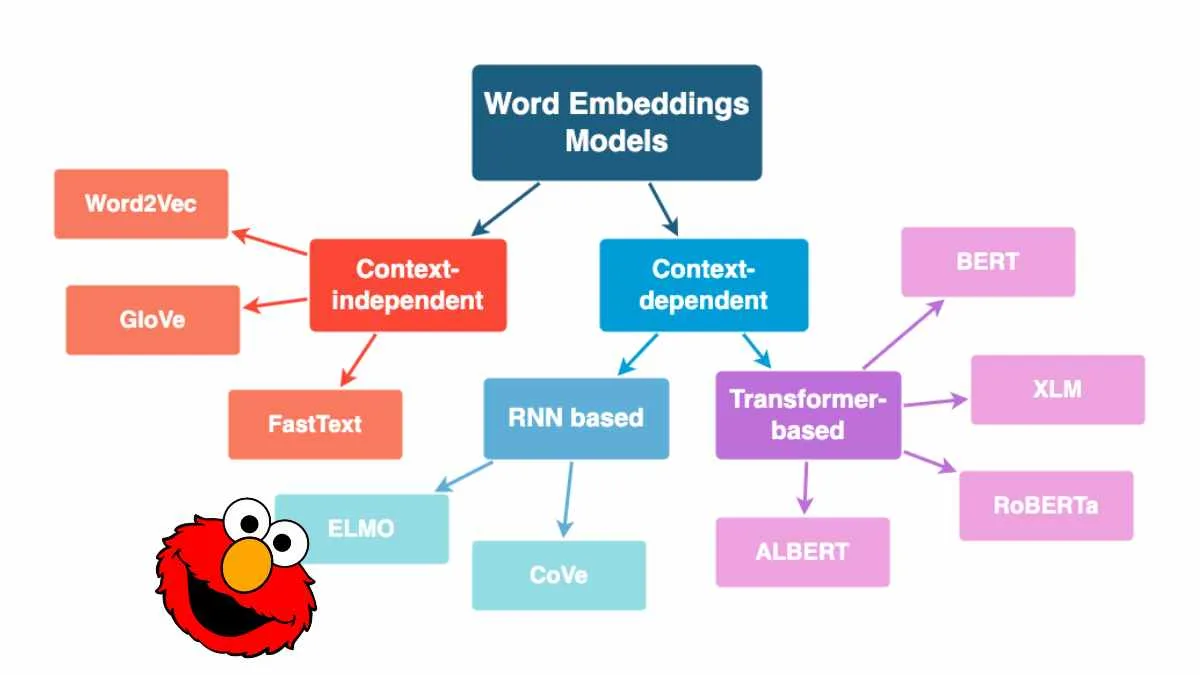

- In 2018 'the Universal Language Model Fine-Tuning (ULMFiT)' paper, the authors trained an LSTM language model on a huge text corpus
using self-supervised learning (i.e., generating the labels automatically from the data), then they
fine-tuned it on various tasks. Their model outperformed the state of the art on six text
classification tasks by a large margin (reducing the error rate by 18–24% in most cases).
Moreover, the authors showed a pretrained model fine-tuned on just 100 labeled examples could achieve the same performance as one trained from scratch on 10,000 examples.

 This motivated reusing pretrained language models.

 For example, let’s build a classifier based on the Universal Sentence Encoder (2018), which uses the transformer architecture,



In [ ]:
import tensorflow_hub as hub
import os

os.environ["TFHUB_CACHE_DIR"] = "./data"
handle = "https://www.kaggle.com/models/google/universal-sentence-encoder/frameworks/TensorFlow2/variations/universal-sentence-encoder/versions/2"
USE = hub.KerasLayer(handle, trainable=True, input_shape=[], dtype=tf.string)

In [ ]:
USE(["Hello my name is Sohaib"]).shape

TensorShape([1, 512])

- This model is quite large—close to 1 GB in size—so it may take a while to download. By default, TensorFlow
Hub modules are saved to a temporary directory, and they get downloaded again and again every time you run
your program. To avoid that, you must set the TFHUB_CACHE_DIR environment variable to a directory of your
choice: the modules will then be saved there, and only downloaded once.

- Also note that we set trainable=True when creating the hub.KerasLayer. This way,
the pretrained Universal Sentence Encoder is fine-tuned during training: some of its weights are
tweaked via backprop.

In [ ]:
tf.keras.utils.set_random_seed(42)

model = tf.keras.Sequential([
    USE,
    tf.keras.layers.Dense(32, activation="relu"),
    tf.keras.layers.Dense(1, activation="sigmoid")
])
model.compile(loss="binary_crossentropy", optimizer="nadam",
              metrics=["accuracy"])
model.fit(train_set, validation_data=valid_set, epochs=1)

219/704 [========>.....................] - ETA: 30:57 - loss: 0.3820 - accuracy: 0.8400

In [ ]:
model.predict(["This movie did a great job to disgust me"])[0, 0]

1/1 [==============================] - 0s 395ms/step


0.0935991

In [ ]:
model.predict(["This is not a good movie"])[0, 0]

1/1 [==============================] - 0s 59ms/step


0.14142159

In [ ]:
model.predict(["This is not bad movie"])[0, 0]

1/1 [==============================] - 0s 128ms/step


0.020782474

## An Encoder–Decoder Network for Neural Machine Translation


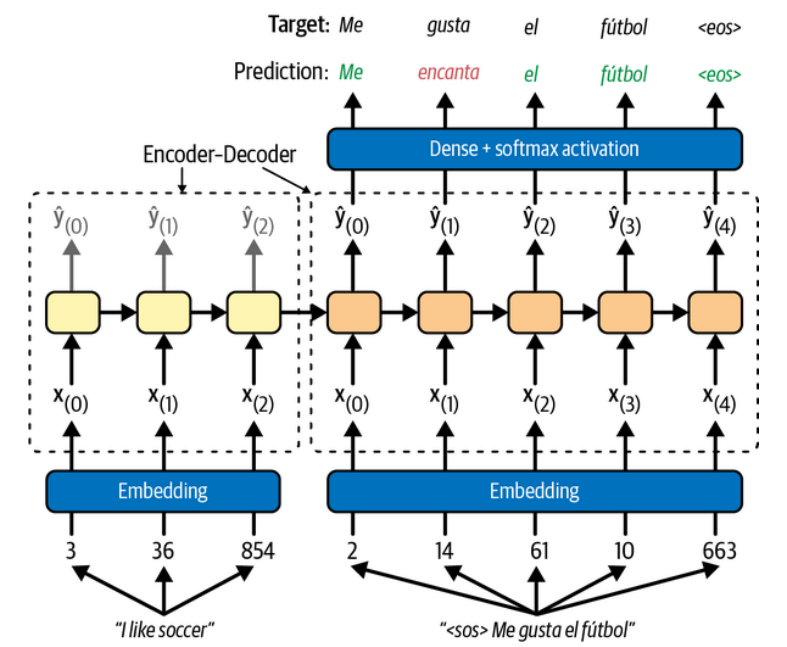

### Teacher forcing:

- During training the decoder is given as input the word that it should have output at the previous step, regardless of what it actually output.
- **It significantly speeds up training and improves the model’s performance as it is better to input previous output rather than 0.**
- For the very first word, the decoder is given the start-of-sequence (SOS) token, and the decoder is expected to end the sentence with an end-of-sequence (EOS) token.
- Note that at inference time (after training), you will not have the target sentence to feed to the
decoder. Instead, you need to feed it the word that it has just output at the previous step, as
shown in Figure 16-4 (this will require an embedding lookup that is not shown in the diagram).


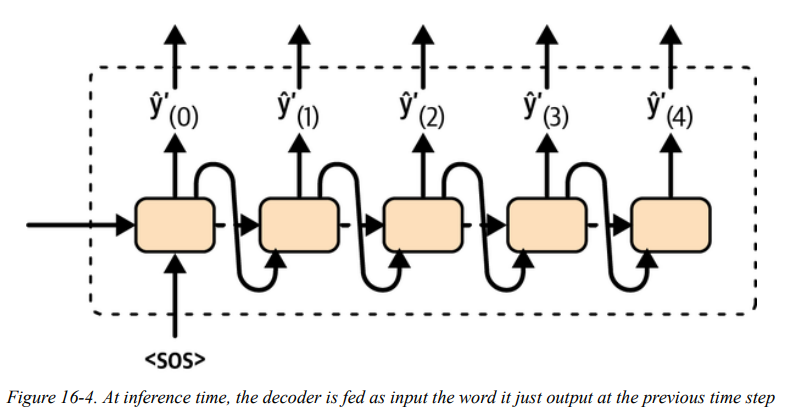


**Download a dataset of English/Spanish sentence pairs:**

In [ ]:
import tensorflow as tf

url = "https://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip"
tf.keras.utils.get_file("spa-eng.zip", url, extract=True, cache_dir="./")

'./datasets/spa-eng.zip'

In [ ]:
with open("./datasets/spa-eng/spa.txt") as f:
    text = f.read()

In [ ]:
text[:100]

'Go.\tVe.\nGo.\tVete.\nGo.\tVaya.\nGo.\tVáyase.\nHi.\tHola.\nRun!\t¡Corre!\nRun.\tCorred.\nWho?\t¿Quién?\nFire!\t¡Fueg'

In [ ]:
text = text.replace("¿", "").replace("¡", "") # these are not identified as punctuation by TextVectorization so remove them manually
text[:100]

'Go.\tVe.\nGo.\tVete.\nGo.\tVaya.\nGo.\tVáyase.\nHi.\tHola.\nRun!\tCorre!\nRun.\tCorred.\nWho?\tQuién?\nFire!\tFuego!\n'

**Let's create 2 inputs. First is list of english sentences. Second is list of corresponding spanish sentences.**

Sentence == sequence of words

In [ ]:
# Creating paris of english and corresponding spanish
pairs = [line.split("\t") for line in text.splitlines()]
pairs[-2:]

[['Since there are usually multiple websites on any given topic, I usually just click the back button when I arrive on any webpage that has pop-up advertising. I just go to the next page found by Google and hope for something less irritating.',
  'Como suele haber varias páginas web sobre cualquier tema, normalmente sólo le doy al botón de retroceso cuando entro en una página web que tiene anuncios en ventanas emergentes. Simplemente voy a la siguiente página encontrada por Google y espero encontrar algo menos irritante.'],
 ['If you want to sound like a native speaker, you must be willing to practice saying the same sentence over and over in the same way that banjo players practice the same phrase over and over until they can play it correctly and at the desired tempo.',
  'Si quieres sonar como un hablante nativo, debes estar dispuesto a practicar diciendo la misma frase una y otra vez de la misma manera en que un músico de banjo practica el mismo fraseo una y otra vez hasta que lo p

**Seems like Sequence length increases toward the end. Lets shuffle the pairs and then seperate them.**

In [ ]:
import numpy as np
np.random.seed(42)
np.random.shuffle(pairs)
sentences_en, sentences_es= zip(*pairs)

In [ ]:
for i in range(3):
    print(sentences_en[i], "=>", sentences_es[i])

How boring! => Qué aburrimiento!
I love sports. => Adoro el deporte.
Would you like to swap jobs? => Te gustaría que intercambiemos los trabajos?


In [ ]:
len(sentences_en)

118964

**Tokenizing using TextVectorization:**

Using TextVectorization, it is checked:
- English:
    - Actual vocab size is 13634 (no [UNK]).
    - Max seq length is 47
- Spanish:
    - Actual vocab size is 26141 (no [UNK]).
    - Max seq length is 49

- We limit the vocabulary size to 1,000, which is quite small. That’s because the training set
is not very large, and because using a small value will speed up training.
- Using max seq length of 50. If there was any sentence longer than
50 tokens in the training set, it would be cropped to 50 tokens.
- The second input (i.e translation) is represented as "startofseq {sentence} endofseq"

In [ ]:
vocab_size = 1000
max_length = 50

en_vectorizer = tf.keras.layers.TextVectorization(max_tokens=vocab_size, output_sequence_length=max_length)
en_vectorizer.adapt(sentences_en)

es_vectorizer = tf.keras.layers.TextVectorization(max_tokens=vocab_size, output_sequence_length=max_length)
es_vectorizer.adapt([f"startofseq {s} endofseq" for s in sentences_es])

In [ ]:
en_vectorizer.get_vocabulary()[:10]

['', '[UNK]', 'the', 'i', 'to', 'you', 'tom', 'a', 'is', 'he']

In [ ]:
es_vectorizer.get_vocabulary()[:10]

['', '[UNK]', 'startofseq', 'endofseq', 'de', 'que', 'a', 'no', 'tom', 'la']

In [ ]:
# [100,000, ~19000]
X_train_enc = tf.constant(sentences_en[:100_000])
X_valid_enc = tf.constant(sentences_en[100_000:])
X_train_dec = tf.constant([f"startofseq {s}" for s in sentences_es[:100_000]])
X_valid_dec = tf.constant([f"startofseq {s}" for s in sentences_es[100_000:]])
y_train = es_vectorizer([f"{s} endofseq" for s in sentences_es[:100_000]])
y_valid = es_vectorizer([f"{s} endofseq" for s in sentences_es[100_000:]])

In [ ]:
# Lets create the model
tf.keras.utils.set_random_seed(42)
tf.keras.backend.clear_session()

encoder_input = tf.keras.layers.Input(shape=[], dtype=tf.string)
decoder_input = tf.keras.layers.Input(shape=[], dtype=tf.string)

encoder_input_ids = en_vectorizer(encoder_input)
decoder_input_ids = es_vectorizer(decoder_input)

embed_size = 128
encoder_embedder = tf.keras.layers.Embedding(vocab_size, embed_size, mask_zero=True)
decoder_embedder = tf.keras.layers.Embedding(vocab_size, embed_size, mask_zero=True)
encoder_embeddings = encoder_embedder(encoder_input_ids)
decoder_embeddings = decoder_embedder(decoder_input_ids)

encoder = tf.keras.layers.LSTM(512, return_state=True)
encoder_output, *encoder_state = encoder(encoder_embeddings)

decoder = tf.keras.layers.LSTM(512, return_sequences=True)
decoder_outputs = decoder(decoder_embeddings, initial_state=encoder_state)

output_layer = tf.keras.layers.Dense(vocab_size, activation="softmax")
y_proba = output_layer(decoder_outputs)

model = tf.keras.Model(inputs=[encoder_input, decoder_input], outputs=[y_proba])

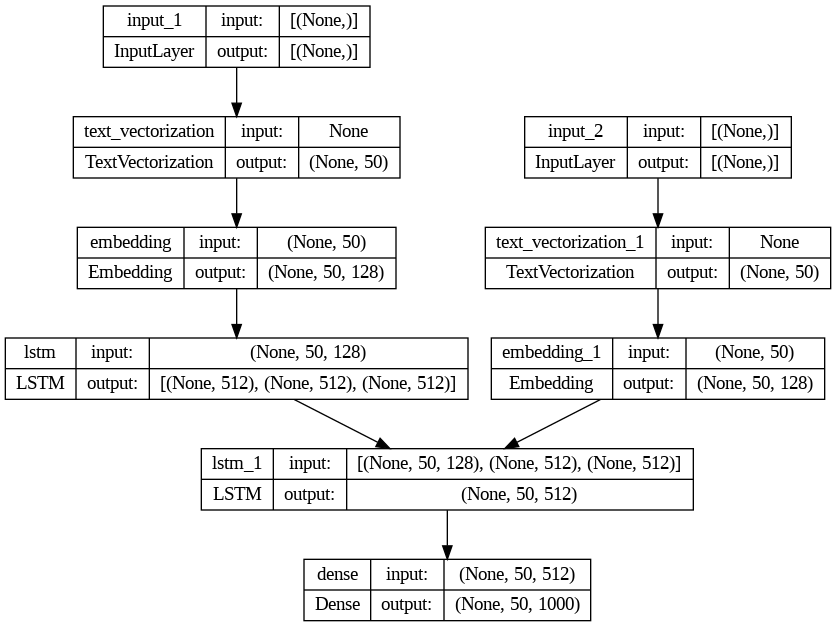

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [ ]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
model.fit((X_train_enc, X_train_dec), y_train, validation_data=((X_valid_enc, X_valid_dec), y_valid), epochs=10)

Epoch 1/10
3125/3125 [==============================] - 104s 29ms/step - loss: 2.9927 - accuracy: 0.4153 - val_loss: 2.2645 - val_accuracy: 0.5077
Epoch 2/10
3125/3125 [==============================] - 74s 24ms/step - loss: 1.9716 - accuracy: 0.5513 - val_loss: 1.7527 - val_accuracy: 0.5903
Epoch 3/10
3125/3125 [==============================] - 70s 22ms/step - loss: 1.5670 - accuracy: 0.6211 - val_loss: 1.5134 - val_accuracy: 0.6375
Epoch 4/10
3125/3125 [==============================] - 66s 21ms/step - loss: 1.3342 - accuracy: 0.6656 - val_loss: 1.3906 - val_accuracy: 0.6617
Epoch 5/10
3125/3125 [==============================] - 66s 21ms/step - loss: 1.1752 - accuracy: 0.6970 - val_loss: 1.3344 - val_accuracy: 0.6740
Epoch 6/10
3125/3125 [==============================] - 68s 22ms/step - loss: 1.0545 - accuracy: 0.7218 - val_loss: 1.3032 - val_accuracy: 0.6793
Epoch 7/10
3125/3125 [==============================] - 63s 20ms/step - loss: 0.9568 - accuracy: 0.7415 - val_loss: 1.2952 

After training, we can use the model to translate new English sentences to Spanish. But it’s not
as simple as calling model.predict(), because the decoder expects as input the word that
was predicted at the previous time step.

To keep things simple, we can just call the model multiple times, predicting one extra
word at each round

In [ ]:
def translate(text):
    translation = ""
    x_encoder = np.array([text])
    for word_idx in range(max_length):
        x_decoder = np.array(["startofseq " + translation])
        y_proba = model.predict((x_encoder, x_decoder), verbose=0)
        y_pred_idx = np.argmax(y_proba[0, word_idx, :])
        y_pred = es_vectorizer.get_vocabulary()[y_pred_idx]
        if y_pred == "endofseq":
            break
        translation += " " + y_pred
    return translation.strip()

In [ ]:
translate("I like soccer") # Correct

'me gusta el fútbol'

In [ ]:
translate("I love beach") # Correct

'me encanta la playa'

In [ ]:
translate("I like soccer and also going to the beach") # fails with long sequences

'me gusta más la tarde y [UNK] al béisbol'

### OPTIMIZING THE OUTPUT LAYER

- When the output vocabulary is large, outputting a probability for each and every possible
word can be quite slow. If the target vocabulary contained, say, 50,000 Spanish words
instead of 1,000, then the decoder would output 50,000-dimensional vectors, and
computing the softmax function over such a large vector would be very computationally
intensive. To avoid this, one solution is to look only at the logits output by the model for the
correct word and for a random sample of incorrect words, then compute an approximation
of the loss based only on these logits. This sampled softmax technique was introduced in
2015 by Sébastien Jean et al. In TensorFlow you can use the
`tf.nn.sampled_softmax_loss()` function for this during training and use the
normal softmax function at inference time (sampled softmax cannot be used at inference
time because it requires knowing the target).

- Another thing you can do to speed up training—which is compatible with sampled softmax
—is to tie the weights of the output layer to the transpose of the decoder’s embedding
matrix (you will see how to tie weights in Chapter 17). This significantly reduces the
number of model parameters, which speeds up training and may sometimes improve the
model’s accuracy as well, especially if you don’t have a lot of training data. The embedding
matrix is equivalent to one-hot encoding followed by a linear layer with no bias term and
no activation function that maps the one-hot vectors to the embedding space. The output
layer does the reverse. So, if the model can find an embedding matrix whose transpose is
close to its inverse (such a matrix is called an orthogonal matrix), then there’s no need to
learn a separate set of weights for the output layer.

Lets improve the model using:

## Bidirectional RNNs

- For tasks like text classification, or in the encoder of a seq2seq
model, it is often preferable to look ahead at the next words before encoding a given word.

- For example, consider the phrases “the right arm”, “the right person”, and “the right to
criticize”: to properly encode the word “right”, you need to look ahead.

- One solution is to run
two recurrent layers on the same inputs, one reading the words from left to right and the other
reading them from right to left, then combine their outputs at each time step, typically by
concatenating them. This is what a bidirectional recurrent layer does.

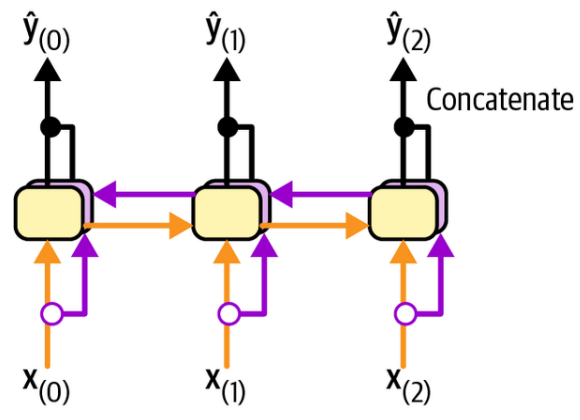

- To create a bidirectional recurrent layer, just wrap a regular recurrent layer in a `Bidirectional` layer:

 ```python
encoder = tf.keras.layers.Bidirectional(
    tf.keras.layers.LSTM(256, return_state=True))
```

- There’s just one problem. This layer will now return four states instead of two: the final short-term and long-term states of the forward LSTM layer, and the final short-term and long-term
states of the backward LSTM layer. We cannot use this quadruple state directly as the initial
state of the decoder’s LSTM layer, since it expects just two states (short-term and long-term).
We cannot make the decoder bidirectional, since it must remain causal: otherwise it would
cheat during training and it would not work. Instead, we can concatenate the two short-term
states, and also concatenate the two long-term states:

 ```python
 encoder_outputs, *encoder_state = encoder(encoder_embeddings)
encoder_state = [tf.concat(encoder_state[::2], axis=-1),  # short-term (0 & 2)
                 tf.concat(encoder_state[1::2], axis=-1)]  # long-term (1 & 3)
decoder = tf.keras.layers.LSTM(512, return_sequences=True)
```

- Everything else remains same. Accuracy improves by ~3% but still cannot handle longer sequences.


## Beam Search

- Suppose you have trained an encoder–decoder model, and you use it to translate the sentence “I
like soccer” to Spanish. You are hoping that it will output the proper translation “me gusta el
fútbol”, but unfortunately it outputs “me gustan los jugadores”, which means “I like the
players”. Looking at the training set, you notice many sentences such as “I like cars”, which
translates to “me gustan los autos”, so it wasn’t absurd for the model to output “me gustan los”
after seeing “I like”. Unfortunately, in this case it was a mistake since “soccer” is singular. The
model could not go back and fix it, so it tried to complete the sentence as best it could, in this
case using the word “jugadores”. How can we give the model a chance to go back and fix
mistakes it made earlier? One of the most common solutions is beam search

- In **greedy approach** implemented by `translate` function, each word in translation is the word with highest probability at the output of time step. That's why after "Me", "gustan" is predicted as it has highest probability although in long-term translation, it is wrong.

 Unlike greedy approach, **beam search** predict the translation which has the highest overall probability.

- It keeps track of a
short list of the k most promising sentences (say, the top three), and at each decoder step it tries to extend them by one word, keeping only the k most likely sentences. The parameter k is called
the beam width.




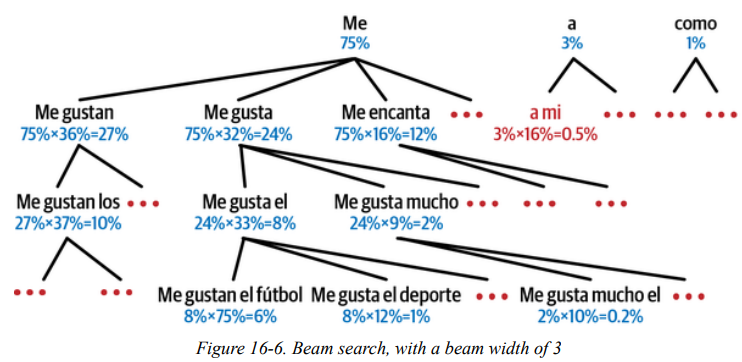

- For example, suppose you use the model to translate the sentence “I like soccer” using beam
search with a beam width of 3 (see Figure 16-6). At the first decoder step, the model will output
an estimated probability for each possible first word in the translated sentence. Suppose the top
three words are “me” (75% estimated probability), “a” (3%), and “como” (1%). That’s our
short list so far.

 Next, we use the model to find the next word for each sentence. For the first
sentence (“me”), perhaps the model outputs a probability of 36% for the word “gustan”, 32%
for the word “gusta”, 16% for the word “encanta”, and so on. Note that these are actually
conditional probabilities, given that the sentence starts with “me”. For the second sentence
(“a”), the model might output a conditional probability of 50% for the word “mi”, and so on.

 Assuming the vocabulary has 1,000 words, we will end up with 1,000 probabilities per
sentence.

 Next, we compute the probabilities of each of the 3,000 two-word sentences we considered (3 ×
1,000). We do this by multiplying the estimated conditional probability of each word by the
estimated probability of the sentence it completes. For example, the estimated probability of the
sentence “me” was 75%, while the estimated conditional probability of the word “gustan”
(given that the first word is “me”) was 36%, so the estimated probability of the sentence “me
gustan” is 75% × 36% = 27%.

 After computing the probabilities of all 3,000 two-word
sentences, we keep only the top 3. In this example they all start with the word “me”: “me
gustan” (27%), “me gusta” (24%), and “me encanta” (12%). Right now, the sentence “me
gustan” is winning, but “me gusta” has not been eliminated.

 Then we repeat the same process: we use the model to predict the next word in each of these
three sentences, and we compute the probabilities of all 3,000 three-word sentences we
considered. Perhaps the top three are now “me gustan los” (10%), “me gusta el” (8%), and “me
gusta mucho” (2%). At the next step we may get “me gusta el fútbol” (6%), “me gusta mucho
el” (1%), and “me gusta el deporte” (0.2%). Notice that “me gustan” was eliminated, and the
correct translation is now ahead.

- We boosted our encoder–decoder model’s performance
without any extra training


In [38]:
def beam_search(text, vectorizer, model, beam_width=3, top_translations=[(0, "startofseq")], word_idx=0, max_words=50, verbose=False):

    if word_idx == max_words or all([tr.endswith("endofseq") for _, tr in top_translations]):
        return top_translations[0][1].replace("endofseq", "").replace("startofseq", "").strip()

    candidates = []
    # Go through all pairs of previous top translations and their probability
    for log_proba, tr in top_translations:
        # No prediction of the next word for translations that are already ended
        if tr.endswith("endofseq"):
            candidates.append((log_proba, tr))
            continue

        # Predict and record all possible new translations with their probability
        x_decoder = np.array([tr])
        x_encoder = np.array([text])
        y_proba = model.predict((x_encoder, x_decoder), verbose=False)[0, word_idx]

        for word_id, cond_proba in enumerate(y_proba):
            word = vectorizer.get_vocabulary()[word_id]
            candidates.append((log_proba + np.log(cond_proba), f"{tr} {word}"))

    # Get updated top translations
    top_translations = sorted(candidates, key=lambda x: x[0], reverse=True)[:beam_width]

    if verbose:
        print("Top translations so far:", top_translations)

    word_idx += 1

    return beam_search(text, vectorizer, model, beam_width=3, top_translations=top_translations, word_idx=word_idx, max_words=50, verbose=verbose)

## Attention Mechanisms

- Even with bi-directional encoder decoder architecture along with beam search, we are not able to translate long sentences. Once again, the problem comes from the limited short-term memory of RNNs. Attention mechanisms are the game-changing
innovation that addressed this problem.

- Consider the path from the word “soccer” to its translation “fútbol” back in Figure 16-3: it is
quite long! This means that a representation of this word (along with all the other words) needs
to be carried over many steps before it is actually used. Can’t we make this path shorter?

- This was the core idea in a landmark 2014 paper by Dzmitry Bahdanau et al., where the
authors introduced a technique that allowed the decoder to focus on the appropriate words (as
encoded by the encoder) at each time step. For example, at the time step where the decoder
needs to output the word “fútbol”, it will focus its attention on the word “soccer”.

- This means
that the path from an input word to its translation is now much shorter, so the short-term
memory limitations of RNNs have much less impact.


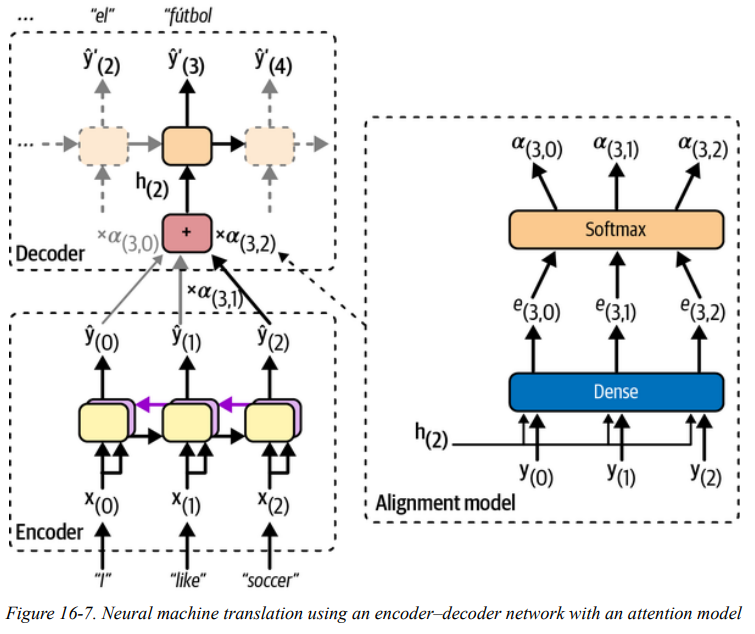

- Figure 16-7 shows our encoder–decoder model with an added attention mechanism. On the left,
you have the encoder and the decoder. Instead of just sending the encoder’s final hidden state to
the decoder, as well as the previous target word at each step (which is still done, although it is
not shown in the figure), we now send all of the encoder’s outputs to the decoder as well.

- Since
the decoder cannot deal with all these encoder outputs at once, they need to be aggregated: at
each time step, the decoder’s memory cell computes a weighted sum of all the encoder outputs.
This determines which words it will focus on at this step.

- The weight α(t,i) is the weight of the
i encoder output at the t decoder time step. For example, if the weight α(3,2) is much larger
than the weights α(3,0) and α(3,1) , then the decoder will pay much more attention to the encoder’s
output for word #2 (“soccer”) than to the other two outputs, at least at this time step.

- The rest of
the decoder works just like earlier: at each time step the memory cell receives the inputs we just
discussed, plus the hidden state from the previous time step, and finally (although it is not
represented in the diagram) it receives the target word from the previous time step (or at
inference time, the output from the previous time step).


- But where do these α(t,i) weights come from? Well, they are generated by a small neural
network called an alignment model (or an attention layer), which is trained jointly with the rest
of the encoder–decoder model. This alignment model is illustrated on the righthand side of
Figure 16-7. It starts with a Dense layer composed of a single neuron that processes each of
the encoder’s outputs, along with the decoder’s previous hidden state (e.g., h(2) ). This layer
outputs a score (or energy) for each encoder output (e.g., e(3,2) ): this score measures how well
each output is aligned with the decoder’s previous hidden state.
- For example, in Figure 16-7,
the model has already output “me gusta el” (meaning “I like”), so it’s now expecting a noun:
the word “soccer” is the one that best aligns with the current state, so it gets a high score.
Finally, all the scores go through a softmax layer to get a final weight for each encoder output
(e.g., α(3,2) ). All the weights for a given decoder time step add up to 1.
- This particular attention
mechanism is called **Bahdanau attention** (named after the 2014 paper’s first author). Since it
concatenates the encoder output with the decoder’s previous hidden state, it is sometimes called **concatenative attention (or additive attention)**.


- Another common attention mechanism, known as **Luong attention or multiplicative attention**,
was proposed shortly after, in 2015, by Minh-Thang Luong et al. Because the goal of the
alignment model is to measure the similarity between one of the encoder’s outputs and the
decoder’s previous hidden state, the authors proposed to simply compute the **dot product** of these two vectors, as this is often a fairly good similarity measure, and modern
hardware can compute it very efficiently. For this to be possible, both vectors must have the
same dimensionality. The dot product gives a score, and all the scores (at a given decoder time
step) go through a softmax layer to give the final weights, just like in Bahdanau attention.

- Another **simplification Luong** et al. proposed was to use the decoder’s hidden state at the
current time step rather than at the previous time step (i.e., h(t) rather than h(t-1)), then to use the
output of the attention mechanism (noted h˜(t)) directly to compute the decoder’s predictions,
rather than using it to compute the decoder’s current hidden state.

- The researchers also
proposed a variant of the dot product mechanism where the encoder outputs first go through a fully connected layer (without a bias term) before the dot products are computed. This is called
the **“general” dot product** approach.

- The researchers compared both dot product approaches
with the concatenative attention mechanism (adding a rescaling parameter vector v), and they
observed that the **dot product variants performed better than concatenative attention**. For this
reason, concatenative attention is much less used now.


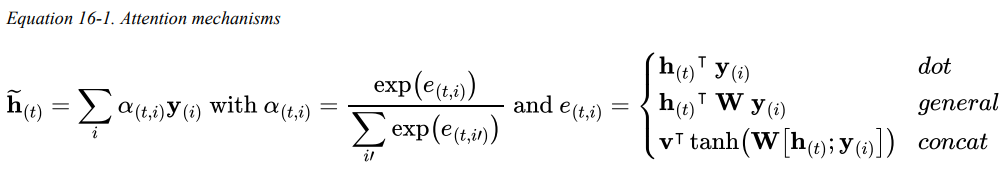

- Keras provides a `tf.keras.layers.Attention` layer for Luong attention, and an
`AdditiveAttention` layer for Bahdanau attention.

### Implementation:

In [1]:
import tensorflow as tf
import numpy as np

url = "https://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip"
tf.keras.utils.get_file("spa-eng.zip", url, extract=True, cache_dir="./")

with open("./datasets/spa-eng/spa.txt") as f:
    text = f.read()

text = text.replace("¿", "").replace("¡", "")
pairs = [line.split("\t") for line in text.splitlines()]

np.random.seed(42)
np.random.shuffle(pairs)
sentences_en, sentences_es= zip(*pairs)

vocab_size = 1000
max_length = 50

en_vectorizer = tf.keras.layers.TextVectorization(max_tokens=vocab_size, output_sequence_length=max_length)
en_vectorizer.adapt(sentences_en)
es_vectorizer = tf.keras.layers.TextVectorization(max_tokens=vocab_size, output_sequence_length=max_length)
es_vectorizer.adapt([f"startofseq {s} endofseq" for s in sentences_es])

# [100,000, ~19000]
X_train_enc = tf.constant(sentences_en[:100_000])
X_valid_enc = tf.constant(sentences_en[100_000:])
X_train_dec = tf.constant([f"startofseq {s}" for s in sentences_es[:100_000]])
X_valid_dec = tf.constant([f"startofseq {s}" for s in sentences_es[100_000:]])
y_train = es_vectorizer([f"{s} endofseq" for s in sentences_es[:100_000]])
y_valid = es_vectorizer([f"{s} endofseq" for s in sentences_es[100_000:]])

2638744/2638744 [==============================] - 1s 0us/step


- We need to create the attention layer and pass it the decoder’s states and the encoder’s
outputs. However, to access the decoder’s states at each step we would need to write a custom
memory cell. For simplicity, let’s use the decoder’s outputs instead of its states: in practice this
works well too, and it’s much easier to code. Then we just pass the attention layer’s outputs
directly to the output layer, as suggested in the Luong attention paper:

In [17]:
# Lets create the model
tf.keras.utils.set_random_seed(42)
tf.keras.backend.clear_session()

# Input Embeddings:
encoder_input = tf.keras.layers.Input(shape=[], dtype=tf.string)
decoder_input = tf.keras.layers.Input(shape=[], dtype=tf.string)

encoder_input_ids = en_vectorizer(encoder_input)
decoder_input_ids = es_vectorizer(decoder_input)

embed_size = 128
encoder_embedder = tf.keras.layers.Embedding(vocab_size, embed_size, mask_zero=True)
decoder_embedder = tf.keras.layers.Embedding(vocab_size, embed_size, mask_zero=True)
encoder_embeddings = encoder_embedder(encoder_input_ids)
decoder_embeddings = decoder_embedder(decoder_input_ids)

# Architecture:
encoder = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(256, return_state=True, return_sequences=True))
encoder_outputs, *encoder_states = encoder(encoder_embeddings)
encoder_state = [tf.concat(encoder_states[::2], axis=-1),  # short-term (0 & 2)
               tf.concat(encoder_states[1::2], axis=-1)]  # long-term (1 & 3)

decoder = tf.keras.layers.LSTM(512, return_sequences=True)
decoder_outputs = decoder(decoder_embeddings, initial_state=encoder_state)

attention = tf.keras.layers.Attention()
attention_outputs = attention([decoder_outputs, encoder_outputs])

output_layer = tf.keras.layers.Dense(vocab_size, activation="softmax")
y_proba = output_layer(attention_outputs)

model = tf.keras.Model(inputs=[encoder_input, decoder_input], outputs=[y_proba])

- Do not use Dropout in this model. It increases the accuracy but also increase the prediction of unknown words [UNK].

 Why accuracy increase?

 Because we are using small vocabulary such that most of tokens in encoded input are [UNK] so predicting more [UNK] increases accuracy. For example, if a sentence has 90% [UNK] tokens then predicting all tokens as [UNK] will give 90% accuracy

 Why [UNK] increases and performance decreases?

 Because Embeddings are dense representations of words, and applying dropout directly to them might interfere with the semantic information they carry. It's generally recommended to apply dropout to the outputs of layers, not directly to embeddings.

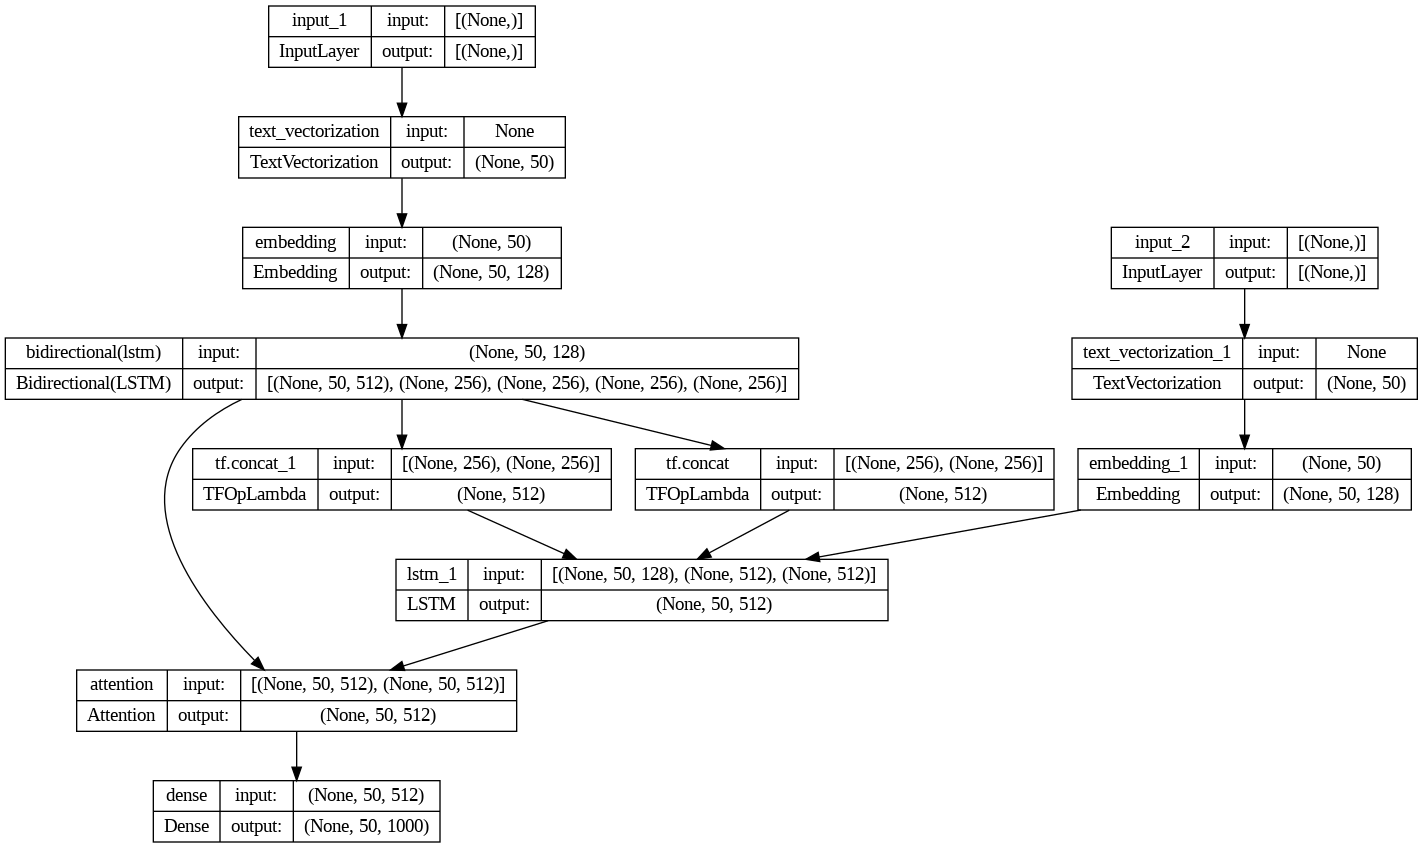

In [18]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [19]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
model.fit((X_train_enc, X_train_dec), y_train, validation_data=((X_valid_enc, X_valid_dec), y_valid), epochs=6)

Epoch 1/6
3125/3125 [==============================] - 132s 37ms/step - loss: 2.8237 - accuracy: 0.4569 - val_loss: 1.8633 - val_accuracy: 0.5891
Epoch 2/6
3125/3125 [==============================] - 85s 27ms/step - loss: 1.6031 - accuracy: 0.6332 - val_loss: 1.4783 - val_accuracy: 0.6570
Epoch 3/6
3125/3125 [==============================] - 82s 26ms/step - loss: 1.3390 - accuracy: 0.6818 - val_loss: 1.3471 - val_accuracy: 0.6818
Epoch 4/6
3125/3125 [==============================] - 83s 27ms/step - loss: 1.1965 - accuracy: 0.7081 - val_loss: 1.2925 - val_accuracy: 0.6936
Epoch 5/6
3125/3125 [==============================] - 83s 27ms/step - loss: 1.0904 - accuracy: 0.7285 - val_loss: 1.2590 - val_accuracy: 0.7001
Epoch 6/6
3125/3125 [==============================] - 83s 27ms/step - loss: 1.0032 - accuracy: 0.7454 - val_loss: 1.2560 - val_accuracy: 0.7036


In [20]:
def translate(text):
    translation = ""
    x_encoder = np.array([text])
    for word_idx in range(max_length):
        x_decoder = np.array(["startofseq " + translation])
        y_proba = model.predict((x_encoder, x_decoder), verbose=0)
        y_pred_idx = np.argmax(y_proba[0, word_idx, :])
        y_pred = es_vectorizer.get_vocabulary()[y_pred_idx]
        if y_pred == "endofseq":
            break
        translation += " " + y_pred
    return translation.strip()

In [21]:
translate("I like soccer and also going to the beach")

'me gusta fútbol y también a la playa'

In [22]:
beam_search("I like soccer and also going to the beach", beam_width=3,
            verbose=True, vectorizer=es_vectorizer, model=model)

Top translations so far: [(-0.6581103205680847, 'startofseq me'), (-1.5136781930923462, 'startofseq a'), (-2.9140169620513916, 'startofseq yo')]
Top translations so far: [(-0.6870023254305124, 'startofseq me gusta'), (-2.496407687664032, 'startofseq a a'), (-3.595934510231018, 'startofseq a [UNK]')]
Top translations so far: [(-0.942048067227006, 'startofseq me gusta fútbol'), (-2.291152024641633, 'startofseq me gusta el'), (-2.6919934302568436, 'startofseq a a la')]
Top translations so far: [(-1.0209172237664461, 'startofseq me gusta fútbol y'), (-2.320936609059572, 'startofseq me gusta el fútbol'), (-2.7007603710517287, 'startofseq a a la playa')]
Top translations so far: [(-1.3711034525185823, 'startofseq me gusta fútbol y también'), (-2.341906301677227, 'startofseq me gusta el fútbol y'), (-2.9403859842568636, 'startofseq me gusta fútbol y ella')]
Top translations so far: [(-1.8422077167779207, 'startofseq me gusta fútbol y también a'), (-2.6455033347010612, 'startofseq me gusta el 

'me gusta fútbol y también a la playa'

In [36]:
translate("I love my cat and hate dogs")

'me quiero a mi gato y odio a los perros'

In [39]:
beam_search("I love my cat and hate dogs", beam_width=3,
            verbose=False, vectorizer=es_vectorizer, model=model)

'me amo a mi gato y odio a los perros'